In [19]:
import csv

import numpy as np

try:
    from gensim import models
except ModuleNotFoundError as e:
    !pip install gensim==3.8.0
    from gensim import models
try:
    import pandas as pd
except ModuleNotFoundError as e:
    !pip install pandas
    import pandas as pd
    
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError as e:
    !pip install matplitlib
    import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
# This line prevents TF crashing when using convolutional networks
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [21]:
def prepare_data(model_path, data_prefix, seq_len, embedding_size):
    """
    
    Args:
        model_path (str): path to embedding model
        data_prefix (str): path to data prefix
    
    """
    
    def load_data(path):
        output = []
        
        with open(path, 'r', encoding='latin-1') as data:
        #with open(path, 'r', encoding='utf-8') as data:
            for row in csv.reader(data):
                output.append(row)
                
        return output
    
    # Opens embedding model
    model_ = models.Word2Vec.load(model_path)
    
    # Open dataset
    data_train = load_data(data_prefix + "X_train.csv")
    data_val = load_data(data_prefix + "X_val.csv")
    label_train = np.loadtxt(data_prefix + "y_train.csv")
    label_val = np.loadtxt(data_prefix + "y_val.csv")
    
    # Gets embeddings from model
    dt = []
    lt = []
    omissions_ = 0
    
    for i, seq in enumerate(data_train):
        
        try:        
            embedding = model_.wv[seq]
            dt.append(embedding)
            lt.append(label_train[i])
        
        except KeyError as ke:
            for word in seq:
                if word not in model_.wv.vocab.keys():
                    seq.remove(word)
            
        except ValueError as ve:
            omissions_ += 1
            
#     print(omissions_)
    
    # Gets embeddings from model
    dv = []
    lv = []
    omissions_ = 0
    
    for i, seq in enumerate(data_val):
        
        try:
            embedding = model_.wv[seq]
            dv.append(embedding)
            lv.append(label_val[i])
        
        except KeyError as ke:
            for word in seq:
                if word not in model_.wv.vocab.keys():
                    seq.remove(word)
            
        except ValueError as ve:
            omissions_ += 1
    
#     print(omissions_)
    
    # Pads sequences
    dt = pad_sequences(dt, padding='post', dtype='float64', maxlen=seq_len)
    dv = pad_sequences(dv, padding='post', dtype='float64', maxlen=seq_len)
    
    # Converts lists to numpy arrays
#     dt = np.asarray(dt).reshape((len(dt), seq_len * embedding_size))
#     dv = np.asarray(dv).reshape((len(dv), seq_len * embedding_size))
    
    lt = np.asarray(lt)
    lv = np.asarray(lv)
    
    return dt, dv, lt, lv

In [22]:
simpson_dict = {15: "./resources/embeddings/Simpsons_15_7.model",
                75: "./resources/embeddings/Simpsons_75_7.model",
                150: "./resources/embeddings/Simpsons_150_7.model",
                'prefix': "./data/simpsons/",
                'classes': 4}

friends_dict = {5: "./resources/embeddings/Friends_5_7.model",
                25: "./resources/embeddings/Friends_25_7.model",
                125: "./resources/embeddings/Friends_125_7.model",
                'prefix': "./data/friends/",
                'classes': 6}

In [23]:
def create_checkpoint_callback(filepath):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        save_weights_only = False,
        monitor = 'val_loss',
        mode = 'min',
        save_best_only = True)
    return model_checkpoint_callback

In [24]:
def create_early_stop_callback():
    callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 0, patience = 30, verbose = 0,
    mode = 'min', baseline = None, restore_best_weights = False)
    return callback

## Model creators

In [34]:
def create_base_model(embedding_size, seq_len, classes, input_shape):
    model = keras.Sequential([
        layers.Dense((embedding_size * seq_len)/2, activation="relu", input_shape = input_shape),
        layers.Dense(classes, activation='softmax')
    ])
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()]
    )
    model.summary()
    return model

In [35]:
def create_deepFC_model(embedding_size, seq_len, classes, input_shape):
    model = keras.Sequential([
        layers.Dense((embedding_size * seq_len)/2, activation="relu", input_shape = input_shape),
        layers.Dropout(0.2),
        layers.Dense((embedding_size * seq_len)/2, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense((embedding_size * seq_len)/2, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense((embedding_size * seq_len)/2, activation="relu"),
        layers.Dense(classes, activation='softmax')
    ])
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()]
    )
    model.summary()
    return model

In [36]:
def create_RNN_model(embedding_size, seq_len, classes, input_shape):
    model = keras.Sequential([
        layers.SimpleRNN(units = 75, input_shape=input_shape),
#         layers.SimpleRNN(units = 20, return_sequences=True),
#         layers.SimpleRNN(units = 20, return_sequences=True),
        layers.Flatten(),
        layers.Dense((embedding_size * seq_len)/2, activation="relu"),
        layers.Dense(classes, activation='softmax')
    ])
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()]
    )
    model.summary()
    return model

In [37]:
def create_LSTM_model(embedding_size, seq_len, classes, input_shape):
    model = keras.Sequential([
        layers.LSTM(units = 75, input_shape = input_shape),
#         layers.LSTM(units = 20, return_sequences=True),
#         layers.LSTM(units = 20, return_sequences=True),
        layers.Flatten(),
        layers.Dense((embedding_size * seq_len)/2, activation="relu"),
        layers.Dense(classes, activation='softmax')
    ])
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()]
    )
    model.summary()
    return model

In [38]:
model_creators = {'baseline': create_base_model,
                  'DeepFC': create_deepFC_model,
                  'SimpleRNN': create_RNN_model,
                  'LSTM': create_LSTM_model}

## Training methods

In [41]:
def train_val_model(dataset, em_size, seq_len, model_type, epochs):
    if dataset == 'simpson':
        data_path = simpson_dict
    elif dataset == 'friends':
        data_path = friends_dict
    else: 
        raise 'Not valid dataset'
        
    X_train, X_val, y_train, y_val = prepare_data(data_path[em_size], data_path['prefix'],
                                                  seq_len, em_size)
    
    if model_type in  ['baseline', 'DeepFC']:
        X_train = np.asarray(X_train).reshape((len(X_train), seq_len * em_size))
        X_val = np.asarray(X_val).reshape((len(X_val), seq_len * em_size))
    
    checkpoint_callback = create_checkpoint_callback('./resources/checkpoints/' + model_type + '_' + 
                                          str(em_size) + '_' +str(seq_len))
    
    early_stop_callback = create_early_stop_callback()
    
    input_shape = (len(X_train), seq_len * em_size) if model_type in ['baseline','DeepFC'] else (seq_len, em_size)
    
    model = model_creators[model_type](em_size, seq_len, data_path['classes'], 
                                       input_shape=input_shape)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
              epochs = epochs, verbose = 0, 
              callbacks=[checkpoint_callback, early_stop_callback])
    
    model_metrics_train = model.evaluate(x = X_train, y = y_train)
    model_metrics_val = model.evaluate(x = X_val, y = y_val)
    data = {'model_name': [model_type], 'embedding_size': [em_size], 'seq_len': [seq_len],
            'train_accuracy': [model_metrics_train[1]], 'train_precision': [model_metrics_train[2]], 'train_recall': [model_metrics_train[3]],
           'val_accuracy': [model_metrics_val[1]], 'val_precision': [model_metrics_val[2]], 'val_recall': [model_metrics_val[3]]}
    
    return pd.DataFrame(data=data), history

## Model Training

In [43]:
SEQ_LEN_ = [8, 15, 25, 30, 50]
EM_SIZE_ = [15,75,150]
MODEL_TYPES_ = ['baseline','DeepFC', 'SimpleRNN', 'LSTM']
metrics_df = pd.DataFrame()
histories = []
for seq_len in SEQ_LEN_:
    for em_size in EM_SIZE_:
        for model_type in MODEL_TYPES_:
            model_results, history = train_val_model('simpson', em_size, seq_len, model_type, 1000)
            metrics_df = pd.concat([metrics_df, model_results])
            histories.append(history)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 21178, 60)         7260      
_________________________________________________________________
dense_47 (Dense)             (None, 21178, 4)          244       
Total params: 7,504
Trainable params: 7,504
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_8/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.3808 - accuracy: 0.4368 - precision_16: 0.4896 - recall_16: 0.2616
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 21178, 60)         7260      
_________________________________________________________________
dropout_13 (Dropout)         (None, 21178, 60)         0         
_________________________________________________________________
dense_49 (Dense)             (None, 21178, 60)         3660      
_________________________________________________________________
dropout_14 (Dropout)         (None, 21178, 60)         0         
_________________________________________________________________
dense_50 (Dense)             (None, 21178, 60)         3660      
_________________________________________________________________
dropout_15 (Dropout)         (None, 21178, 60)       

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_8/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.2750 - accuracy: 0.4593 - precision_17: 0.5380 - recall_17: 0.2109
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 75)                6825      
_________________________________________________________________
flatten_9 (Flatten)          (None, 75)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 60)                4560      
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 244       
Total params: 11,629
Trainable params: 11,629
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_8/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.3748 - accuracy: 0.4409 - precision_18: 0.4970 - recall_18: 0.2818
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 75)                27300     
_________________________________________________________________
flatten_10 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 60)                4560      
_________________________________________________________________
dense_56 (Dense)             (None, 4)                 244       
Total params: 32,104
Trainable params: 32,104
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_8/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.5070 - accuracy: 0.4664 - precision_19: 0.5095 - recall_19: 0.3357
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 21178, 300)        180300    
_________________________________________________________________
dense_58 (Dense)             (None, 21178, 4)          1204      
Total params: 181,504
Trainable params: 181,504
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_75_8/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.4357 - accuracy: 0.4402 - precision_20: 0.4573 - recall_20: 0.3870
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 21178, 300)        180300    
_________________________________________________________________
dropout_16 (Dropout)         (None, 21178, 300)        0         
_________________________________________________________________
dense_60 (Dense)             (None, 21178, 300)        90300     
_________________________________________________________________
dropout_17 (Dropout)         (None, 21178, 300)        0         
_________________________________________________________________
dense_61 (Dense)             (None, 21178, 300)        90300     
_________________________________________________________________
dropout_18 (Dropout)         (None, 21178, 300)      

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_8/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.5280 - accuracy: 0.4441 - precision_21: 0.4704 - recall_21: 0.3723
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 75)                11325     
_________________________________________________________________
flatten_11 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 300)               22800     
_________________________________________________________________
dense_65 (Dense)             (None, 4)                 1204      
Total params: 35,329
Trainable params: 35,329
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_8/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.1627 - accuracy: 0.4341 - precision_22: 0.4556 - recall_22: 0.3591
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 75)                45300     
_________________________________________________________________
flatten_12 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 300)               22800     
_________________________________________________________________
dense_67 (Dense)             (None, 4)                 1204      
Total params: 69,304
Trainable params: 69,304
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_8/assets


138/138 [==============================] - 0s 2ms/step - loss: 3.1295 - accuracy: 0.4700 - precision_23: 0.4940 - recall_23: 0.3841
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 21178, 600)        720600    
_________________________________________________________________
dense_69 (Dense)             (None, 21178, 4)          2404      
Total params: 723,004
Trainable params: 723,004
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_150_8/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.3877 - accuracy: 0.4520 - precision_24: 0.4757 - recall_24: 0.3966
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 21178, 600)        720600    
_________________________________________________________________
dropout_19 (Dropout)         (None, 21178, 600)        0         
_________________________________________________________________
dense_71 (Dense)             (None, 21178, 600)        360600    
_________________________________________________________________
dropout_20 (Dropout)         (None, 21178, 600)        0         
_________________________________________________________________
dense_72 (Dense)             (None, 21178, 600)        360600    
_________________________________________________________________
dropout_21 (Dropout)         (None, 21178, 600)      

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_8/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.8995 - accuracy: 0.4636 - precision_25: 0.4810 - recall_25: 0.3902
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 75)                16950     
_________________________________________________________________
flatten_13 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 600)               45600     
_________________________________________________________________
dense_76 (Dense)             (None, 4)                 2404      
Total params: 64,954
Trainable params: 64,954
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_8/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.6266 - accuracy: 0.4250 - precision_26: 0.4488 - recall_26: 0.3530
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 75)                67800     
_________________________________________________________________
flatten_14 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 600)               45600     
_________________________________________________________________
dense_78 (Dense)             (None, 4)                 2404      
Total params: 115,804
Trainable params: 115,804
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_8/assets


138/138 [==============================] - 0s 2ms/step - loss: 3.8293 - accuracy: 0.4557 - precision_27: 0.4732 - recall_27: 0.3830
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 21178, 112)        25312     
_________________________________________________________________
dense_80 (Dense)             (None, 21178, 4)          452       
Total params: 25,764
Trainable params: 25,764
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_15/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.6205 - accuracy: 0.4334 - precision_28: 0.4780 - recall_28: 0.2895
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 21178, 112)        25312     
_________________________________________________________________
dropout_22 (Dropout)         (None, 21178, 112)        0         
_________________________________________________________________
dense_82 (Dense)             (None, 21178, 112)        12656     
_________________________________________________________________
dropout_23 (Dropout)         (None, 21178, 112)        0         
_________________________________________________________________
dense_83 (Dense)             (None, 21178, 112)        12656     
_________________________________________________________________
dropout_24 (Dropout)         (None, 21178, 112)      

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_15/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.4350 - accuracy: 0.4586 - precision_29: 0.5309 - recall_29: 0.2673
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 75)                6825      
_________________________________________________________________
flatten_15 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 112)               8512      
_________________________________________________________________
dense_87 (Dense)             (None, 4)                 452       
Total params: 15,789
Trainable params: 15,789
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_15/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.3025 - accuracy: 0.4614 - precision_30: 0.5264 - recall_30: 0.2698
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 75)                27300     
_________________________________________________________________
flatten_16 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 112)               8512      
_________________________________________________________________
dense_89 (Dense)             (None, 4)                 452       
Total params: 36,264
Trainable params: 36,264
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_15/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.5500 - accuracy: 0.4675 - precision_31: 0.5213 - recall_31: 0.2695
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 21178, 562)        632812    
_________________________________________________________________
dense_91 (Dense)             (None, 21178, 4)          2252      
Total params: 635,064
Trainable params: 635,064
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_75_15/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.3133 - accuracy: 0.4475 - precision_32: 0.4697 - recall_32: 0.3925
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 21178, 562)        632812    
_________________________________________________________________
dropout_25 (Dropout)         (None, 21178, 562)        0         
_________________________________________________________________
dense_93 (Dense)             (None, 21178, 562)        316406    
_________________________________________________________________
dropout_26 (Dropout)         (None, 21178, 562)        0         
_________________________________________________________________
dense_94 (Dense)             (None, 21178, 562)        316406    
_________________________________________________________________
dropout_27 (Dropout)         (None, 21178, 562)      

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_15/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.9233 - accuracy: 0.4580 - precision_33: 0.4744 - recall_33: 0.3816
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 75)                11325     
_________________________________________________________________
flatten_17 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 562)               42712     
_________________________________________________________________
dense_98 (Dense)             (None, 4)                 2252      
Total params: 56,289
Trainable params: 56,289
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_15/assets


138/138 [==============================] - 0s 3ms/step - loss: 1.7820 - accuracy: 0.4316 - precision_34: 0.4764 - recall_34: 0.3252
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 75)                45300     
_________________________________________________________________
flatten_18 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 562)               42712     
_________________________________________________________________
dense_100 (Dense)            (None, 4)                 2252      
Total params: 90,264
Trainable params: 90,264
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_15/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.3456 - accuracy: 0.4666 - precision_35: 0.4987 - recall_35: 0.3607
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 21178, 1125)       2532375   
_________________________________________________________________
dense_102 (Dense)            (None, 21178, 4)          4504      
Total params: 2,536,879
Trainable params: 2,536,879
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_150_15/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.1908 - accuracy: 0.4625 - precision_36: 0.4903 - recall_36: 0.4002
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 21178, 1125)       2532375   
_________________________________________________________________
dropout_28 (Dropout)         (None, 21178, 1125)       0         
_________________________________________________________________
dense_104 (Dense)            (None, 21178, 1125)       1266750   
_________________________________________________________________
dropout_29 (Dropout)         (None, 21178, 1125)       0         
_________________________________________________________________
dense_105 (Dense)            (None, 21178, 1125)       1266750   
_________________________________________________________________
dropout_30 (Dropout)         (None, 21178, 1125)     

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_15/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.7425 - accuracy: 0.4645 - precision_37: 0.4869 - recall_37: 0.3855
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 75)                16950     
_________________________________________________________________
flatten_19 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 1125)              85500     
_________________________________________________________________
dense_109 (Dense)            (None, 4)                 4504      
Total params: 106,954
Trainable params: 106,954
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_15/assets


138/138 [==============================] - 0s 3ms/step - loss: 2.1319 - accuracy: 0.4441 - precision_38: 0.4803 - recall_38: 0.3518
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 75)                67800     
_________________________________________________________________
flatten_20 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 1125)              85500     
_________________________________________________________________
dense_111 (Dense)            (None, 4)                 4504      
Total params: 157,804
Trainable params: 157,804
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_15/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.9161 - accuracy: 0.4657 - precision_39: 0.4971 - recall_39: 0.3734
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 21178, 187)        70312     
_________________________________________________________________
dense_113 (Dense)            (None, 21178, 4)          752       
Total params: 71,064
Trainable params: 71,064
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_25/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.7491 - accuracy: 0.4332 - precision_40: 0.4747 - recall_40: 0.3286
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 21178, 187)        70312     
_________________________________________________________________
dropout_31 (Dropout)         (None, 21178, 187)        0         
_________________________________________________________________
dense_115 (Dense)            (None, 21178, 187)        35156     
_________________________________________________________________
dropout_32 (Dropout)         (None, 21178, 187)        0         
_________________________________________________________________
dense_116 (Dense)            (None, 21178, 187)        35156     
_________________________________________________________________
dropout_33 (Dropout)         (None, 21178, 187)      

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_25/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.6207 - accuracy: 0.4411 - precision_41: 0.4888 - recall_41: 0.2864
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 75)                6825      
_________________________________________________________________
flatten_21 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_119 (Dense)            (None, 187)               14212     
_________________________________________________________________
dense_120 (Dense)            (None, 4)                 752       
Total params: 21,789
Trainable params: 21,789
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_25/assets


138/138 [==============================] - 0s 3ms/step - loss: 1.2239 - accuracy: 0.4736 - precision_42: 0.5708 - recall_42: 0.2007
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 75)                27300     
_________________________________________________________________
flatten_22 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 187)               14212     
_________________________________________________________________
dense_122 (Dense)            (None, 4)                 752       
Total params: 42,264
Trainable params: 42,264
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_25/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.3647 - accuracy: 0.4736 - precision_43: 0.5621 - recall_43: 0.2602
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 21178, 937)        1757812   
_________________________________________________________________
dense_124 (Dense)            (None, 21178, 4)          3752      
Total params: 1,761,564
Trainable params: 1,761,564
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_75_25/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.3914 - accuracy: 0.4420 - precision_44: 0.4650 - recall_44: 0.3830
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 21178, 937)        1757812   
_________________________________________________________________
dropout_34 (Dropout)         (None, 21178, 937)        0         
_________________________________________________________________
dense_126 (Dense)            (None, 21178, 937)        878906    
_________________________________________________________________
dropout_35 (Dropout)         (None, 21178, 937)        0         
_________________________________________________________________
dense_127 (Dense)            (None, 21178, 937)        878906    
_________________________________________________________________
dropout_36 (Dropout)         (None, 21178, 937)      

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_25/assets


138/138 [==============================] - 0s 2ms/step - loss: 3.3698 - accuracy: 0.4411 - precision_45: 0.4584 - recall_45: 0.3709
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (None, 75)                11325     
_________________________________________________________________
flatten_23 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_130 (Dense)            (None, 937)               71212     
_________________________________________________________________
dense_131 (Dense)            (None, 4)                 3752      
Total params: 86,289
Trainable params: 86,289
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_25/assets


138/138 [==============================] - 0s 3ms/step - loss: 1.3169 - accuracy: 0.4727 - precision_46: 0.5409 - recall_46: 0.3068
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 75)                45300     
_________________________________________________________________
flatten_24 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_132 (Dense)            (None, 937)               71212     
_________________________________________________________________
dense_133 (Dense)            (None, 4)                 3752      
Total params: 120,264
Trainable params: 120,264
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_25/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.8802 - accuracy: 0.4691 - precision_47: 0.5199 - recall_47: 0.3561
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 21178, 1875)       7033125   
_________________________________________________________________
dense_135 (Dense)            (None, 21178, 4)          7504      
Total params: 7,040,629
Trainable params: 7,040,629
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_150_25/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.2836 - accuracy: 0.4618 - precision_48: 0.4832 - recall_48: 0.3950
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 21178, 1875)       7033125   
_________________________________________________________________
dropout_37 (Dropout)         (None, 21178, 1875)       0         
_________________________________________________________________
dense_137 (Dense)            (None, 21178, 1875)       3517500   
_________________________________________________________________
dropout_38 (Dropout)         (None, 21178, 1875)       0         
_________________________________________________________________
dense_138 (Dense)            (None, 21178, 1875)       3517500   
_________________________________________________________________
dropout_39 (Dropout)         (None, 21178, 1875)     

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_25/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.8079 - accuracy: 0.4600 - precision_49: 0.4813 - recall_49: 0.3752
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 75)                16950     
_________________________________________________________________
flatten_25 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_141 (Dense)            (None, 1875)              142500    
_________________________________________________________________
dense_142 (Dense)            (None, 4)                 7504      
Total params: 166,954
Trainable params: 166,954
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_25/assets


138/138 [==============================] - 0s 3ms/step - loss: 1.3473 - accuracy: 0.4870 - precision_50: 0.5475 - recall_50: 0.3184
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 75)                67800     
_________________________________________________________________
flatten_26 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_143 (Dense)            (None, 1875)              142500    
_________________________________________________________________
dense_144 (Dense)            (None, 4)                 7504      
Total params: 217,804
Trainable params: 217,804
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_25/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.0790 - accuracy: 0.4855 - precision_51: 0.5184 - recall_51: 0.3948
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 21178, 225)        101475    
_________________________________________________________________
dense_146 (Dense)            (None, 21178, 4)          904       
Total params: 102,379
Trainable params: 102,379
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_30/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.8702 - accuracy: 0.4248 - precision_52: 0.4578 - recall_52: 0.3036
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 21178, 225)        101475    
_________________________________________________________________
dropout_40 (Dropout)         (None, 21178, 225)        0         
_________________________________________________________________
dense_148 (Dense)            (None, 21178, 225)        50850     
_________________________________________________________________
dropout_41 (Dropout)         (None, 21178, 225)        0         
_________________________________________________________________
dense_149 (Dense)            (None, 21178, 225)        50850     
_________________________________________________________________
dropout_42 (Dropout)         (None, 21178, 225)      

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_30/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.6594 - accuracy: 0.4400 - precision_53: 0.4882 - recall_53: 0.3098
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, 75)                6825      
_________________________________________________________________
flatten_27 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_152 (Dense)            (None, 225)               17100     
_________________________________________________________________
dense_153 (Dense)            (None, 4)                 904       
Total params: 24,829
Trainable params: 24,829
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_30/assets


138/138 [==============================] - 0s 3ms/step - loss: 1.2775 - accuracy: 0.4250 - precision_54: 0.5786 - recall_54: 0.0184
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 75)                27300     
_________________________________________________________________
flatten_28 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_154 (Dense)            (None, 225)               17100     
_________________________________________________________________
dense_155 (Dense)            (None, 4)                 904       
Total params: 45,304
Trainable params: 45,304
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_30/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.3328 - accuracy: 0.4682 - precision_55: 0.5620 - recall_55: 0.2709
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 21178, 1125)       2532375   
_________________________________________________________________
dense_157 (Dense)            (None, 21178, 4)          4504      
Total params: 2,536,879
Trainable params: 2,536,879
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_75_30/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.3576 - accuracy: 0.4582 - precision_56: 0.4784 - recall_56: 0.3920
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 21178, 1125)       2532375   
_________________________________________________________________
dropout_43 (Dropout)         (None, 21178, 1125)       0         
_________________________________________________________________
dense_159 (Dense)            (None, 21178, 1125)       1266750   
_________________________________________________________________
dropout_44 (Dropout)         (None, 21178, 1125)       0         
_________________________________________________________________
dense_160 (Dense)            (None, 21178, 1125)       1266750   
_________________________________________________________________
dropout_45 (Dropout)         (None, 21178, 1125)     

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_30/assets


138/138 [==============================] - 0s 2ms/step - loss: 3.1946 - accuracy: 0.4616 - precision_57: 0.4847 - recall_57: 0.3880
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_14 (SimpleRNN)    (None, 75)                11325     
_________________________________________________________________
flatten_29 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_163 (Dense)            (None, 1125)              85500     
_________________________________________________________________
dense_164 (Dense)            (None, 4)                 4504      
Total params: 101,329
Trainable params: 101,329
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_30/assets


138/138 [==============================] - 0s 3ms/step - loss: 1.2688 - accuracy: 0.4825 - precision_58: 0.5515 - recall_58: 0.2605
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 75)                45300     
_________________________________________________________________
flatten_30 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_165 (Dense)            (None, 1125)              85500     
_________________________________________________________________
dense_166 (Dense)            (None, 4)                 4504      
Total params: 135,304
Trainable params: 135,304
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_30/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.6675 - accuracy: 0.4766 - precision_59: 0.5226 - recall_59: 0.3598
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_167 (Dense)            (None, 21178, 2250)       10127250  
_________________________________________________________________
dense_168 (Dense)            (None, 21178, 4)          9004      
Total params: 10,136,254
Trainable params: 10,136,254
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_150_30/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.2751 - accuracy: 0.4641 - precision_60: 0.4850 - recall_60: 0.4002
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_169 (Dense)            (None, 21178, 2250)       10127250  
_________________________________________________________________
dropout_46 (Dropout)         (None, 21178, 2250)       0         
_________________________________________________________________
dense_170 (Dense)            (None, 21178, 2250)       5064750   
_________________________________________________________________
dropout_47 (Dropout)         (None, 21178, 2250)       0         
_________________________________________________________________
dense_171 (Dense)            (None, 21178, 2250)       5064750   
_________________________________________________________________
dropout_48 (Dropout)         (None, 21178, 2250)     

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_30/assets


138/138 [==============================] - 0s 3ms/step - loss: 2.9688 - accuracy: 0.4600 - precision_61: 0.4796 - recall_61: 0.3855
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 75)                16950     
_________________________________________________________________
flatten_31 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_174 (Dense)            (None, 2250)              171000    
_________________________________________________________________
dense_175 (Dense)            (None, 4)                 9004      
Total params: 196,954
Trainable params: 196,954
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_30/assets


138/138 [==============================] - 0s 3ms/step - loss: 1.2996 - accuracy: 0.4561 - precision_62: 0.5424 - recall_62: 0.2705
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 75)                67800     
_________________________________________________________________
flatten_32 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_176 (Dense)            (None, 2250)              171000    
_________________________________________________________________
dense_177 (Dense)            (None, 4)                 9004      
Total params: 247,804
Trainable params: 247,804
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_30/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.0619 - accuracy: 0.4484 - precision_63: 0.4869 - recall_63: 0.3730
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_178 (Dense)            (None, 21178, 375)        281625    
_________________________________________________________________
dense_179 (Dense)            (None, 21178, 4)          1504      
Total params: 283,129
Trainable params: 283,129
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_15_50/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.0635 - accuracy: 0.4248 - precision_64: 0.4589 - recall_64: 0.3225
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_180 (Dense)            (None, 21178, 375)        281625    
_________________________________________________________________
dropout_49 (Dropout)         (None, 21178, 375)        0         
_________________________________________________________________
dense_181 (Dense)            (None, 21178, 375)        141000    
_________________________________________________________________
dropout_50 (Dropout)         (None, 21178, 375)        0         
_________________________________________________________________
dense_182 (Dense)            (None, 21178, 375)        141000    
_________________________________________________________________
dropout_51 (Dropout)         (None, 21178, 375)      

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_15_50/assets


138/138 [==============================] - 0s 2ms/step - loss: 1.9730 - accuracy: 0.4398 - precision_65: 0.4623 - recall_65: 0.3314
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (None, 75)                6825      
_________________________________________________________________
flatten_33 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_185 (Dense)            (None, 375)               28500     
_________________________________________________________________
dense_186 (Dense)            (None, 4)                 1504      
Total params: 36,829
Trainable params: 36,829
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_15_50/assets


138/138 [==============================] - 1s 4ms/step - loss: 1.2947 - accuracy: 0.4280 - precision_66: 0.0000e+00 - recall_66: 0.0000e+00
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 75)                27300     
_________________________________________________________________
flatten_34 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_187 (Dense)            (None, 375)               28500     
_________________________________________________________________
dense_188 (Dense)            (None, 4)                 1504      
Total params: 57,304
Trainable params: 57,304
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_15_50/assets


138/138 [==============================] - 0s 3ms/step - loss: 1.3111 - accuracy: 0.4755 - precision_67: 0.5493 - recall_67: 0.3091
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_189 (Dense)            (None, 21178, 1875)       7033125   
_________________________________________________________________
dense_190 (Dense)            (None, 21178, 4)          7504      
Total params: 7,040,629
Trainable params: 7,040,629
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_75_50/assets


138/138 [==============================] - 0s 2ms/step - loss: 2.3570 - accuracy: 0.4527 - precision_68: 0.4722 - recall_68: 0.3877
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_191 (Dense)            (None, 21178, 1875)       7033125   
_________________________________________________________________
dropout_52 (Dropout)         (None, 21178, 1875)       0         
_________________________________________________________________
dense_192 (Dense)            (None, 21178, 1875)       3517500   
_________________________________________________________________
dropout_53 (Dropout)         (None, 21178, 1875)       0         
_________________________________________________________________
dense_193 (Dense)            (None, 21178, 1875)       3517500   
_________________________________________________________________
dropout_54 (Dropout)         (None, 21178, 1875)     

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_75_50/assets


138/138 [==============================] - 0s 2ms/step - loss: 3.4971 - accuracy: 0.4498 - precision_69: 0.4665 - recall_69: 0.3832
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_17 (SimpleRNN)    (None, 75)                11325     
_________________________________________________________________
flatten_35 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_196 (Dense)            (None, 1875)              142500    
_________________________________________________________________
dense_197 (Dense)            (None, 4)                 7504      
Total params: 161,329
Trainable params: 161,329
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_75_50/assets


138/138 [==============================] - 1s 4ms/step - loss: 1.2503 - accuracy: 0.4595 - precision_70: 0.7988 - recall_70: 0.0298
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 75)                45300     
_________________________________________________________________
flatten_36 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_198 (Dense)            (None, 1875)              142500    
_________________________________________________________________
dense_199 (Dense)            (None, 4)                 7504      
Total params: 195,304
Trainable params: 195,304
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_75_50/assets


138/138 [==============================] - 0s 3ms/step - loss: 1.6222 - accuracy: 0.4848 - precision_71: 0.5389 - recall_71: 0.3586
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_200 (Dense)            (None, 21178, 3750)       28128750  
_________________________________________________________________
dense_201 (Dense)            (None, 21178, 4)          15004     
Total params: 28,143,754
Trainable params: 28,143,754
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_150_50/assets


138/138 [==============================] - 0s 3ms/step - loss: 2.3132 - accuracy: 0.4605 - precision_72: 0.4875 - recall_72: 0.4041
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_202 (Dense)            (None, 21178, 3750)       28128750  
_________________________________________________________________
dropout_55 (Dropout)         (None, 21178, 3750)       0         
_________________________________________________________________
dense_203 (Dense)            (None, 21178, 3750)       14066250  
_________________________________________________________________
dropout_56 (Dropout)         (None, 21178, 3750)       0         
_________________________________________________________________
dense_204 (Dense)            (None, 21178, 3750)       14066250  
_________________________________________________________________
dropout_57 (Dropout)         (None, 21178, 3750)     

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_150_50/assets


138/138 [==============================] - 1s 6ms/step - loss: 2.5614 - accuracy: 0.4550 - precision_73: 0.4773 - recall_73: 0.3659
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_18 (SimpleRNN)    (None, 75)                16950     
_________________________________________________________________
flatten_37 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_207 (Dense)            (None, 3750)              285000    
_________________________________________________________________
dense_208 (Dense)            (None, 4)                 15004     
Total params: 316,954
Trainable params: 316,954
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_150_50/assets


138/138 [==============================] - 1s 5ms/step - loss: 1.2669 - accuracy: 0.4632 - precision_74: 0.2500 - recall_74: 2.2727e-04
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 75)                67800     
_________________________________________________________________
flatten_38 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_209 (Dense)            (None, 3750)              285000    
_________________________________________________________________
dense_210 (Dense)            (None, 4)                 15004     
Total params: 367,804
Trainable params: 367,804
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_50/assets


138/138 [==============================] - 0s 3ms/step - loss: 2.0085 - accuracy: 0.4655 - precision_75: 0.4992 - recall_75: 0.3720


In [44]:
SEQ_LEN_ = [8, 15, 25, 30, 50]
EM_SIZE_ = [5, 25, 125]
MODEL_TYPES_ = ['baseline','DeepFC', 'SimpleRNN', 'LSTM']
metrics_df1 = pd.DataFrame()
for seq_len in SEQ_LEN_:
    for em_size in EM_SIZE_:
        for model_type in MODEL_TYPES_:0.2077
            model_results, history = train_val_model('friends', em_size, seq_len, model_type, 1000)
            metrics_df1 = pd.concat([metrics_df1, model_results])
            histories.append(history)

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_211 (Dense)            (None, 17718, 20)         820       
_________________________________________________________________
dense_212 (Dense)            (None, 17718, 6)          126       
Total params: 946
Trainable params: 946
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_8/assets


120/120 [==============================] - 0s 2ms/step - loss: 1.8070 - accuracy: 0.1886 - precision_76: 0.1429 - recall_76: 2.6164e-04
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_213 (Dense)            (None, 17718, 20)         820       
_________________________________________________________________
dropout_58 (Dropout)         (None, 17718, 20)         0         
_________________________________________________________________
dense_214 (Dense)            (None, 17718, 20)         420       
_________________________________________________________________
dropout_59 (Dropout)         (None, 17718, 20)         0         
_________________________________________________________________
dense_215 (Dense)            (None, 17718, 20)         420       
_________________________________________________________________
dropout_60 (Dropout)         (None, 17718, 20)   

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_8/assets


120/120 [==============================] - 0s 2ms/step - loss: 1.7815 - accuracy: 0.2143 - precision_77: 0.0000e+00 - recall_77: 0.0000e+00
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_19 (SimpleRNN)    (None, 75)                6075      
_________________________________________________________________
flatten_39 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_218 (Dense)            (None, 20)                1520      
_________________________________________________________________
dense_219 (Dense)            (None, 6)                 126       
Total params: 7,721
Trainable params: 7,721
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_8/assets


120/120 [==============================] - 0s 2ms/step - loss: 1.9506 - accuracy: 0.2057 - precision_78: 0.2044 - recall_78: 0.0194
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 75)                24300     
_________________________________________________________________
flatten_40 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_220 (Dense)            (None, 20)                1520      
_________________________________________________________________
dense_221 (Dense)            (None, 6)                 126       
Total params: 25,946
Trainable params: 25,946
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_8/assets


120/120 [==============================] - 0s 2ms/step - loss: 2.0214 - accuracy: 0.2193 - precision_79: 0.2287 - recall_79: 0.0338
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_222 (Dense)            (None, 17718, 100)        20100     
_________________________________________________________________
dense_223 (Dense)            (None, 17718, 6)          606       
Total params: 20,706
Trainable params: 20,706
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_25_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_25_8/assets


120/120 [==============================] - 0s 2ms/step - loss: 2.8621 - accuracy: 0.2151 - precision_80: 0.2136 - recall_80: 0.1002
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_224 (Dense)            (None, 17718, 100)        20100     
_________________________________________________________________
dropout_61 (Dropout)         (None, 17718, 100)        0         
_________________________________________________________________
dense_225 (Dense)            (None, 17718, 100)        10100     
_________________________________________________________________
dropout_62 (Dropout)         (None, 17718, 100)        0         
_________________________________________________________________
dense_226 (Dense)            (None, 17718, 100)        10100     
_________________________________________________________________
dropout_63 (Dropout)         (None, 17718, 100)      

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_8/assets


120/120 [==============================] - 0s 2ms/step - loss: 1.9762 - accuracy: 0.2075 - precision_81: 0.2186 - recall_81: 0.0277 
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_20 (SimpleRNN)    (None, 75)                7575      
_________________________________________________________________
flatten_41 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_229 (Dense)            (None, 100)               7600      
_________________________________________________________________
dense_230 (Dense)            (None, 6)                 606       
Total params: 15,781
Trainable params: 15,781
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_8/assets


120/120 [==============================] - 0s 2ms/step - loss: 2.4146 - accuracy: 0.1970 - precision_82: 0.2054 - recall_82: 0.0795
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 75)                30300     
_________________________________________________________________
flatten_42 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_231 (Dense)            (None, 100)               7600      
_________________________________________________________________
dense_232 (Dense)            (None, 6)                 606       
Total params: 38,506
Trainable params: 38,506
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_8/assets


120/120 [==============================] - 0s 2ms/step - loss: 3.5788 - accuracy: 0.2187 - precision_83: 0.2375 - recall_83: 0.1316
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_233 (Dense)            (None, 17718, 500)        500500    
_________________________________________________________________
dense_234 (Dense)            (None, 17718, 6)          3006      
Total params: 503,506
Trainable params: 503,506
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_125_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_125_8/assets


120/120 [==============================] - 0s 2ms/step - loss: 3.7991 - accuracy: 0.2164 - precision_84: 0.2269 - recall_84: 0.1518
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_235 (Dense)            (None, 17718, 500)        500500    
_________________________________________________________________
dropout_64 (Dropout)         (None, 17718, 500)        0         
_________________________________________________________________
dense_236 (Dense)            (None, 17718, 500)        250500    
_________________________________________________________________
dropout_65 (Dropout)         (None, 17718, 500)        0         
_________________________________________________________________
dense_237 (Dense)            (None, 17718, 500)        250500    
_________________________________________________________________
dropout_66 (Dropout)         (None, 17718, 500)      

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_8/assets


120/120 [==============================] - 0s 2ms/step - loss: 3.4772 - accuracy: 0.2287 - precision_85: 0.2303 - recall_85: 0.1324
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_21 (SimpleRNN)    (None, 75)                15075     
_________________________________________________________________
flatten_43 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_240 (Dense)            (None, 500)               38000     
_________________________________________________________________
dense_241 (Dense)            (None, 6)                 3006      
Total params: 56,081
Trainable params: 56,081
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_8/assets


120/120 [==============================] - 0s 2ms/step - loss: 3.6671 - accuracy: 0.2028 - precision_86: 0.2070 - recall_86: 0.1282
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 75)                60300     
_________________________________________________________________
flatten_44 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_242 (Dense)            (None, 500)               38000     
_________________________________________________________________
dense_243 (Dense)            (None, 6)                 3006      
Total params: 101,306
Trainable params: 101,306
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_8/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_8/assets


120/120 [==============================] - 0s 2ms/step - loss: 5.7791 - accuracy: 0.2352 - precision_87: 0.2483 - recall_87: 0.1612
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_244 (Dense)            (None, 17718, 37)         2812      
_________________________________________________________________
dense_245 (Dense)            (None, 17718, 6)          228       
Total params: 3,040
Trainable params: 3,040
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_15/assets


120/120 [==============================] - 0s 2ms/step - loss: 1.8752 - accuracy: 0.1934 - precision_88: 0.1754 - recall_88: 0.0078
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_246 (Dense)            (None, 17718, 37)         2812      
_________________________________________________________________
dropout_67 (Dropout)         (None, 17718, 37)         0         
_________________________________________________________________
dense_247 (Dense)            (None, 17718, 37)         1406      
_________________________________________________________________
dropout_68 (Dropout)         (None, 17718, 37)         0         
_________________________________________________________________
dense_248 (Dense)            (None, 17718, 37)         1406      
_________________________________________________________________
dropout_69 (Dropout)         (None, 17718, 37)       

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_15/assets


120/120 [==============================] - 0s 2ms/step - loss: 1.7994 - accuracy: 0.1996 - precision_89: 0.1935 - recall_89: 0.0016 
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_22 (SimpleRNN)    (None, 75)                6075      
_________________________________________________________________
flatten_45 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_251 (Dense)            (None, 37)                2812      
_________________________________________________________________
dense_252 (Dense)            (None, 6)                 228       
Total params: 9,115
Trainable params: 9,115
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_15/assets


120/120 [==============================] - 0s 3ms/step - loss: 1.9451 - accuracy: 0.1915 - precision_90: 0.2256 - recall_90: 0.0157
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 75)                24300     
_________________________________________________________________
flatten_46 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_253 (Dense)            (None, 37)                2812      
_________________________________________________________________
dense_254 (Dense)            (None, 6)                 228       
Total params: 27,340
Trainable params: 27,340
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_15/assets


120/120 [==============================] - 0s 2ms/step - loss: 2.2359 - accuracy: 0.2043 - precision_91: 0.2282 - recall_91: 0.0492
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_255 (Dense)            (None, 17718, 187)        70312     
_________________________________________________________________
dense_256 (Dense)            (None, 17718, 6)          1128      
Total params: 71,440
Trainable params: 71,440
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_25_15/assets


120/120 [==============================] - 0s 2ms/step - loss: 3.7317 - accuracy: 0.2148 - precision_92: 0.2182 - recall_92: 0.1277
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_257 (Dense)            (None, 17718, 187)        70312     
_________________________________________________________________
dropout_70 (Dropout)         (None, 17718, 187)        0         
_________________________________________________________________
dense_258 (Dense)            (None, 17718, 187)        35156     
_________________________________________________________________
dropout_71 (Dropout)         (None, 17718, 187)        0         
_________________________________________________________________
dense_259 (Dense)            (None, 17718, 187)        35156     
_________________________________________________________________
dropout_72 (Dropout)         (None, 17718, 187)      

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_15/assets


120/120 [==============================] - 0s 2ms/step - loss: 2.3225 - accuracy: 0.2190 - precision_93: 0.2648 - recall_93: 0.0822
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_23 (SimpleRNN)    (None, 75)                7575      
_________________________________________________________________
flatten_47 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_262 (Dense)            (None, 187)               14212     
_________________________________________________________________
dense_263 (Dense)            (None, 6)                 1128      
Total params: 22,915
Trainable params: 22,915
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_15/assets


120/120 [==============================] - 0s 2ms/step - loss: 2.3458 - accuracy: 0.1889 - precision_94: 0.1933 - recall_94: 0.0586
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 75)                30300     
_________________________________________________________________
flatten_48 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_264 (Dense)            (None, 187)               14212     
_________________________________________________________________
dense_265 (Dense)            (None, 6)                 1128      
Total params: 45,640
Trainable params: 45,640
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_15/assets


120/120 [==============================] - 0s 2ms/step - loss: 3.6901 - accuracy: 0.2271 - precision_95: 0.2518 - recall_95: 0.1170
Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_266 (Dense)            (None, 17718, 937)        1757812   
_________________________________________________________________
dense_267 (Dense)            (None, 17718, 6)          5628      
Total params: 1,763,440
Trainable params: 1,763,440
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_125_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_125_15/assets


120/120 [==============================] - 0s 2ms/step - loss: 3.9388 - accuracy: 0.2350 - precision_96: 0.2447 - recall_96: 0.1612
Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_268 (Dense)            (None, 17718, 937)        1757812   
_________________________________________________________________
dropout_73 (Dropout)         (None, 17718, 937)        0         
_________________________________________________________________
dense_269 (Dense)            (None, 17718, 937)        878906    
_________________________________________________________________
dropout_74 (Dropout)         (None, 17718, 937)        0         
_________________________________________________________________
dense_270 (Dense)            (None, 17718, 937)        878906    
_________________________________________________________________
dropout_75 (Dropout)         (None, 17718, 937)      

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_15/assets


120/120 [==============================] - 0s 2ms/step - loss: 3.5475 - accuracy: 0.2268 - precision_97: 0.2379 - recall_97: 0.1410
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_24 (SimpleRNN)    (None, 75)                15075     
_________________________________________________________________
flatten_49 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_273 (Dense)            (None, 937)               71212     
_________________________________________________________________
dense_274 (Dense)            (None, 6)                 5628      
Total params: 91,915
Trainable params: 91,915
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_15/assets


120/120 [==============================] - 0s 3ms/step - loss: 3.4671 - accuracy: 0.2051 - precision_98: 0.2183 - recall_98: 0.1279
Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 75)                60300     
_________________________________________________________________
flatten_50 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_275 (Dense)            (None, 937)               71212     
_________________________________________________________________
dense_276 (Dense)            (None, 6)                 5628      
Total params: 137,140
Trainable params: 137,140
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_15/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_15/assets


120/120 [==============================] - 0s 2ms/step - loss: 5.1232 - accuracy: 0.2182 - precision_99: 0.2365 - recall_99: 0.1274
Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_277 (Dense)            (None, 17718, 62)         7812      
_________________________________________________________________
dense_278 (Dense)            (None, 17718, 6)          378       
Total params: 8,190
Trainable params: 8,190
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_25/assets


120/120 [==============================] - 0s 2ms/step - loss: 1.9525 - accuracy: 0.2009 - precision_100: 0.2164 - recall_100: 0.0173 
Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_279 (Dense)            (None, 17718, 62)         7812      
_________________________________________________________________
dropout_76 (Dropout)         (None, 17718, 62)         0         
_________________________________________________________________
dense_280 (Dense)            (None, 17718, 62)         3906      
_________________________________________________________________
dropout_77 (Dropout)         (None, 17718, 62)         0         
_________________________________________________________________
dense_281 (Dense)            (None, 17718, 62)         3906      
_________________________________________________________________
dropout_78 (Dropout)         (None, 17718, 62)   

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_25/assets


120/120 [==============================] - 0s 2ms/step - loss: 1.8131 - accuracy: 0.2064 - precision_101: 0.2935 - recall_101: 0.0071
Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_25 (SimpleRNN)    (None, 75)                6075      
_________________________________________________________________
flatten_51 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_284 (Dense)            (None, 62)                4712      
_________________________________________________________________
dense_285 (Dense)            (None, 6)                 378       
Total params: 11,165
Trainable params: 11,165
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_25/assets


120/120 [==============================] - 0s 3ms/step - loss: 1.7949 - accuracy: 0.1965 - precision_102: 0.2857 - recall_102: 0.0016
Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 75)                24300     
_________________________________________________________________
flatten_52 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_286 (Dense)            (None, 62)                4712      
_________________________________________________________________
dense_287 (Dense)            (None, 6)                 378       
Total params: 29,390
Trainable params: 29,390
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_25/assets


120/120 [==============================] - 0s 2ms/step - loss: 2.1162 - accuracy: 0.2104 - precision_103: 0.2303 - recall_103: 0.0330
Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_288 (Dense)            (None, 17718, 312)        195312    
_________________________________________________________________
dense_289 (Dense)            (None, 17718, 6)          1878      
Total params: 197,190
Trainable params: 197,190
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_25_25/assets


120/120 [==============================] - 0s 2ms/step - loss: 4.0945 - accuracy: 0.2198 - precision_104: 0.2210 - recall_104: 0.1418
Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_290 (Dense)            (None, 17718, 312)        195312    
_________________________________________________________________
dropout_79 (Dropout)         (None, 17718, 312)        0         
_________________________________________________________________
dense_291 (Dense)            (None, 17718, 312)        97656     
_________________________________________________________________
dropout_80 (Dropout)         (None, 17718, 312)        0         
_________________________________________________________________
dense_292 (Dense)            (None, 17718, 312)        97656     
_________________________________________________________________
dropout_81 (Dropout)         (None, 17718, 312)   

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_25/assets


120/120 [==============================] - 0s 2ms/step - loss: 2.8284 - accuracy: 0.2347 - precision_105: 0.2500 - recall_105: 0.1109
Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_26 (SimpleRNN)    (None, 75)                7575      
_________________________________________________________________
flatten_53 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_295 (Dense)            (None, 312)               23712     
_________________________________________________________________
dense_296 (Dense)            (None, 6)                 1878      
Total params: 33,165
Trainable params: 33,165
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_25/assets


120/120 [==============================] - 0s 3ms/step - loss: 2.0033 - accuracy: 0.1994 - precision_106: 0.1703 - recall_106: 0.0144
Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 75)                30300     
_________________________________________________________________
flatten_54 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_297 (Dense)            (None, 312)               23712     
_________________________________________________________________
dense_298 (Dense)            (None, 6)                 1878      
Total params: 55,890
Trainable params: 55,890
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_25/assets


120/120 [==============================] - 0s 2ms/step - loss: 2.6539 - accuracy: 0.2138 - precision_107: 0.2421 - recall_107: 0.0740
Model: "sequential_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_299 (Dense)            (None, 17718, 1562)       4882812   
_________________________________________________________________
dense_300 (Dense)            (None, 17718, 6)          9378      
Total params: 4,892,190
Trainable params: 4,892,190
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_125_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_125_25/assets


120/120 [==============================] - 0s 2ms/step - loss: 3.9174 - accuracy: 0.2289 - precision_108: 0.2440 - recall_108: 0.1630
Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_301 (Dense)            (None, 17718, 1562)       4882812   
_________________________________________________________________
dropout_82 (Dropout)         (None, 17718, 1562)       0         
_________________________________________________________________
dense_302 (Dense)            (None, 17718, 1562)       2441406   
_________________________________________________________________
dropout_83 (Dropout)         (None, 17718, 1562)       0         
_________________________________________________________________
dense_303 (Dense)            (None, 17718, 1562)       2441406   
_________________________________________________________________
dropout_84 (Dropout)         (None, 17718, 1562)  

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_25/assets


120/120 [==============================] - 0s 2ms/step - loss: 3.6506 - accuracy: 0.2198 - precision_109: 0.2345 - recall_109: 0.1381
Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_27 (SimpleRNN)    (None, 75)                15075     
_________________________________________________________________
flatten_55 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_306 (Dense)            (None, 1562)              118712    
_________________________________________________________________
dense_307 (Dense)            (None, 6)                 9378      
Total params: 143,165
Trainable params: 143,165
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_25/assets


120/120 [==============================] - 0s 3ms/step - loss: 2.3113 - accuracy: 0.2187 - precision_110: 0.2390 - recall_110: 0.0683
Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 75)                60300     
_________________________________________________________________
flatten_56 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_308 (Dense)            (None, 1562)              118712    
_________________________________________________________________
dense_309 (Dense)            (None, 6)                 9378      
Total params: 188,390
Trainable params: 188,390
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_25/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_25/assets


120/120 [==============================] - 0s 2ms/step - loss: 3.6463 - accuracy: 0.2258 - precision_111: 0.2642 - recall_111: 0.1227
Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_310 (Dense)            (None, 17718, 75)         11325     
_________________________________________________________________
dense_311 (Dense)            (None, 17718, 6)          456       
Total params: 11,781
Trainable params: 11,781
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_30/assets


120/120 [==============================] - 0s 2ms/step - loss: 1.9991 - accuracy: 0.1934 - precision_112: 0.2297 - recall_112: 0.0222
Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_312 (Dense)            (None, 17718, 75)         11325     
_________________________________________________________________
dropout_85 (Dropout)         (None, 17718, 75)         0         
_________________________________________________________________
dense_313 (Dense)            (None, 17718, 75)         5700      
_________________________________________________________________
dropout_86 (Dropout)         (None, 17718, 75)         0         
_________________________________________________________________
dense_314 (Dense)            (None, 17718, 75)         5700      
_________________________________________________________________
dropout_87 (Dropout)         (None, 17718, 75)    

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_30/assets


120/120 [==============================] - 0s 2ms/step - loss: 1.8466 - accuracy: 0.1983 - precision_113: 0.2117 - recall_113: 0.0076 
Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_28 (SimpleRNN)    (None, 75)                6075      
_________________________________________________________________
flatten_57 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_317 (Dense)            (None, 75)                5700      
_________________________________________________________________
dense_318 (Dense)            (None, 6)                 456       
Total params: 12,231
Trainable params: 12,231
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_30/assets


120/120 [==============================] - 0s 3ms/step - loss: 1.7864 - accuracy: 0.2020 - precision_114: 0.0000e+00 - recall_114: 0.0000e+00
Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 75)                24300     
_________________________________________________________________
flatten_58 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_319 (Dense)            (None, 75)                5700      
_________________________________________________________________
dense_320 (Dense)            (None, 6)                 456       
Total params: 30,456
Trainable params: 30,456
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_30/assets


120/120 [==============================] - 0s 2ms/step - loss: 1.9087 - accuracy: 0.1983 - precision_115: 0.2371 - recall_115: 0.0144
Model: "sequential_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_321 (Dense)            (None, 17718, 375)        281625    
_________________________________________________________________
dense_322 (Dense)            (None, 17718, 6)          2256      
Total params: 283,881
Trainable params: 283,881
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_25_30/assets


120/120 [==============================] - 0s 2ms/step - loss: 4.2790 - accuracy: 0.2070 - precision_116: 0.2126 - recall_116: 0.1395
Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_323 (Dense)            (None, 17718, 375)        281625    
_________________________________________________________________
dropout_88 (Dropout)         (None, 17718, 375)        0         
_________________________________________________________________
dense_324 (Dense)            (None, 17718, 375)        141000    
_________________________________________________________________
dropout_89 (Dropout)         (None, 17718, 375)        0         
_________________________________________________________________
dense_325 (Dense)            (None, 17718, 375)        141000    
_________________________________________________________________
dropout_90 (Dropout)         (None, 17718, 375)   

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_30/assets


120/120 [==============================] - 0s 2ms/step - loss: 2.9086 - accuracy: 0.2200 - precision_117: 0.2304 - recall_117: 0.1117
Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_29 (SimpleRNN)    (None, 75)                7575      
_________________________________________________________________
flatten_59 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_328 (Dense)            (None, 375)               28500     
_________________________________________________________________
dense_329 (Dense)            (None, 6)                 2256      
Total params: 38,331
Trainable params: 38,331
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_30/assets


120/120 [==============================] - 0s 3ms/step - loss: 1.7927 - accuracy: 0.2020 - precision_118: 0.2500 - recall_118: 5.2329e-04
Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 75)                30300     
_________________________________________________________________
flatten_60 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_330 (Dense)            (None, 375)               28500     
_________________________________________________________________
dense_331 (Dense)            (None, 6)                 2256      
Total params: 61,056
Trainable params: 61,056
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_30/assets


120/120 [==============================] - 0s 2ms/step - loss: 2.4311 - accuracy: 0.2174 - precision_119: 0.2326 - recall_119: 0.0612
Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_332 (Dense)            (None, 17718, 1875)       7033125   
_________________________________________________________________
dense_333 (Dense)            (None, 17718, 6)          11256     
Total params: 7,044,381
Trainable params: 7,044,381
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_125_30/assets


120/120 [==============================] - 0s 2ms/step - loss: 4.0870 - accuracy: 0.2221 - precision_120: 0.2312 - recall_120: 0.1528
Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_334 (Dense)            (None, 17718, 1875)       7033125   
_________________________________________________________________
dropout_91 (Dropout)         (None, 17718, 1875)       0         
_________________________________________________________________
dense_335 (Dense)            (None, 17718, 1875)       3517500   
_________________________________________________________________
dropout_92 (Dropout)         (None, 17718, 1875)       0         
_________________________________________________________________
dense_336 (Dense)            (None, 17718, 1875)       3517500   
_________________________________________________________________
dropout_93 (Dropout)         (None, 17718, 1875)  

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_30/assets


120/120 [==============================] - 0s 2ms/step - loss: 3.4929 - accuracy: 0.2352 - precision_121: 0.2365 - recall_121: 0.1347
Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_30 (SimpleRNN)    (None, 75)                15075     
_________________________________________________________________
flatten_61 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_339 (Dense)            (None, 1875)              142500    
_________________________________________________________________
dense_340 (Dense)            (None, 6)                 11256     
Total params: 168,831
Trainable params: 168,831
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_30/assets


120/120 [==============================] - 0s 3ms/step - loss: 1.8747 - accuracy: 0.2085 - precision_122: 0.2293 - recall_122: 0.0094
Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 75)                60300     
_________________________________________________________________
flatten_62 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_341 (Dense)            (None, 1875)              142500    
_________________________________________________________________
dense_342 (Dense)            (None, 6)                 11256     
Total params: 214,056
Trainable params: 214,056
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_30/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_30/assets


120/120 [==============================] - 0s 2ms/step - loss: 3.6168 - accuracy: 0.2329 - precision_123: 0.2561 - recall_123: 0.1188
Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_343 (Dense)            (None, 17718, 125)        31375     
_________________________________________________________________
dense_344 (Dense)            (None, 17718, 6)          756       
Total params: 32,131
Trainable params: 32,131
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_5_50/assets


120/120 [==============================] - 0s 2ms/step - loss: 2.1057 - accuracy: 0.1991 - precision_124: 0.2125 - recall_124: 0.0304 
Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_345 (Dense)            (None, 17718, 125)        31375     
_________________________________________________________________
dropout_94 (Dropout)         (None, 17718, 125)        0         
_________________________________________________________________
dense_346 (Dense)            (None, 17718, 125)        15750     
_________________________________________________________________
dropout_95 (Dropout)         (None, 17718, 125)        0         
_________________________________________________________________
dense_347 (Dense)            (None, 17718, 125)        15750     
_________________________________________________________________
dropout_96 (Dropout)         (None, 17718, 125)  

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_5_50/assets


120/120 [==============================] - 0s 2ms/step - loss: 1.9142 - accuracy: 0.2059 - precision_125: 0.2210 - recall_125: 0.0160
Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_31 (SimpleRNN)    (None, 75)                6075      
_________________________________________________________________
flatten_63 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_350 (Dense)            (None, 125)               9500      
_________________________________________________________________
dense_351 (Dense)            (None, 6)                 756       
Total params: 16,331
Trainable params: 16,331
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_5_50/assets


120/120 [==============================] - 1s 4ms/step - loss: 1.7856 - accuracy: 0.2023 - precision_126: 0.0000e+00 - recall_126: 0.0000e+00
Model: "sequential_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 75)                24300     
_________________________________________________________________
flatten_64 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_352 (Dense)            (None, 125)               9500      
_________________________________________________________________
dense_353 (Dense)            (None, 6)                 756       
Total params: 34,556
Trainable params: 34,556
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_5_50/assets


120/120 [==============================] - 0s 2ms/step - loss: 1.7975 - accuracy: 0.2070 - precision_127: 0.2766 - recall_127: 0.0034
Model: "sequential_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_354 (Dense)            (None, 17718, 625)        781875    
_________________________________________________________________
dense_355 (Dense)            (None, 17718, 6)          3756      
Total params: 785,631
Trainable params: 785,631
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_25_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_25_50/assets


120/120 [==============================] - 0s 2ms/step - loss: 4.3345 - accuracy: 0.2101 - precision_128: 0.2187 - recall_128: 0.1460
Model: "sequential_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_356 (Dense)            (None, 17718, 625)        781875    
_________________________________________________________________
dropout_97 (Dropout)         (None, 17718, 625)        0         
_________________________________________________________________
dense_357 (Dense)            (None, 17718, 625)        391250    
_________________________________________________________________
dropout_98 (Dropout)         (None, 17718, 625)        0         
_________________________________________________________________
dense_358 (Dense)            (None, 17718, 625)        391250    
_________________________________________________________________
dropout_99 (Dropout)         (None, 17718, 625)   

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_25_50/assets


120/120 [==============================] - 0s 2ms/step - loss: 3.1898 - accuracy: 0.2289 - precision_129: 0.2424 - recall_129: 0.1313
Model: "sequential_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_32 (SimpleRNN)    (None, 75)                7575      
_________________________________________________________________
flatten_65 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_361 (Dense)            (None, 625)               47500     
_________________________________________________________________
dense_362 (Dense)            (None, 6)                 3756      
Total params: 58,831
Trainable params: 58,831
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_25_50/assets


120/120 [==============================] - 1s 5ms/step - loss: 1.7856 - accuracy: 0.2023 - precision_130: 0.0000e+00 - recall_130: 0.0000e+00
Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 75)                30300     
_________________________________________________________________
flatten_66 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_363 (Dense)            (None, 625)               47500     
_________________________________________________________________
dense_364 (Dense)            (None, 6)                 3756      
Total params: 81,556
Trainable params: 81,556
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_25_50/assets


120/120 [==============================] - 0s 3ms/step - loss: 1.7966 - accuracy: 0.2020 - precision_131: 0.2500 - recall_131: 0.0010  
Model: "sequential_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_365 (Dense)            (None, 17718, 3125)       19534375  
_________________________________________________________________
dense_366 (Dense)            (None, 17718, 6)          18756     
Total params: 19,553,131
Trainable params: 19,553,131
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/baseline_125_50/assets


120/120 [==============================] - 0s 3ms/step - loss: 4.1314 - accuracy: 0.2344 - precision_132: 0.2422 - recall_132: 0.1604
Model: "sequential_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_367 (Dense)            (None, 17718, 3125)       19534375  
_________________________________________________________________
dropout_100 (Dropout)        (None, 17718, 3125)       0         
_________________________________________________________________
dense_368 (Dense)            (None, 17718, 3125)       9768750   
_________________________________________________________________
dropout_101 (Dropout)        (None, 17718, 3125)       0         
_________________________________________________________________
dense_369 (Dense)            (None, 17718, 3125)       9768750   
_________________________________________________________________
dropout_102 (Dropout)        (None, 17718, 3125)  

INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/DeepFC_125_50/assets


120/120 [==============================] - 1s 4ms/step - loss: 3.9685 - accuracy: 0.2454 - precision_133: 0.2524 - recall_133: 0.1601
Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_33 (SimpleRNN)    (None, 75)                15075     
_________________________________________________________________
flatten_67 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_372 (Dense)            (None, 3125)              237500    
_________________________________________________________________
dense_373 (Dense)            (None, 6)                 18756     
Total params: 271,331
Trainable params: 271,331
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/SimpleRNN_125_50/assets


120/120 [==============================] - 1s 5ms/step - loss: 1.7852 - accuracy: 0.2023 - precision_134: 0.0000e+00 - recall_134: 0.0000e+00
Model: "sequential_136"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 75)                60300     
_________________________________________________________________
flatten_68 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_374 (Dense)            (None, 3125)              237500    
_________________________________________________________________
dense_375 (Dense)            (None, 6)                 18756     
Total params: 316,556
Trainable params: 316,556
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_50/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_125_50/assets


120/120 [==============================] - 0s 3ms/step - loss: 2.0737 - accuracy: 0.2077 - precision_135: 0.2113 - recall_135: 0.0107


In [45]:
metrics_df

,model_name,embedding_size,seq_len,train_accuracy,train_precision,train_recall,val_accuracy,val_precision,val_recall
0,baseline,15,8,0.583955,0.719913,0.389225,0.436818,0.489579,0.261591
0,DeepFC,15,8,0.571253,0.773225,0.310086,0.459318,0.537971,0.210909
0,SimpleRNN,15,8,0.624233,0.765766,0.441496,0.440909,0.496994,0.281818
0,LSTM,15,8,0.658277,0.776567,0.528284,0.466364,0.509486,0.335682
0,baseline,75,8,0.864529,0.922796,0.822882,0.440227,0.457304,0.387045
0,DeepFC,75,8,0.864104,0.951503,0.792096,0.444091,0.470419,0.372273
0,SimpleRNN,75,8,0.796298,0.872991,0.723109,0.434091,0.455594,0.359091
0,LSTM,75,8,0.794456,0.893918,0.710643,0.470000,0.494008,0.384091
0,baseline,150,8,0.862641,0.920161,0.819577,0.452045,0.475736,0.396591
0,DeepFC,150,8,0.865757,0.949740,0.801256,0.463636,0.480952,0.390227


In [46]:
metrics_df1

,model_name,embedding_size,seq_len,train_accuracy,train_precision,train_recall,val_accuracy,val_precision,val_recall
0,baseline,5,8,0.248730,0.580645,0.002032,0.188645,0.142857,0.000262
0,DeepFC,5,8,0.248448,1.000000,0.000226,0.214286,0.000000,0.000000
0,SimpleRNN,5,8,0.360989,0.783092,0.091489,0.205651,0.204420,0.019362
0,LSTM,5,8,0.397900,0.798573,0.138955,0.219257,0.228723,0.033752
0,baseline,25,8,0.613444,0.881162,0.439835,0.215071,0.213608,0.100209
0,DeepFC,25,8,0.541201,0.955956,0.203353,0.207483,0.218557,0.027734
0,SimpleRNN,25,8,0.568066,0.825681,0.359296,0.197017,0.205405,0.079540
0,LSTM,25,8,0.689581,0.926731,0.558246,0.218734,0.237488,0.131606
0,baseline,125,8,0.787166,0.944670,0.723671,0.216379,0.226917,0.151753
0,DeepFC,125,8,0.779208,0.972454,0.683429,0.228676,0.230314,0.132391


In [30]:
def create_LSTM_model(embedding_size, seq_len, classes, input_shape):
    model = keras.Sequential([
        layers.LSTM(units = 20, input_shape=input_shape, 
                    kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2)),
        layers.Flatten(),
        layers.Dense(int((embedding_size * seq_len)/10), activation="relu",
                    kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2)),
        layers.Dropout(0.3),
        layers.Dense(classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, 
                                           beta_1=0.8, beta_2=0.9999, epsilon=1e-08, amsgrad=True),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
    model.summary()
    return model

In [31]:
from tensorflow.keras import regularizers
dataset='simpson'
em_size=150
seq_len=10
model_type='LSTM'
epochs=1500

X_train, X_val, y_train, y_val = prepare_data(simpson_dict[em_size], simpson_dict['prefix'],
                                              seq_len, em_size)

checkpoint_callback = create_checkpoint_callback('./resources/checkpoints/' + model_type + '_' + 
                                      str(em_size) + '_' +str(seq_len))
early_stop_callback = create_early_stop_callback()

input_shape = (seq_len, em_size)

model = create_LSTM_model(em_size, seq_len, simpson_dict['classes'], input_shape=input_shape)

history = model.fit(X_train, np.argmax(y_train, axis=1).reshape(-1,1),
                    validation_data=(X_val, np.argmax(y_val, axis=1).reshape(-1,1)), 
                    epochs = epochs, verbose = 1,
                   callbacks=[checkpoint_callback, early_stop_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                13680     
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 150)               3150      
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 604       
Total params: 17,434
Trainable params: 17,434
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
662/662 [==============================] - 25s 4ms/step - loss: 3.9520 - sparse_categorical_accuracy: 0.3

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 2/1500
662/662 [==============================] - 2s 3ms/step - loss: 3.6971 - sparse_categorical_accuracy: 0.4187 - val_loss: 3.5186 - val_sparse_categorical_accuracy: 0.4277


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 3/1500
662/662 [==============================] - 2s 3ms/step - loss: 3.4639 - sparse_categorical_accuracy: 0.4163 - val_loss: 3.2980 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 4/1500
662/662 [==============================] - 2s 3ms/step - loss: 3.2461 - sparse_categorical_accuracy: 0.4274 - val_loss: 3.0954 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 5/1500
662/662 [==============================] - 2s 3ms/step - loss: 3.0490 - sparse_categorical_accuracy: 0.4268 - val_loss: 2.9103 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 6/1500
662/662 [==============================] - 2s 3ms/step - loss: 2.8687 - sparse_categorical_accuracy: 0.4244 - val_loss: 2.7419 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 7/1500
662/662 [==============================] - 2s 3ms/step - loss: 2.7068 - sparse_categorical_accuracy: 0.4215 - val_loss: 2.5897 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 8/1500
662/662 [==============================] - 2s 3ms/step - loss: 2.5565 - sparse_categorical_accuracy: 0.4226 - val_loss: 2.4524 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 9/1500
662/662 [==============================] - 2s 3ms/step - loss: 2.4216 - sparse_categorical_accuracy: 0.4260 - val_loss: 2.3284 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 10/1500
662/662 [==============================] - 2s 3ms/step - loss: 2.3038 - sparse_categorical_accuracy: 0.4235 - val_loss: 2.2159 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 11/1500
662/662 [==============================] - 2s 3ms/step - loss: 2.1906 - sparse_categorical_accuracy: 0.4252 - val_loss: 2.1139 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 12/1500
662/662 [==============================] - 2s 3ms/step - loss: 2.0954 - sparse_categorical_accuracy: 0.4209 - val_loss: 2.0213 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 13/1500
662/662 [==============================] - 2s 3ms/step - loss: 2.0046 - sparse_categorical_accuracy: 0.4221 - val_loss: 1.9374 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 14/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.9241 - sparse_categorical_accuracy: 0.4204 - val_loss: 1.8614 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 15/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.8408 - sparse_categorical_accuracy: 0.4308 - val_loss: 1.7928 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 16/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.7765 - sparse_categorical_accuracy: 0.4288 - val_loss: 1.7311 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 17/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.7193 - sparse_categorical_accuracy: 0.4244 - val_loss: 1.6757 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 18/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.6665 - sparse_categorical_accuracy: 0.4215 - val_loss: 1.6261 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 19/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.6192 - sparse_categorical_accuracy: 0.4231 - val_loss: 1.5819 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 20/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.5765 - sparse_categorical_accuracy: 0.4205 - val_loss: 1.5425 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 21/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.5367 - sparse_categorical_accuracy: 0.4235 - val_loss: 1.5077 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 22/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.5043 - sparse_categorical_accuracy: 0.4209 - val_loss: 1.4771 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 23/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.4720 - sparse_categorical_accuracy: 0.4253 - val_loss: 1.4501 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 24/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.4526 - sparse_categorical_accuracy: 0.4172 - val_loss: 1.4264 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 25/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.4270 - sparse_categorical_accuracy: 0.4203 - val_loss: 1.4057 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 26/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.4042 - sparse_categorical_accuracy: 0.4237 - val_loss: 1.3875 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 27/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.3876 - sparse_categorical_accuracy: 0.4206 - val_loss: 1.3715 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 28/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.3703 - sparse_categorical_accuracy: 0.4246 - val_loss: 1.3576 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 29/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.3506 - sparse_categorical_accuracy: 0.4307 - val_loss: 1.3455 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 30/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.3491 - sparse_categorical_accuracy: 0.4202 - val_loss: 1.3347 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 31/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.3345 - sparse_categorical_accuracy: 0.4236 - val_loss: 1.3255 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 32/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.3264 - sparse_categorical_accuracy: 0.4199 - val_loss: 1.3177 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 33/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.3146 - sparse_categorical_accuracy: 0.4280 - val_loss: 1.3113 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 34/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.3115 - sparse_categorical_accuracy: 0.4247 - val_loss: 1.3059 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 35/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.3080 - sparse_categorical_accuracy: 0.4200 - val_loss: 1.3018 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 36/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.3037 - sparse_categorical_accuracy: 0.4230 - val_loss: 1.2983 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 37/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.3020 - sparse_categorical_accuracy: 0.4207 - val_loss: 1.2952 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 38/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2942 - sparse_categorical_accuracy: 0.4243 - val_loss: 1.2929 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 39/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2945 - sparse_categorical_accuracy: 0.4261 - val_loss: 1.2904 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 40/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2942 - sparse_categorical_accuracy: 0.4241 - val_loss: 1.2882 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 41/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2960 - sparse_categorical_accuracy: 0.4189 - val_loss: 1.2869 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 42/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2891 - sparse_categorical_accuracy: 0.4197 - val_loss: 1.2852 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 43/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2838 - sparse_categorical_accuracy: 0.4270 - val_loss: 1.2841 - val_sparse_categorical_accuracy: 0.4277


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 44/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2893 - sparse_categorical_accuracy: 0.4238 - val_loss: 1.2828 - val_sparse_categorical_accuracy: 0.4277


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 45/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2876 - sparse_categorical_accuracy: 0.4228 - val_loss: 1.2818 - val_sparse_categorical_accuracy: 0.4291


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 46/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2821 - sparse_categorical_accuracy: 0.4267 - val_loss: 1.2814 - val_sparse_categorical_accuracy: 0.4311


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 47/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2817 - sparse_categorical_accuracy: 0.4267 - val_loss: 1.2814 - val_sparse_categorical_accuracy: 0.4325


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 48/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2803 - sparse_categorical_accuracy: 0.4275 - val_loss: 1.2793 - val_sparse_categorical_accuracy: 0.4325


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 49/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2825 - sparse_categorical_accuracy: 0.4279 - val_loss: 1.2792 - val_sparse_categorical_accuracy: 0.4348


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 50/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2789 - sparse_categorical_accuracy: 0.4331 - val_loss: 1.2786 - val_sparse_categorical_accuracy: 0.4359


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 51/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2790 - sparse_categorical_accuracy: 0.4351 - val_loss: 1.2780 - val_sparse_categorical_accuracy: 0.4380


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 52/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2868 - sparse_categorical_accuracy: 0.4263 - val_loss: 1.2767 - val_sparse_categorical_accuracy: 0.4377


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 53/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2778 - sparse_categorical_accuracy: 0.4331 - val_loss: 1.2761 - val_sparse_categorical_accuracy: 0.4393


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 54/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2786 - sparse_categorical_accuracy: 0.4393 - val_loss: 1.2761 - val_sparse_categorical_accuracy: 0.4468
Epoch 55/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2755 - sparse_categorical_accuracy: 0.4386 - val_loss: 1.2758 - val_sparse_categorical_accuracy: 0.4486


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 56/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2739 - sparse_categorical_accuracy: 0.4461 - val_loss: 1.2749 - val_sparse_categorical_accuracy: 0.4475


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 57/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2806 - sparse_categorical_accuracy: 0.4406 - val_loss: 1.2743 - val_sparse_categorical_accuracy: 0.4482


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 58/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2780 - sparse_categorical_accuracy: 0.4380 - val_loss: 1.2746 - val_sparse_categorical_accuracy: 0.4486
Epoch 59/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2789 - sparse_categorical_accuracy: 0.4451 - val_loss: 1.2734 - val_sparse_categorical_accuracy: 0.4480


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 60/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2797 - sparse_categorical_accuracy: 0.4440 - val_loss: 1.2732 - val_sparse_categorical_accuracy: 0.4489


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 61/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2783 - sparse_categorical_accuracy: 0.4459 - val_loss: 1.2728 - val_sparse_categorical_accuracy: 0.4495


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 62/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2761 - sparse_categorical_accuracy: 0.4490 - val_loss: 1.2723 - val_sparse_categorical_accuracy: 0.4495


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 63/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2760 - sparse_categorical_accuracy: 0.4477 - val_loss: 1.2721 - val_sparse_categorical_accuracy: 0.4505


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 64/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2834 - sparse_categorical_accuracy: 0.4413 - val_loss: 1.2717 - val_sparse_categorical_accuracy: 0.4500


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 65/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2802 - sparse_categorical_accuracy: 0.4426 - val_loss: 1.2713 - val_sparse_categorical_accuracy: 0.4507


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 66/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2777 - sparse_categorical_accuracy: 0.4470 - val_loss: 1.2715 - val_sparse_categorical_accuracy: 0.4532
Epoch 67/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2755 - sparse_categorical_accuracy: 0.4463 - val_loss: 1.2710 - val_sparse_categorical_accuracy: 0.4523


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 68/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2753 - sparse_categorical_accuracy: 0.4495 - val_loss: 1.2705 - val_sparse_categorical_accuracy: 0.4520


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 69/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2752 - sparse_categorical_accuracy: 0.4472 - val_loss: 1.2711 - val_sparse_categorical_accuracy: 0.4568
Epoch 70/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2770 - sparse_categorical_accuracy: 0.4468 - val_loss: 1.2705 - val_sparse_categorical_accuracy: 0.4570
Epoch 71/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2737 - sparse_categorical_accuracy: 0.4548 - val_loss: 1.2701 - val_sparse_categorical_accuracy: 0.4559


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 72/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2780 - sparse_categorical_accuracy: 0.4509 - val_loss: 1.2695 - val_sparse_categorical_accuracy: 0.4541


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 73/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2728 - sparse_categorical_accuracy: 0.4534 - val_loss: 1.2696 - val_sparse_categorical_accuracy: 0.4568
Epoch 74/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2782 - sparse_categorical_accuracy: 0.4471 - val_loss: 1.2690 - val_sparse_categorical_accuracy: 0.4545


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 75/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2721 - sparse_categorical_accuracy: 0.4529 - val_loss: 1.2696 - val_sparse_categorical_accuracy: 0.4568
Epoch 76/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2702 - sparse_categorical_accuracy: 0.4530 - val_loss: 1.2685 - val_sparse_categorical_accuracy: 0.4545


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 77/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2699 - sparse_categorical_accuracy: 0.4517 - val_loss: 1.2689 - val_sparse_categorical_accuracy: 0.4570
Epoch 78/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2722 - sparse_categorical_accuracy: 0.4526 - val_loss: 1.2683 - val_sparse_categorical_accuracy: 0.4566


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 79/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2764 - sparse_categorical_accuracy: 0.4434 - val_loss: 1.2683 - val_sparse_categorical_accuracy: 0.4564
Epoch 80/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2677 - sparse_categorical_accuracy: 0.4519 - val_loss: 1.2682 - val_sparse_categorical_accuracy: 0.4559


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 81/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2676 - sparse_categorical_accuracy: 0.4549 - val_loss: 1.2679 - val_sparse_categorical_accuracy: 0.4557


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 82/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2663 - sparse_categorical_accuracy: 0.4559 - val_loss: 1.2678 - val_sparse_categorical_accuracy: 0.4561


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 83/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2709 - sparse_categorical_accuracy: 0.4546 - val_loss: 1.2674 - val_sparse_categorical_accuracy: 0.4561


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 84/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2748 - sparse_categorical_accuracy: 0.4558 - val_loss: 1.2674 - val_sparse_categorical_accuracy: 0.4557


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 85/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2650 - sparse_categorical_accuracy: 0.4576 - val_loss: 1.2671 - val_sparse_categorical_accuracy: 0.4561


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 86/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2737 - sparse_categorical_accuracy: 0.4519 - val_loss: 1.2667 - val_sparse_categorical_accuracy: 0.4555


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 87/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2650 - sparse_categorical_accuracy: 0.4546 - val_loss: 1.2668 - val_sparse_categorical_accuracy: 0.4557
Epoch 88/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2638 - sparse_categorical_accuracy: 0.4594 - val_loss: 1.2664 - val_sparse_categorical_accuracy: 0.4559


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 89/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2642 - sparse_categorical_accuracy: 0.4546 - val_loss: 1.2662 - val_sparse_categorical_accuracy: 0.4555


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 90/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2709 - sparse_categorical_accuracy: 0.4513 - val_loss: 1.2660 - val_sparse_categorical_accuracy: 0.4557


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 91/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2698 - sparse_categorical_accuracy: 0.4510 - val_loss: 1.2661 - val_sparse_categorical_accuracy: 0.4566
Epoch 92/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2643 - sparse_categorical_accuracy: 0.4556 - val_loss: 1.2658 - val_sparse_categorical_accuracy: 0.4559


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 93/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2636 - sparse_categorical_accuracy: 0.4554 - val_loss: 1.2658 - val_sparse_categorical_accuracy: 0.4566
Epoch 94/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2658 - sparse_categorical_accuracy: 0.4526 - val_loss: 1.2655 - val_sparse_categorical_accuracy: 0.4568


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 95/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2609 - sparse_categorical_accuracy: 0.4557 - val_loss: 1.2652 - val_sparse_categorical_accuracy: 0.4555


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 96/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2679 - sparse_categorical_accuracy: 0.4554 - val_loss: 1.2665 - val_sparse_categorical_accuracy: 0.4570
Epoch 97/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2736 - sparse_categorical_accuracy: 0.4539 - val_loss: 1.2652 - val_sparse_categorical_accuracy: 0.4568


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 98/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2738 - sparse_categorical_accuracy: 0.4487 - val_loss: 1.2652 - val_sparse_categorical_accuracy: 0.4568
Epoch 99/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2675 - sparse_categorical_accuracy: 0.4495 - val_loss: 1.2655 - val_sparse_categorical_accuracy: 0.4573
Epoch 100/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2696 - sparse_categorical_accuracy: 0.4533 - val_loss: 1.2645 - val_sparse_categorical_accuracy: 0.4561


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 101/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2644 - sparse_categorical_accuracy: 0.4568 - val_loss: 1.2654 - val_sparse_categorical_accuracy: 0.4575
Epoch 102/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2604 - sparse_categorical_accuracy: 0.4558 - val_loss: 1.2649 - val_sparse_categorical_accuracy: 0.4575
Epoch 103/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2695 - sparse_categorical_accuracy: 0.4558 - val_loss: 1.2653 - val_sparse_categorical_accuracy: 0.4577
Epoch 104/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2685 - sparse_categorical_accuracy: 0.4543 - val_loss: 1.2651 - val_sparse_categorical_accuracy: 0.4573
Epoch 105/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2720 - sparse_categorical_accuracy: 0.4520 - val_loss: 1.2641 - val_sparse_categorical_accuracy: 0.4568


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 106/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2652 - sparse_categorical_accuracy: 0.4551 - val_loss: 1.2638 - val_sparse_categorical_accuracy: 0.4568


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 107/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2685 - sparse_categorical_accuracy: 0.4516 - val_loss: 1.2644 - val_sparse_categorical_accuracy: 0.4577
Epoch 108/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2657 - sparse_categorical_accuracy: 0.4560 - val_loss: 1.2636 - val_sparse_categorical_accuracy: 0.4573


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 109/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2624 - sparse_categorical_accuracy: 0.4554 - val_loss: 1.2638 - val_sparse_categorical_accuracy: 0.4582
Epoch 110/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2662 - sparse_categorical_accuracy: 0.4558 - val_loss: 1.2652 - val_sparse_categorical_accuracy: 0.4564
Epoch 111/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2622 - sparse_categorical_accuracy: 0.4558 - val_loss: 1.2637 - val_sparse_categorical_accuracy: 0.4582
Epoch 112/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2688 - sparse_categorical_accuracy: 0.4543 - val_loss: 1.2630 - val_sparse_categorical_accuracy: 0.4570


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 113/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2676 - sparse_categorical_accuracy: 0.4511 - val_loss: 1.2638 - val_sparse_categorical_accuracy: 0.4582
Epoch 114/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2602 - sparse_categorical_accuracy: 0.4596 - val_loss: 1.2632 - val_sparse_categorical_accuracy: 0.4584
Epoch 115/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2689 - sparse_categorical_accuracy: 0.4489 - val_loss: 1.2647 - val_sparse_categorical_accuracy: 0.4570
Epoch 116/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2625 - sparse_categorical_accuracy: 0.4546 - val_loss: 1.2628 - val_sparse_categorical_accuracy: 0.4586


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 117/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2573 - sparse_categorical_accuracy: 0.4621 - val_loss: 1.2630 - val_sparse_categorical_accuracy: 0.4577
Epoch 118/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2601 - sparse_categorical_accuracy: 0.4573 - val_loss: 1.2634 - val_sparse_categorical_accuracy: 0.4573
Epoch 119/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2639 - sparse_categorical_accuracy: 0.4528 - val_loss: 1.2624 - val_sparse_categorical_accuracy: 0.4582


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 120/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2649 - sparse_categorical_accuracy: 0.4551 - val_loss: 1.2622 - val_sparse_categorical_accuracy: 0.4580


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 121/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2678 - sparse_categorical_accuracy: 0.4547 - val_loss: 1.2623 - val_sparse_categorical_accuracy: 0.4586
Epoch 122/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2671 - sparse_categorical_accuracy: 0.4550 - val_loss: 1.2621 - val_sparse_categorical_accuracy: 0.4586


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 123/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2680 - sparse_categorical_accuracy: 0.4515 - val_loss: 1.2624 - val_sparse_categorical_accuracy: 0.4580
Epoch 124/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2690 - sparse_categorical_accuracy: 0.4481 - val_loss: 1.2620 - val_sparse_categorical_accuracy: 0.4584


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 125/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2666 - sparse_categorical_accuracy: 0.4539 - val_loss: 1.2617 - val_sparse_categorical_accuracy: 0.4582


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 126/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2641 - sparse_categorical_accuracy: 0.4532 - val_loss: 1.2629 - val_sparse_categorical_accuracy: 0.4573
Epoch 127/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2644 - sparse_categorical_accuracy: 0.4553 - val_loss: 1.2631 - val_sparse_categorical_accuracy: 0.4577
Epoch 128/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2650 - sparse_categorical_accuracy: 0.4524 - val_loss: 1.2614 - val_sparse_categorical_accuracy: 0.4595


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 129/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2662 - sparse_categorical_accuracy: 0.4557 - val_loss: 1.2618 - val_sparse_categorical_accuracy: 0.4575
Epoch 130/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2736 - sparse_categorical_accuracy: 0.4478 - val_loss: 1.2617 - val_sparse_categorical_accuracy: 0.4573
Epoch 131/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2623 - sparse_categorical_accuracy: 0.4568 - val_loss: 1.2621 - val_sparse_categorical_accuracy: 0.4580
Epoch 132/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2621 - sparse_categorical_accuracy: 0.4544 - val_loss: 1.2614 - val_sparse_categorical_accuracy: 0.4582
Epoch 133/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2692 - sparse_categorical_accuracy: 0.4506 - val_loss: 1.2609 - val_sparse_categorical_accuracy: 0.4602


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 134/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2684 - sparse_categorical_accuracy: 0.4529 - val_loss: 1.2612 - val_sparse_categorical_accuracy: 0.4582
Epoch 135/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2644 - sparse_categorical_accuracy: 0.4549 - val_loss: 1.2610 - val_sparse_categorical_accuracy: 0.4589
Epoch 136/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2574 - sparse_categorical_accuracy: 0.4616 - val_loss: 1.2612 - val_sparse_categorical_accuracy: 0.4582
Epoch 137/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2635 - sparse_categorical_accuracy: 0.4589 - val_loss: 1.2621 - val_sparse_categorical_accuracy: 0.4584
Epoch 138/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2664 - sparse_categorical_accuracy: 0.4523 - val_loss: 1.2617 - val_sparse_categorical_accuracy: 0.4586
Epoch 139/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 140/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2649 - sparse_categorical_accuracy: 0.4555 - val_loss: 1.2606 - val_sparse_categorical_accuracy: 0.4598
Epoch 141/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2647 - sparse_categorical_accuracy: 0.4538 - val_loss: 1.2614 - val_sparse_categorical_accuracy: 0.4584
Epoch 142/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2650 - sparse_categorical_accuracy: 0.4537 - val_loss: 1.2610 - val_sparse_categorical_accuracy: 0.4584
Epoch 143/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2591 - sparse_categorical_accuracy: 0.4585 - val_loss: 1.2602 - val_sparse_categorical_accuracy: 0.4598


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 144/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2631 - sparse_categorical_accuracy: 0.4545 - val_loss: 1.2618 - val_sparse_categorical_accuracy: 0.4586
Epoch 145/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2617 - sparse_categorical_accuracy: 0.4526 - val_loss: 1.2604 - val_sparse_categorical_accuracy: 0.4580
Epoch 146/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2649 - sparse_categorical_accuracy: 0.4551 - val_loss: 1.2600 - val_sparse_categorical_accuracy: 0.4595


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 147/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2573 - sparse_categorical_accuracy: 0.4599 - val_loss: 1.2606 - val_sparse_categorical_accuracy: 0.4584
Epoch 148/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2642 - sparse_categorical_accuracy: 0.4533 - val_loss: 1.2599 - val_sparse_categorical_accuracy: 0.4586


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 149/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2624 - sparse_categorical_accuracy: 0.4581 - val_loss: 1.2603 - val_sparse_categorical_accuracy: 0.4577
Epoch 150/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2609 - sparse_categorical_accuracy: 0.4532 - val_loss: 1.2598 - val_sparse_categorical_accuracy: 0.4591


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 151/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2614 - sparse_categorical_accuracy: 0.4565 - val_loss: 1.2595 - val_sparse_categorical_accuracy: 0.4611


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 152/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2641 - sparse_categorical_accuracy: 0.4542 - val_loss: 1.2595 - val_sparse_categorical_accuracy: 0.4607
Epoch 153/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2554 - sparse_categorical_accuracy: 0.4617 - val_loss: 1.2595 - val_sparse_categorical_accuracy: 0.4582
Epoch 154/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2641 - sparse_categorical_accuracy: 0.4568 - val_loss: 1.2595 - val_sparse_categorical_accuracy: 0.4589
Epoch 155/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2583 - sparse_categorical_accuracy: 0.4610 - val_loss: 1.2592 - val_sparse_categorical_accuracy: 0.4593


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 156/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2632 - sparse_categorical_accuracy: 0.4526 - val_loss: 1.2590 - val_sparse_categorical_accuracy: 0.4609


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 157/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2575 - sparse_categorical_accuracy: 0.4587 - val_loss: 1.2589 - val_sparse_categorical_accuracy: 0.4614


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 158/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2618 - sparse_categorical_accuracy: 0.4547 - val_loss: 1.2599 - val_sparse_categorical_accuracy: 0.4586
Epoch 159/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2630 - sparse_categorical_accuracy: 0.4506 - val_loss: 1.2604 - val_sparse_categorical_accuracy: 0.4586
Epoch 160/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2598 - sparse_categorical_accuracy: 0.4578 - val_loss: 1.2597 - val_sparse_categorical_accuracy: 0.4584
Epoch 161/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2651 - sparse_categorical_accuracy: 0.4555 - val_loss: 1.2589 - val_sparse_categorical_accuracy: 0.4598
Epoch 162/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2661 - sparse_categorical_accuracy: 0.4529 - val_loss: 1.2595 - val_sparse_categorical_accuracy: 0.4586
Epoch 163/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 166/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2583 - sparse_categorical_accuracy: 0.4596 - val_loss: 1.2604 - val_sparse_categorical_accuracy: 0.4589
Epoch 167/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2628 - sparse_categorical_accuracy: 0.4522 - val_loss: 1.2586 - val_sparse_categorical_accuracy: 0.4600
Epoch 168/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2565 - sparse_categorical_accuracy: 0.4569 - val_loss: 1.2594 - val_sparse_categorical_accuracy: 0.4582
Epoch 169/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2555 - sparse_categorical_accuracy: 0.4597 - val_loss: 1.2582 - val_sparse_categorical_accuracy: 0.4598


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 170/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2630 - sparse_categorical_accuracy: 0.4548 - val_loss: 1.2586 - val_sparse_categorical_accuracy: 0.4598
Epoch 171/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2660 - sparse_categorical_accuracy: 0.4503 - val_loss: 1.2580 - val_sparse_categorical_accuracy: 0.4607


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 172/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2713 - sparse_categorical_accuracy: 0.4444 - val_loss: 1.2592 - val_sparse_categorical_accuracy: 0.4586
Epoch 173/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2584 - sparse_categorical_accuracy: 0.4545 - val_loss: 1.2594 - val_sparse_categorical_accuracy: 0.4593
Epoch 174/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2633 - sparse_categorical_accuracy: 0.4539 - val_loss: 1.2577 - val_sparse_categorical_accuracy: 0.4602


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 175/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2603 - sparse_categorical_accuracy: 0.4544 - val_loss: 1.2577 - val_sparse_categorical_accuracy: 0.4607


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 176/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2626 - sparse_categorical_accuracy: 0.4505 - val_loss: 1.2581 - val_sparse_categorical_accuracy: 0.4600
Epoch 177/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2584 - sparse_categorical_accuracy: 0.4580 - val_loss: 1.2578 - val_sparse_categorical_accuracy: 0.4602
Epoch 178/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2583 - sparse_categorical_accuracy: 0.4591 - val_loss: 1.2581 - val_sparse_categorical_accuracy: 0.4586
Epoch 179/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2638 - sparse_categorical_accuracy: 0.4548 - val_loss: 1.2584 - val_sparse_categorical_accuracy: 0.4586
Epoch 180/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2568 - sparse_categorical_accuracy: 0.4607 - val_loss: 1.2575 - val_sparse_categorical_accuracy: 0.4607


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 181/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2599 - sparse_categorical_accuracy: 0.4559 - val_loss: 1.2574 - val_sparse_categorical_accuracy: 0.4609


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 182/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2624 - sparse_categorical_accuracy: 0.4508 - val_loss: 1.2584 - val_sparse_categorical_accuracy: 0.4598
Epoch 183/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2603 - sparse_categorical_accuracy: 0.4573 - val_loss: 1.2593 - val_sparse_categorical_accuracy: 0.4591
Epoch 184/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2615 - sparse_categorical_accuracy: 0.4538 - val_loss: 1.2575 - val_sparse_categorical_accuracy: 0.4605
Epoch 185/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2611 - sparse_categorical_accuracy: 0.4522 - val_loss: 1.2580 - val_sparse_categorical_accuracy: 0.4593
Epoch 186/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2611 - sparse_categorical_accuracy: 0.4558 - val_loss: 1.2588 - val_sparse_categorical_accuracy: 0.4593
Epoch 187/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 188/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2594 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.2583 - val_sparse_categorical_accuracy: 0.4600
Epoch 189/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2604 - sparse_categorical_accuracy: 0.4574 - val_loss: 1.2571 - val_sparse_categorical_accuracy: 0.4616


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 190/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2631 - sparse_categorical_accuracy: 0.4528 - val_loss: 1.2572 - val_sparse_categorical_accuracy: 0.4609
Epoch 191/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2640 - sparse_categorical_accuracy: 0.4530 - val_loss: 1.2582 - val_sparse_categorical_accuracy: 0.4593
Epoch 192/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2635 - sparse_categorical_accuracy: 0.4533 - val_loss: 1.2572 - val_sparse_categorical_accuracy: 0.4602
Epoch 193/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2562 - sparse_categorical_accuracy: 0.4594 - val_loss: 1.2581 - val_sparse_categorical_accuracy: 0.4598
Epoch 194/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2617 - sparse_categorical_accuracy: 0.4546 - val_loss: 1.2570 - val_sparse_categorical_accuracy: 0.4607


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 195/1500
662/662 [==============================] - 3s 5ms/step - loss: 1.2595 - sparse_categorical_accuracy: 0.4560 - val_loss: 1.2571 - val_sparse_categorical_accuracy: 0.4605
Epoch 196/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2606 - sparse_categorical_accuracy: 0.4572 - val_loss: 1.2565 - val_sparse_categorical_accuracy: 0.4620


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 197/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2591 - sparse_categorical_accuracy: 0.4536 - val_loss: 1.2570 - val_sparse_categorical_accuracy: 0.4600
Epoch 198/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2640 - sparse_categorical_accuracy: 0.4544 - val_loss: 1.2579 - val_sparse_categorical_accuracy: 0.4591
Epoch 199/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2599 - sparse_categorical_accuracy: 0.4600 - val_loss: 1.2568 - val_sparse_categorical_accuracy: 0.4607
Epoch 200/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2629 - sparse_categorical_accuracy: 0.4540 - val_loss: 1.2573 - val_sparse_categorical_accuracy: 0.4598
Epoch 201/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2590 - sparse_categorical_accuracy: 0.4621 - val_loss: 1.2567 - val_sparse_categorical_accuracy: 0.4620
Epoch 202/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 203/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2573 - sparse_categorical_accuracy: 0.4559 - val_loss: 1.2575 - val_sparse_categorical_accuracy: 0.4598
Epoch 204/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2551 - sparse_categorical_accuracy: 0.4616 - val_loss: 1.2564 - val_sparse_categorical_accuracy: 0.4602


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 205/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2606 - sparse_categorical_accuracy: 0.4539 - val_loss: 1.2562 - val_sparse_categorical_accuracy: 0.4614


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 206/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2531 - sparse_categorical_accuracy: 0.4623 - val_loss: 1.2576 - val_sparse_categorical_accuracy: 0.4591
Epoch 207/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2541 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.2558 - val_sparse_categorical_accuracy: 0.4618


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 208/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2545 - sparse_categorical_accuracy: 0.4571 - val_loss: 1.2572 - val_sparse_categorical_accuracy: 0.4595
Epoch 209/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2565 - sparse_categorical_accuracy: 0.4561 - val_loss: 1.2572 - val_sparse_categorical_accuracy: 0.4598
Epoch 210/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2626 - sparse_categorical_accuracy: 0.4540 - val_loss: 1.2565 - val_sparse_categorical_accuracy: 0.4611
Epoch 211/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2549 - sparse_categorical_accuracy: 0.4637 - val_loss: 1.2561 - val_sparse_categorical_accuracy: 0.4614
Epoch 212/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2580 - sparse_categorical_accuracy: 0.4610 - val_loss: 1.2577 - val_sparse_categorical_accuracy: 0.4580
Epoch 213/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 219/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2582 - sparse_categorical_accuracy: 0.4581 - val_loss: 1.2572 - val_sparse_categorical_accuracy: 0.4584
Epoch 220/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2565 - sparse_categorical_accuracy: 0.4584 - val_loss: 1.2558 - val_sparse_categorical_accuracy: 0.4607
Epoch 221/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2613 - sparse_categorical_accuracy: 0.4526 - val_loss: 1.2559 - val_sparse_categorical_accuracy: 0.4607
Epoch 222/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2543 - sparse_categorical_accuracy: 0.4610 - val_loss: 1.2556 - val_sparse_categorical_accuracy: 0.4616
Epoch 223/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2605 - sparse_categorical_accuracy: 0.4561 - val_loss: 1.2571 - val_sparse_categorical_accuracy: 0.4586
Epoch 224/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 231/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2534 - sparse_categorical_accuracy: 0.4636 - val_loss: 1.2556 - val_sparse_categorical_accuracy: 0.4602
Epoch 232/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2583 - sparse_categorical_accuracy: 0.4568 - val_loss: 1.2561 - val_sparse_categorical_accuracy: 0.4611
Epoch 233/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2588 - sparse_categorical_accuracy: 0.4561 - val_loss: 1.2551 - val_sparse_categorical_accuracy: 0.4611


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 234/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2537 - sparse_categorical_accuracy: 0.4616 - val_loss: 1.2556 - val_sparse_categorical_accuracy: 0.4600
Epoch 235/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2619 - sparse_categorical_accuracy: 0.4555 - val_loss: 1.2550 - val_sparse_categorical_accuracy: 0.4611


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 236/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2575 - sparse_categorical_accuracy: 0.4584 - val_loss: 1.2548 - val_sparse_categorical_accuracy: 0.4614


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 237/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2577 - sparse_categorical_accuracy: 0.4610 - val_loss: 1.2560 - val_sparse_categorical_accuracy: 0.4591
Epoch 238/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2555 - sparse_categorical_accuracy: 0.4605 - val_loss: 1.2555 - val_sparse_categorical_accuracy: 0.4609
Epoch 239/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2538 - sparse_categorical_accuracy: 0.4641 - val_loss: 1.2555 - val_sparse_categorical_accuracy: 0.4605
Epoch 240/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2656 - sparse_categorical_accuracy: 0.4534 - val_loss: 1.2557 - val_sparse_categorical_accuracy: 0.4598
Epoch 241/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2576 - sparse_categorical_accuracy: 0.4604 - val_loss: 1.2551 - val_sparse_categorical_accuracy: 0.4620
Epoch 242/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 244/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2550 - sparse_categorical_accuracy: 0.4584 - val_loss: 1.2555 - val_sparse_categorical_accuracy: 0.4605
Epoch 245/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2604 - sparse_categorical_accuracy: 0.4566 - val_loss: 1.2558 - val_sparse_categorical_accuracy: 0.4602
Epoch 246/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2549 - sparse_categorical_accuracy: 0.4617 - val_loss: 1.2549 - val_sparse_categorical_accuracy: 0.4620
Epoch 247/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2622 - sparse_categorical_accuracy: 0.4553 - val_loss: 1.2545 - val_sparse_categorical_accuracy: 0.4616


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 248/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2668 - sparse_categorical_accuracy: 0.4477 - val_loss: 1.2546 - val_sparse_categorical_accuracy: 0.4618
Epoch 249/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2588 - sparse_categorical_accuracy: 0.4578 - val_loss: 1.2544 - val_sparse_categorical_accuracy: 0.4611


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 250/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2600 - sparse_categorical_accuracy: 0.4615 - val_loss: 1.2563 - val_sparse_categorical_accuracy: 0.4600
Epoch 251/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2592 - sparse_categorical_accuracy: 0.4566 - val_loss: 1.2543 - val_sparse_categorical_accuracy: 0.4611


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 252/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2611 - sparse_categorical_accuracy: 0.4520 - val_loss: 1.2546 - val_sparse_categorical_accuracy: 0.4620
Epoch 253/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2579 - sparse_categorical_accuracy: 0.4556 - val_loss: 1.2546 - val_sparse_categorical_accuracy: 0.4616
Epoch 254/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2584 - sparse_categorical_accuracy: 0.4551 - val_loss: 1.2550 - val_sparse_categorical_accuracy: 0.4616
Epoch 255/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2581 - sparse_categorical_accuracy: 0.4556 - val_loss: 1.2552 - val_sparse_categorical_accuracy: 0.4616
Epoch 256/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2553 - sparse_categorical_accuracy: 0.4572 - val_loss: 1.2548 - val_sparse_categorical_accuracy: 0.4609
Epoch 257/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 258/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2585 - sparse_categorical_accuracy: 0.4548 - val_loss: 1.2549 - val_sparse_categorical_accuracy: 0.4620
Epoch 259/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2570 - sparse_categorical_accuracy: 0.4558 - val_loss: 1.2557 - val_sparse_categorical_accuracy: 0.4607
Epoch 260/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2503 - sparse_categorical_accuracy: 0.4634 - val_loss: 1.2548 - val_sparse_categorical_accuracy: 0.4623
Epoch 261/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2616 - sparse_categorical_accuracy: 0.4538 - val_loss: 1.2543 - val_sparse_categorical_accuracy: 0.4618
Epoch 262/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2459 - sparse_categorical_accuracy: 0.4704 - val_loss: 1.2543 - val_sparse_categorical_accuracy: 0.4620
Epoch 263/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 264/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2558 - sparse_categorical_accuracy: 0.4582 - val_loss: 1.2542 - val_sparse_categorical_accuracy: 0.4625
Epoch 265/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2588 - sparse_categorical_accuracy: 0.4534 - val_loss: 1.2540 - val_sparse_categorical_accuracy: 0.4625
Epoch 266/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2593 - sparse_categorical_accuracy: 0.4536 - val_loss: 1.2537 - val_sparse_categorical_accuracy: 0.4611


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 267/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2602 - sparse_categorical_accuracy: 0.4565 - val_loss: 1.2549 - val_sparse_categorical_accuracy: 0.4618
Epoch 268/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2519 - sparse_categorical_accuracy: 0.4637 - val_loss: 1.2548 - val_sparse_categorical_accuracy: 0.4614
Epoch 269/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2601 - sparse_categorical_accuracy: 0.4558 - val_loss: 1.2545 - val_sparse_categorical_accuracy: 0.4625
Epoch 270/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2588 - sparse_categorical_accuracy: 0.4570 - val_loss: 1.2534 - val_sparse_categorical_accuracy: 0.4616


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 271/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2543 - sparse_categorical_accuracy: 0.4614 - val_loss: 1.2537 - val_sparse_categorical_accuracy: 0.4627
Epoch 272/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2599 - sparse_categorical_accuracy: 0.4562 - val_loss: 1.2564 - val_sparse_categorical_accuracy: 0.4620
Epoch 273/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2557 - sparse_categorical_accuracy: 0.4601 - val_loss: 1.2535 - val_sparse_categorical_accuracy: 0.4623
Epoch 274/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2648 - sparse_categorical_accuracy: 0.4475 - val_loss: 1.2546 - val_sparse_categorical_accuracy: 0.4623
Epoch 275/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2587 - sparse_categorical_accuracy: 0.4573 - val_loss: 1.2535 - val_sparse_categorical_accuracy: 0.4634
Epoch 276/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 277/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2531 - sparse_categorical_accuracy: 0.4603 - val_loss: 1.2535 - val_sparse_categorical_accuracy: 0.4627
Epoch 278/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2547 - sparse_categorical_accuracy: 0.4620 - val_loss: 1.2535 - val_sparse_categorical_accuracy: 0.4618
Epoch 279/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2584 - sparse_categorical_accuracy: 0.4593 - val_loss: 1.2542 - val_sparse_categorical_accuracy: 0.4618
Epoch 280/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2645 - sparse_categorical_accuracy: 0.4527 - val_loss: 1.2533 - val_sparse_categorical_accuracy: 0.4625
Epoch 281/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2573 - sparse_categorical_accuracy: 0.4572 - val_loss: 1.2542 - val_sparse_categorical_accuracy: 0.4618
Epoch 282/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 287/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2614 - sparse_categorical_accuracy: 0.4519 - val_loss: 1.2534 - val_sparse_categorical_accuracy: 0.4623
Epoch 288/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2606 - sparse_categorical_accuracy: 0.4571 - val_loss: 1.2530 - val_sparse_categorical_accuracy: 0.4616


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 289/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2538 - sparse_categorical_accuracy: 0.4610 - val_loss: 1.2532 - val_sparse_categorical_accuracy: 0.4616
Epoch 290/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2586 - sparse_categorical_accuracy: 0.4545 - val_loss: 1.2530 - val_sparse_categorical_accuracy: 0.4618


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 291/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2526 - sparse_categorical_accuracy: 0.4643 - val_loss: 1.2536 - val_sparse_categorical_accuracy: 0.4618
Epoch 292/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2633 - sparse_categorical_accuracy: 0.4522 - val_loss: 1.2528 - val_sparse_categorical_accuracy: 0.4627


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 293/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2515 - sparse_categorical_accuracy: 0.4643 - val_loss: 1.2538 - val_sparse_categorical_accuracy: 0.4616
Epoch 294/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2556 - sparse_categorical_accuracy: 0.4582 - val_loss: 1.2527 - val_sparse_categorical_accuracy: 0.4618


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 295/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2538 - sparse_categorical_accuracy: 0.4614 - val_loss: 1.2531 - val_sparse_categorical_accuracy: 0.4641
Epoch 296/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2622 - sparse_categorical_accuracy: 0.4507 - val_loss: 1.2532 - val_sparse_categorical_accuracy: 0.4618
Epoch 297/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2572 - sparse_categorical_accuracy: 0.4584 - val_loss: 1.2526 - val_sparse_categorical_accuracy: 0.4620


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 298/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2587 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.2527 - val_sparse_categorical_accuracy: 0.4614
Epoch 299/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2547 - sparse_categorical_accuracy: 0.4538 - val_loss: 1.2539 - val_sparse_categorical_accuracy: 0.4620
Epoch 300/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2609 - sparse_categorical_accuracy: 0.4566 - val_loss: 1.2566 - val_sparse_categorical_accuracy: 0.4607
Epoch 301/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2530 - sparse_categorical_accuracy: 0.4633 - val_loss: 1.2524 - val_sparse_categorical_accuracy: 0.4618


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 302/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2642 - sparse_categorical_accuracy: 0.4549 - val_loss: 1.2554 - val_sparse_categorical_accuracy: 0.4614
Epoch 303/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2575 - sparse_categorical_accuracy: 0.4565 - val_loss: 1.2536 - val_sparse_categorical_accuracy: 0.4623
Epoch 304/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2512 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.2541 - val_sparse_categorical_accuracy: 0.4636
Epoch 305/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2570 - sparse_categorical_accuracy: 0.4542 - val_loss: 1.2532 - val_sparse_categorical_accuracy: 0.4614
Epoch 306/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2556 - sparse_categorical_accuracy: 0.4559 - val_loss: 1.2523 - val_sparse_categorical_accuracy: 0.4625


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 307/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2497 - sparse_categorical_accuracy: 0.4635 - val_loss: 1.2530 - val_sparse_categorical_accuracy: 0.4623
Epoch 308/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2546 - sparse_categorical_accuracy: 0.4589 - val_loss: 1.2542 - val_sparse_categorical_accuracy: 0.4618
Epoch 309/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2601 - sparse_categorical_accuracy: 0.4540 - val_loss: 1.2528 - val_sparse_categorical_accuracy: 0.4618
Epoch 310/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2619 - sparse_categorical_accuracy: 0.4547 - val_loss: 1.2533 - val_sparse_categorical_accuracy: 0.4623
Epoch 311/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2605 - sparse_categorical_accuracy: 0.4534 - val_loss: 1.2528 - val_sparse_categorical_accuracy: 0.4618
Epoch 312/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 316/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2573 - sparse_categorical_accuracy: 0.4571 - val_loss: 1.2523 - val_sparse_categorical_accuracy: 0.4618
Epoch 317/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2595 - sparse_categorical_accuracy: 0.4575 - val_loss: 1.2519 - val_sparse_categorical_accuracy: 0.4623


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 318/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2557 - sparse_categorical_accuracy: 0.4564 - val_loss: 1.2532 - val_sparse_categorical_accuracy: 0.4627
Epoch 319/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2563 - sparse_categorical_accuracy: 0.4571 - val_loss: 1.2521 - val_sparse_categorical_accuracy: 0.4634
Epoch 320/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2563 - sparse_categorical_accuracy: 0.4569 - val_loss: 1.2523 - val_sparse_categorical_accuracy: 0.4623
Epoch 321/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2614 - sparse_categorical_accuracy: 0.4517 - val_loss: 1.2526 - val_sparse_categorical_accuracy: 0.4625
Epoch 322/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2603 - sparse_categorical_accuracy: 0.4555 - val_loss: 1.2539 - val_sparse_categorical_accuracy: 0.4625
Epoch 323/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 326/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2533 - sparse_categorical_accuracy: 0.4564 - val_loss: 1.2519 - val_sparse_categorical_accuracy: 0.4618
Epoch 327/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2558 - sparse_categorical_accuracy: 0.4597 - val_loss: 1.2519 - val_sparse_categorical_accuracy: 0.4630
Epoch 328/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2568 - sparse_categorical_accuracy: 0.4570 - val_loss: 1.2523 - val_sparse_categorical_accuracy: 0.4618
Epoch 329/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2571 - sparse_categorical_accuracy: 0.4562 - val_loss: 1.2521 - val_sparse_categorical_accuracy: 0.4627
Epoch 330/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2619 - sparse_categorical_accuracy: 0.4554 - val_loss: 1.2517 - val_sparse_categorical_accuracy: 0.4623


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 331/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2555 - sparse_categorical_accuracy: 0.4584 - val_loss: 1.2517 - val_sparse_categorical_accuracy: 0.4625


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 332/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2486 - sparse_categorical_accuracy: 0.4640 - val_loss: 1.2522 - val_sparse_categorical_accuracy: 0.4623
Epoch 333/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2525 - sparse_categorical_accuracy: 0.4620 - val_loss: 1.2516 - val_sparse_categorical_accuracy: 0.4632


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 334/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2558 - sparse_categorical_accuracy: 0.4587 - val_loss: 1.2515 - val_sparse_categorical_accuracy: 0.4620


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 335/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2576 - sparse_categorical_accuracy: 0.4546 - val_loss: 1.2531 - val_sparse_categorical_accuracy: 0.4625
Epoch 336/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2565 - sparse_categorical_accuracy: 0.4582 - val_loss: 1.2515 - val_sparse_categorical_accuracy: 0.4630


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 337/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2518 - sparse_categorical_accuracy: 0.4583 - val_loss: 1.2516 - val_sparse_categorical_accuracy: 0.4620
Epoch 338/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2550 - sparse_categorical_accuracy: 0.4559 - val_loss: 1.2523 - val_sparse_categorical_accuracy: 0.4625
Epoch 339/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2530 - sparse_categorical_accuracy: 0.4611 - val_loss: 1.2531 - val_sparse_categorical_accuracy: 0.4623
Epoch 340/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2538 - sparse_categorical_accuracy: 0.4615 - val_loss: 1.2524 - val_sparse_categorical_accuracy: 0.4634
Epoch 341/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2540 - sparse_categorical_accuracy: 0.4611 - val_loss: 1.2514 - val_sparse_categorical_accuracy: 0.4620


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 342/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2596 - sparse_categorical_accuracy: 0.4568 - val_loss: 1.2517 - val_sparse_categorical_accuracy: 0.4620
Epoch 343/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2569 - sparse_categorical_accuracy: 0.4594 - val_loss: 1.2514 - val_sparse_categorical_accuracy: 0.4623
Epoch 344/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2591 - sparse_categorical_accuracy: 0.4556 - val_loss: 1.2513 - val_sparse_categorical_accuracy: 0.4636


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 345/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2581 - sparse_categorical_accuracy: 0.4578 - val_loss: 1.2514 - val_sparse_categorical_accuracy: 0.4620
Epoch 346/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2521 - sparse_categorical_accuracy: 0.4620 - val_loss: 1.2535 - val_sparse_categorical_accuracy: 0.4616
Epoch 347/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2511 - sparse_categorical_accuracy: 0.4614 - val_loss: 1.2512 - val_sparse_categorical_accuracy: 0.4632


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 348/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2505 - sparse_categorical_accuracy: 0.4628 - val_loss: 1.2516 - val_sparse_categorical_accuracy: 0.4630
Epoch 349/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2568 - sparse_categorical_accuracy: 0.4564 - val_loss: 1.2511 - val_sparse_categorical_accuracy: 0.4634


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 350/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2559 - sparse_categorical_accuracy: 0.4597 - val_loss: 1.2544 - val_sparse_categorical_accuracy: 0.4614
Epoch 351/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2518 - sparse_categorical_accuracy: 0.4629 - val_loss: 1.2515 - val_sparse_categorical_accuracy: 0.4623
Epoch 352/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2541 - sparse_categorical_accuracy: 0.4607 - val_loss: 1.2512 - val_sparse_categorical_accuracy: 0.4623
Epoch 353/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2550 - sparse_categorical_accuracy: 0.4591 - val_loss: 1.2520 - val_sparse_categorical_accuracy: 0.4632
Epoch 354/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2520 - sparse_categorical_accuracy: 0.4678 - val_loss: 1.2513 - val_sparse_categorical_accuracy: 0.4630
Epoch 355/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 356/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2616 - sparse_categorical_accuracy: 0.4536 - val_loss: 1.2516 - val_sparse_categorical_accuracy: 0.4620
Epoch 357/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2474 - sparse_categorical_accuracy: 0.4678 - val_loss: 1.2509 - val_sparse_categorical_accuracy: 0.4634
Epoch 358/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2546 - sparse_categorical_accuracy: 0.4592 - val_loss: 1.2513 - val_sparse_categorical_accuracy: 0.4634
Epoch 359/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2531 - sparse_categorical_accuracy: 0.4589 - val_loss: 1.2513 - val_sparse_categorical_accuracy: 0.4632
Epoch 360/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2617 - sparse_categorical_accuracy: 0.4519 - val_loss: 1.2508 - val_sparse_categorical_accuracy: 0.4630


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 361/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2526 - sparse_categorical_accuracy: 0.4598 - val_loss: 1.2518 - val_sparse_categorical_accuracy: 0.4620
Epoch 362/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2541 - sparse_categorical_accuracy: 0.4615 - val_loss: 1.2508 - val_sparse_categorical_accuracy: 0.4641
Epoch 363/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2548 - sparse_categorical_accuracy: 0.4607 - val_loss: 1.2524 - val_sparse_categorical_accuracy: 0.4614
Epoch 364/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2532 - sparse_categorical_accuracy: 0.4589 - val_loss: 1.2524 - val_sparse_categorical_accuracy: 0.4625
Epoch 365/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2474 - sparse_categorical_accuracy: 0.4650 - val_loss: 1.2517 - val_sparse_categorical_accuracy: 0.4618
Epoch 366/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 369/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2583 - sparse_categorical_accuracy: 0.4559 - val_loss: 1.2507 - val_sparse_categorical_accuracy: 0.4636
Epoch 370/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2578 - sparse_categorical_accuracy: 0.4567 - val_loss: 1.2521 - val_sparse_categorical_accuracy: 0.4611
Epoch 371/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2536 - sparse_categorical_accuracy: 0.4593 - val_loss: 1.2506 - val_sparse_categorical_accuracy: 0.4634


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 372/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2561 - sparse_categorical_accuracy: 0.4581 - val_loss: 1.2517 - val_sparse_categorical_accuracy: 0.4623
Epoch 373/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2583 - sparse_categorical_accuracy: 0.4574 - val_loss: 1.2517 - val_sparse_categorical_accuracy: 0.4623
Epoch 374/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2519 - sparse_categorical_accuracy: 0.4603 - val_loss: 1.2505 - val_sparse_categorical_accuracy: 0.4639


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 375/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2575 - sparse_categorical_accuracy: 0.4582 - val_loss: 1.2514 - val_sparse_categorical_accuracy: 0.4630
Epoch 376/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2514 - sparse_categorical_accuracy: 0.4594 - val_loss: 1.2506 - val_sparse_categorical_accuracy: 0.4639
Epoch 377/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2589 - sparse_categorical_accuracy: 0.4571 - val_loss: 1.2507 - val_sparse_categorical_accuracy: 0.4634
Epoch 378/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2540 - sparse_categorical_accuracy: 0.4593 - val_loss: 1.2504 - val_sparse_categorical_accuracy: 0.4636


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 379/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2507 - sparse_categorical_accuracy: 0.4634 - val_loss: 1.2503 - val_sparse_categorical_accuracy: 0.4636


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 380/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2533 - sparse_categorical_accuracy: 0.4634 - val_loss: 1.2520 - val_sparse_categorical_accuracy: 0.4618
Epoch 381/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2636 - sparse_categorical_accuracy: 0.4500 - val_loss: 1.2506 - val_sparse_categorical_accuracy: 0.4634
Epoch 382/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2548 - sparse_categorical_accuracy: 0.4623 - val_loss: 1.2507 - val_sparse_categorical_accuracy: 0.4634
Epoch 383/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2601 - sparse_categorical_accuracy: 0.4546 - val_loss: 1.2507 - val_sparse_categorical_accuracy: 0.4627
Epoch 384/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2484 - sparse_categorical_accuracy: 0.4643 - val_loss: 1.2509 - val_sparse_categorical_accuracy: 0.4616
Epoch 385/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 388/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2516 - sparse_categorical_accuracy: 0.4582 - val_loss: 1.2503 - val_sparse_categorical_accuracy: 0.4639
Epoch 389/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2544 - sparse_categorical_accuracy: 0.4581 - val_loss: 1.2521 - val_sparse_categorical_accuracy: 0.4616
Epoch 390/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2597 - sparse_categorical_accuracy: 0.4547 - val_loss: 1.2513 - val_sparse_categorical_accuracy: 0.4616
Epoch 391/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2605 - sparse_categorical_accuracy: 0.4533 - val_loss: 1.2499 - val_sparse_categorical_accuracy: 0.4643


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 392/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2518 - sparse_categorical_accuracy: 0.4631 - val_loss: 1.2502 - val_sparse_categorical_accuracy: 0.4634
Epoch 393/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2597 - sparse_categorical_accuracy: 0.4520 - val_loss: 1.2507 - val_sparse_categorical_accuracy: 0.4632
Epoch 394/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2547 - sparse_categorical_accuracy: 0.4603 - val_loss: 1.2504 - val_sparse_categorical_accuracy: 0.4627
Epoch 395/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2590 - sparse_categorical_accuracy: 0.4550 - val_loss: 1.2502 - val_sparse_categorical_accuracy: 0.4645
Epoch 396/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2582 - sparse_categorical_accuracy: 0.4563 - val_loss: 1.2503 - val_sparse_categorical_accuracy: 0.4639
Epoch 397/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 402/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2600 - sparse_categorical_accuracy: 0.4527 - val_loss: 1.2500 - val_sparse_categorical_accuracy: 0.4634
Epoch 403/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2506 - sparse_categorical_accuracy: 0.4593 - val_loss: 1.2508 - val_sparse_categorical_accuracy: 0.4625
Epoch 404/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2556 - sparse_categorical_accuracy: 0.4595 - val_loss: 1.2504 - val_sparse_categorical_accuracy: 0.4623
Epoch 405/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2531 - sparse_categorical_accuracy: 0.4591 - val_loss: 1.2507 - val_sparse_categorical_accuracy: 0.4616
Epoch 406/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2556 - sparse_categorical_accuracy: 0.4639 - val_loss: 1.2504 - val_sparse_categorical_accuracy: 0.4632
Epoch 407/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 408/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2496 - sparse_categorical_accuracy: 0.4634 - val_loss: 1.2528 - val_sparse_categorical_accuracy: 0.4630
Epoch 409/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2509 - sparse_categorical_accuracy: 0.4620 - val_loss: 1.2510 - val_sparse_categorical_accuracy: 0.4616
Epoch 410/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2529 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.2495 - val_sparse_categorical_accuracy: 0.4650


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 411/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2630 - sparse_categorical_accuracy: 0.4502 - val_loss: 1.2503 - val_sparse_categorical_accuracy: 0.4627
Epoch 412/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2576 - sparse_categorical_accuracy: 0.4565 - val_loss: 1.2494 - val_sparse_categorical_accuracy: 0.4650


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 413/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2527 - sparse_categorical_accuracy: 0.4595 - val_loss: 1.2519 - val_sparse_categorical_accuracy: 0.4623
Epoch 414/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2588 - sparse_categorical_accuracy: 0.4543 - val_loss: 1.2498 - val_sparse_categorical_accuracy: 0.4645
Epoch 415/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2555 - sparse_categorical_accuracy: 0.4531 - val_loss: 1.2496 - val_sparse_categorical_accuracy: 0.4648
Epoch 416/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2504 - sparse_categorical_accuracy: 0.4627 - val_loss: 1.2513 - val_sparse_categorical_accuracy: 0.4605
Epoch 417/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2555 - sparse_categorical_accuracy: 0.4586 - val_loss: 1.2498 - val_sparse_categorical_accuracy: 0.4645
Epoch 418/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 429/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2556 - sparse_categorical_accuracy: 0.4564 - val_loss: 1.2492 - val_sparse_categorical_accuracy: 0.4652


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 430/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2516 - sparse_categorical_accuracy: 0.4635 - val_loss: 1.2490 - val_sparse_categorical_accuracy: 0.4648


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 431/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2478 - sparse_categorical_accuracy: 0.4606 - val_loss: 1.2496 - val_sparse_categorical_accuracy: 0.4643
Epoch 432/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2473 - sparse_categorical_accuracy: 0.4673 - val_loss: 1.2496 - val_sparse_categorical_accuracy: 0.4643
Epoch 433/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2513 - sparse_categorical_accuracy: 0.4616 - val_loss: 1.2500 - val_sparse_categorical_accuracy: 0.4627
Epoch 434/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2548 - sparse_categorical_accuracy: 0.4609 - val_loss: 1.2496 - val_sparse_categorical_accuracy: 0.4636
Epoch 435/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2546 - sparse_categorical_accuracy: 0.4598 - val_loss: 1.2492 - val_sparse_categorical_accuracy: 0.4643
Epoch 436/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 437/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2613 - sparse_categorical_accuracy: 0.4508 - val_loss: 1.2500 - val_sparse_categorical_accuracy: 0.4630
Epoch 438/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2552 - sparse_categorical_accuracy: 0.4571 - val_loss: 1.2494 - val_sparse_categorical_accuracy: 0.4641
Epoch 439/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2498 - sparse_categorical_accuracy: 0.4610 - val_loss: 1.2489 - val_sparse_categorical_accuracy: 0.4641


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 440/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2515 - sparse_categorical_accuracy: 0.4621 - val_loss: 1.2496 - val_sparse_categorical_accuracy: 0.4636
Epoch 441/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2492 - sparse_categorical_accuracy: 0.4637 - val_loss: 1.2493 - val_sparse_categorical_accuracy: 0.4641
Epoch 442/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2546 - sparse_categorical_accuracy: 0.4581 - val_loss: 1.2502 - val_sparse_categorical_accuracy: 0.4609
Epoch 443/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.4621 - val_loss: 1.2517 - val_sparse_categorical_accuracy: 0.4616
Epoch 444/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2508 - sparse_categorical_accuracy: 0.4616 - val_loss: 1.2492 - val_sparse_categorical_accuracy: 0.4639
Epoch 445/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 450/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2510 - sparse_categorical_accuracy: 0.4589 - val_loss: 1.2488 - val_sparse_categorical_accuracy: 0.4648
Epoch 451/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2501 - sparse_categorical_accuracy: 0.4619 - val_loss: 1.2488 - val_sparse_categorical_accuracy: 0.4650
Epoch 452/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2453 - sparse_categorical_accuracy: 0.4681 - val_loss: 1.2496 - val_sparse_categorical_accuracy: 0.4618
Epoch 453/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2574 - sparse_categorical_accuracy: 0.4574 - val_loss: 1.2522 - val_sparse_categorical_accuracy: 0.4625
Epoch 454/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2508 - sparse_categorical_accuracy: 0.4618 - val_loss: 1.2488 - val_sparse_categorical_accuracy: 0.4645
Epoch 455/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 461/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2598 - sparse_categorical_accuracy: 0.4572 - val_loss: 1.2483 - val_sparse_categorical_accuracy: 0.4650
Epoch 462/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2506 - sparse_categorical_accuracy: 0.4636 - val_loss: 1.2493 - val_sparse_categorical_accuracy: 0.4620
Epoch 463/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2561 - sparse_categorical_accuracy: 0.4592 - val_loss: 1.2483 - val_sparse_categorical_accuracy: 0.4659
Epoch 464/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2578 - sparse_categorical_accuracy: 0.4553 - val_loss: 1.2485 - val_sparse_categorical_accuracy: 0.4657
Epoch 465/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2523 - sparse_categorical_accuracy: 0.4588 - val_loss: 1.2481 - val_sparse_categorical_accuracy: 0.4655


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 466/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2481 - sparse_categorical_accuracy: 0.4644 - val_loss: 1.2495 - val_sparse_categorical_accuracy: 0.4616
Epoch 467/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2496 - sparse_categorical_accuracy: 0.4634 - val_loss: 1.2506 - val_sparse_categorical_accuracy: 0.4616
Epoch 468/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2593 - sparse_categorical_accuracy: 0.4552 - val_loss: 1.2481 - val_sparse_categorical_accuracy: 0.4645
Epoch 469/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2513 - sparse_categorical_accuracy: 0.4629 - val_loss: 1.2502 - val_sparse_categorical_accuracy: 0.4625
Epoch 470/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2529 - sparse_categorical_accuracy: 0.4598 - val_loss: 1.2493 - val_sparse_categorical_accuracy: 0.4620
Epoch 471/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 475/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2573 - sparse_categorical_accuracy: 0.4575 - val_loss: 1.2487 - val_sparse_categorical_accuracy: 0.4650
Epoch 476/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2518 - sparse_categorical_accuracy: 0.4616 - val_loss: 1.2502 - val_sparse_categorical_accuracy: 0.4630
Epoch 477/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2528 - sparse_categorical_accuracy: 0.4605 - val_loss: 1.2483 - val_sparse_categorical_accuracy: 0.4648
Epoch 478/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2558 - sparse_categorical_accuracy: 0.4588 - val_loss: 1.2491 - val_sparse_categorical_accuracy: 0.4618
Epoch 479/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2447 - sparse_categorical_accuracy: 0.4688 - val_loss: 1.2495 - val_sparse_categorical_accuracy: 0.4625
Epoch 480/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 483/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2536 - sparse_categorical_accuracy: 0.4570 - val_loss: 1.2478 - val_sparse_categorical_accuracy: 0.4650
Epoch 484/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2567 - sparse_categorical_accuracy: 0.4598 - val_loss: 1.2478 - val_sparse_categorical_accuracy: 0.4636
Epoch 485/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2552 - sparse_categorical_accuracy: 0.4595 - val_loss: 1.2489 - val_sparse_categorical_accuracy: 0.4627
Epoch 486/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2522 - sparse_categorical_accuracy: 0.4599 - val_loss: 1.2481 - val_sparse_categorical_accuracy: 0.4643
Epoch 487/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.4628 - val_loss: 1.2477 - val_sparse_categorical_accuracy: 0.4657


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 488/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2549 - sparse_categorical_accuracy: 0.4591 - val_loss: 1.2489 - val_sparse_categorical_accuracy: 0.4627
Epoch 489/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2592 - sparse_categorical_accuracy: 0.4530 - val_loss: 1.2486 - val_sparse_categorical_accuracy: 0.4618
Epoch 490/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2487 - sparse_categorical_accuracy: 0.4620 - val_loss: 1.2486 - val_sparse_categorical_accuracy: 0.4639
Epoch 491/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2524 - sparse_categorical_accuracy: 0.4598 - val_loss: 1.2483 - val_sparse_categorical_accuracy: 0.4652
Epoch 492/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2535 - sparse_categorical_accuracy: 0.4577 - val_loss: 1.2477 - val_sparse_categorical_accuracy: 0.4645
Epoch 493/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 496/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2565 - sparse_categorical_accuracy: 0.4592 - val_loss: 1.2477 - val_sparse_categorical_accuracy: 0.4645
Epoch 497/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2506 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.2487 - val_sparse_categorical_accuracy: 0.4625
Epoch 498/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2559 - sparse_categorical_accuracy: 0.4588 - val_loss: 1.2479 - val_sparse_categorical_accuracy: 0.4630
Epoch 499/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2540 - sparse_categorical_accuracy: 0.4600 - val_loss: 1.2478 - val_sparse_categorical_accuracy: 0.4645
Epoch 500/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2556 - sparse_categorical_accuracy: 0.4613 - val_loss: 1.2479 - val_sparse_categorical_accuracy: 0.4636
Epoch 501/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 505/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2511 - sparse_categorical_accuracy: 0.4620 - val_loss: 1.2473 - val_sparse_categorical_accuracy: 0.4650


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 506/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2558 - sparse_categorical_accuracy: 0.4594 - val_loss: 1.2473 - val_sparse_categorical_accuracy: 0.4648


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 507/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2605 - sparse_categorical_accuracy: 0.4537 - val_loss: 1.2497 - val_sparse_categorical_accuracy: 0.4634
Epoch 508/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2521 - sparse_categorical_accuracy: 0.4598 - val_loss: 1.2474 - val_sparse_categorical_accuracy: 0.4645
Epoch 509/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2510 - sparse_categorical_accuracy: 0.4622 - val_loss: 1.2473 - val_sparse_categorical_accuracy: 0.4652
Epoch 510/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2543 - sparse_categorical_accuracy: 0.4584 - val_loss: 1.2471 - val_sparse_categorical_accuracy: 0.4650


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 511/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2535 - sparse_categorical_accuracy: 0.4575 - val_loss: 1.2474 - val_sparse_categorical_accuracy: 0.4639
Epoch 512/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2538 - sparse_categorical_accuracy: 0.4608 - val_loss: 1.2489 - val_sparse_categorical_accuracy: 0.4632
Epoch 513/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2494 - sparse_categorical_accuracy: 0.4651 - val_loss: 1.2473 - val_sparse_categorical_accuracy: 0.4655
Epoch 514/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2553 - sparse_categorical_accuracy: 0.4584 - val_loss: 1.2470 - val_sparse_categorical_accuracy: 0.4648


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 515/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2560 - sparse_categorical_accuracy: 0.4550 - val_loss: 1.2472 - val_sparse_categorical_accuracy: 0.4657
Epoch 516/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2501 - sparse_categorical_accuracy: 0.4638 - val_loss: 1.2471 - val_sparse_categorical_accuracy: 0.4648
Epoch 517/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2556 - sparse_categorical_accuracy: 0.4555 - val_loss: 1.2476 - val_sparse_categorical_accuracy: 0.4645
Epoch 518/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2432 - sparse_categorical_accuracy: 0.4695 - val_loss: 1.2495 - val_sparse_categorical_accuracy: 0.4636
Epoch 519/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2508 - sparse_categorical_accuracy: 0.4677 - val_loss: 1.2474 - val_sparse_categorical_accuracy: 0.4632
Epoch 520/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 523/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2577 - sparse_categorical_accuracy: 0.4550 - val_loss: 1.2472 - val_sparse_categorical_accuracy: 0.4645
Epoch 524/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2529 - sparse_categorical_accuracy: 0.4597 - val_loss: 1.2469 - val_sparse_categorical_accuracy: 0.4650


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 525/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2555 - sparse_categorical_accuracy: 0.4583 - val_loss: 1.2469 - val_sparse_categorical_accuracy: 0.4652
Epoch 526/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2495 - sparse_categorical_accuracy: 0.4611 - val_loss: 1.2477 - val_sparse_categorical_accuracy: 0.4632
Epoch 527/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2510 - sparse_categorical_accuracy: 0.4596 - val_loss: 1.2484 - val_sparse_categorical_accuracy: 0.4623
Epoch 528/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2465 - sparse_categorical_accuracy: 0.4649 - val_loss: 1.2470 - val_sparse_categorical_accuracy: 0.4652
Epoch 529/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2506 - sparse_categorical_accuracy: 0.4624 - val_loss: 1.2480 - val_sparse_categorical_accuracy: 0.4632
Epoch 530/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 533/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2543 - sparse_categorical_accuracy: 0.4575 - val_loss: 1.2466 - val_sparse_categorical_accuracy: 0.4661
Epoch 534/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2536 - sparse_categorical_accuracy: 0.4591 - val_loss: 1.2469 - val_sparse_categorical_accuracy: 0.4648
Epoch 535/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2515 - sparse_categorical_accuracy: 0.4605 - val_loss: 1.2470 - val_sparse_categorical_accuracy: 0.4639
Epoch 536/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2494 - sparse_categorical_accuracy: 0.4624 - val_loss: 1.2469 - val_sparse_categorical_accuracy: 0.4645
Epoch 537/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2461 - sparse_categorical_accuracy: 0.4647 - val_loss: 1.2466 - val_sparse_categorical_accuracy: 0.4650
Epoch 538/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 544/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2483 - sparse_categorical_accuracy: 0.4663 - val_loss: 1.2464 - val_sparse_categorical_accuracy: 0.4648
Epoch 545/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2535 - sparse_categorical_accuracy: 0.4619 - val_loss: 1.2462 - val_sparse_categorical_accuracy: 0.4664


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 546/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2505 - sparse_categorical_accuracy: 0.4608 - val_loss: 1.2464 - val_sparse_categorical_accuracy: 0.4648
Epoch 547/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2492 - sparse_categorical_accuracy: 0.4626 - val_loss: 1.2462 - val_sparse_categorical_accuracy: 0.4659
Epoch 548/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2520 - sparse_categorical_accuracy: 0.4620 - val_loss: 1.2461 - val_sparse_categorical_accuracy: 0.4659


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 549/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2485 - sparse_categorical_accuracy: 0.4629 - val_loss: 1.2461 - val_sparse_categorical_accuracy: 0.4659


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 550/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2513 - sparse_categorical_accuracy: 0.4607 - val_loss: 1.2462 - val_sparse_categorical_accuracy: 0.4655
Epoch 551/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2634 - sparse_categorical_accuracy: 0.4552 - val_loss: 1.2469 - val_sparse_categorical_accuracy: 0.4634
Epoch 552/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2479 - sparse_categorical_accuracy: 0.4655 - val_loss: 1.2461 - val_sparse_categorical_accuracy: 0.4639
Epoch 553/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2490 - sparse_categorical_accuracy: 0.4649 - val_loss: 1.2472 - val_sparse_categorical_accuracy: 0.4630
Epoch 554/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2498 - sparse_categorical_accuracy: 0.4632 - val_loss: 1.2470 - val_sparse_categorical_accuracy: 0.4636
Epoch 555/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 559/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2538 - sparse_categorical_accuracy: 0.4596 - val_loss: 1.2459 - val_sparse_categorical_accuracy: 0.4652


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 560/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2485 - sparse_categorical_accuracy: 0.4655 - val_loss: 1.2465 - val_sparse_categorical_accuracy: 0.4636
Epoch 561/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2555 - sparse_categorical_accuracy: 0.4600 - val_loss: 1.2459 - val_sparse_categorical_accuracy: 0.4661
Epoch 562/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2535 - sparse_categorical_accuracy: 0.4563 - val_loss: 1.2460 - val_sparse_categorical_accuracy: 0.4664
Epoch 563/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2463 - sparse_categorical_accuracy: 0.4681 - val_loss: 1.2467 - val_sparse_categorical_accuracy: 0.4645
Epoch 564/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2538 - sparse_categorical_accuracy: 0.4583 - val_loss: 1.2458 - val_sparse_categorical_accuracy: 0.4657


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 565/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2514 - sparse_categorical_accuracy: 0.4596 - val_loss: 1.2459 - val_sparse_categorical_accuracy: 0.4659
Epoch 566/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2443 - sparse_categorical_accuracy: 0.4655 - val_loss: 1.2468 - val_sparse_categorical_accuracy: 0.4636
Epoch 567/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2501 - sparse_categorical_accuracy: 0.4628 - val_loss: 1.2465 - val_sparse_categorical_accuracy: 0.4634
Epoch 568/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2481 - sparse_categorical_accuracy: 0.4644 - val_loss: 1.2462 - val_sparse_categorical_accuracy: 0.4641
Epoch 569/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2468 - sparse_categorical_accuracy: 0.4634 - val_loss: 1.2473 - val_sparse_categorical_accuracy: 0.4634
Epoch 570/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 575/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2487 - sparse_categorical_accuracy: 0.4667 - val_loss: 1.2465 - val_sparse_categorical_accuracy: 0.4645
Epoch 576/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2529 - sparse_categorical_accuracy: 0.4578 - val_loss: 1.2457 - val_sparse_categorical_accuracy: 0.4655
Epoch 577/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2427 - sparse_categorical_accuracy: 0.4660 - val_loss: 1.2468 - val_sparse_categorical_accuracy: 0.4650
Epoch 578/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2491 - sparse_categorical_accuracy: 0.4605 - val_loss: 1.2455 - val_sparse_categorical_accuracy: 0.4664
Epoch 579/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2487 - sparse_categorical_accuracy: 0.4623 - val_loss: 1.2454 - val_sparse_categorical_accuracy: 0.4655


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 580/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2545 - sparse_categorical_accuracy: 0.4576 - val_loss: 1.2453 - val_sparse_categorical_accuracy: 0.4648


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 581/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2534 - sparse_categorical_accuracy: 0.4610 - val_loss: 1.2460 - val_sparse_categorical_accuracy: 0.4645
Epoch 582/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2477 - sparse_categorical_accuracy: 0.4639 - val_loss: 1.2453 - val_sparse_categorical_accuracy: 0.4648


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 583/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2499 - sparse_categorical_accuracy: 0.4634 - val_loss: 1.2453 - val_sparse_categorical_accuracy: 0.4643


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 584/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2479 - sparse_categorical_accuracy: 0.4651 - val_loss: 1.2455 - val_sparse_categorical_accuracy: 0.4659
Epoch 585/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2515 - sparse_categorical_accuracy: 0.4597 - val_loss: 1.2455 - val_sparse_categorical_accuracy: 0.4655
Epoch 586/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2514 - sparse_categorical_accuracy: 0.4596 - val_loss: 1.2452 - val_sparse_categorical_accuracy: 0.4659


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 587/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2519 - sparse_categorical_accuracy: 0.4579 - val_loss: 1.2472 - val_sparse_categorical_accuracy: 0.4648
Epoch 588/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2475 - sparse_categorical_accuracy: 0.4625 - val_loss: 1.2458 - val_sparse_categorical_accuracy: 0.4632
Epoch 589/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2465 - sparse_categorical_accuracy: 0.4657 - val_loss: 1.2455 - val_sparse_categorical_accuracy: 0.4652
Epoch 590/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2531 - sparse_categorical_accuracy: 0.4602 - val_loss: 1.2456 - val_sparse_categorical_accuracy: 0.4632
Epoch 591/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2521 - sparse_categorical_accuracy: 0.4626 - val_loss: 1.2456 - val_sparse_categorical_accuracy: 0.4670
Epoch 592/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 595/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2504 - sparse_categorical_accuracy: 0.4630 - val_loss: 1.2456 - val_sparse_categorical_accuracy: 0.4636
Epoch 596/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2500 - sparse_categorical_accuracy: 0.4597 - val_loss: 1.2478 - val_sparse_categorical_accuracy: 0.4630
Epoch 597/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2478 - sparse_categorical_accuracy: 0.4629 - val_loss: 1.2469 - val_sparse_categorical_accuracy: 0.4655
Epoch 598/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2503 - sparse_categorical_accuracy: 0.4586 - val_loss: 1.2449 - val_sparse_categorical_accuracy: 0.4664


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 599/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2503 - sparse_categorical_accuracy: 0.4595 - val_loss: 1.2459 - val_sparse_categorical_accuracy: 0.4641
Epoch 600/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2561 - sparse_categorical_accuracy: 0.4567 - val_loss: 1.2453 - val_sparse_categorical_accuracy: 0.4648
Epoch 601/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2512 - sparse_categorical_accuracy: 0.4594 - val_loss: 1.2452 - val_sparse_categorical_accuracy: 0.4655
Epoch 602/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2536 - sparse_categorical_accuracy: 0.4601 - val_loss: 1.2457 - val_sparse_categorical_accuracy: 0.4632
Epoch 603/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2536 - sparse_categorical_accuracy: 0.4577 - val_loss: 1.2448 - val_sparse_categorical_accuracy: 0.4659


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 604/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2512 - sparse_categorical_accuracy: 0.4608 - val_loss: 1.2456 - val_sparse_categorical_accuracy: 0.4636
Epoch 605/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2533 - sparse_categorical_accuracy: 0.4622 - val_loss: 1.2450 - val_sparse_categorical_accuracy: 0.4659
Epoch 606/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2477 - sparse_categorical_accuracy: 0.4638 - val_loss: 1.2448 - val_sparse_categorical_accuracy: 0.4655


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 607/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2489 - sparse_categorical_accuracy: 0.4599 - val_loss: 1.2447 - val_sparse_categorical_accuracy: 0.4664


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 608/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2480 - sparse_categorical_accuracy: 0.4645 - val_loss: 1.2463 - val_sparse_categorical_accuracy: 0.4655
Epoch 609/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2553 - sparse_categorical_accuracy: 0.4602 - val_loss: 1.2446 - val_sparse_categorical_accuracy: 0.4670


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 610/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2482 - sparse_categorical_accuracy: 0.4652 - val_loss: 1.2465 - val_sparse_categorical_accuracy: 0.4661
Epoch 611/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2543 - sparse_categorical_accuracy: 0.4593 - val_loss: 1.2446 - val_sparse_categorical_accuracy: 0.4670


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 612/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2494 - sparse_categorical_accuracy: 0.4624 - val_loss: 1.2469 - val_sparse_categorical_accuracy: 0.4661
Epoch 613/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2542 - sparse_categorical_accuracy: 0.4576 - val_loss: 1.2445 - val_sparse_categorical_accuracy: 0.4673


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 614/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2479 - sparse_categorical_accuracy: 0.4652 - val_loss: 1.2469 - val_sparse_categorical_accuracy: 0.4666
Epoch 615/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2536 - sparse_categorical_accuracy: 0.4600 - val_loss: 1.2444 - val_sparse_categorical_accuracy: 0.4670


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 616/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2522 - sparse_categorical_accuracy: 0.4608 - val_loss: 1.2444 - val_sparse_categorical_accuracy: 0.4670


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 617/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2478 - sparse_categorical_accuracy: 0.4677 - val_loss: 1.2444 - val_sparse_categorical_accuracy: 0.4655
Epoch 618/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2509 - sparse_categorical_accuracy: 0.4607 - val_loss: 1.2444 - val_sparse_categorical_accuracy: 0.4666


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 619/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2445 - sparse_categorical_accuracy: 0.4636 - val_loss: 1.2467 - val_sparse_categorical_accuracy: 0.4645
Epoch 620/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2515 - sparse_categorical_accuracy: 0.4639 - val_loss: 1.2441 - val_sparse_categorical_accuracy: 0.4664


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 621/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2501 - sparse_categorical_accuracy: 0.4641 - val_loss: 1.2440 - val_sparse_categorical_accuracy: 0.4661


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 622/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.4610 - val_loss: 1.2469 - val_sparse_categorical_accuracy: 0.4661
Epoch 623/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2538 - sparse_categorical_accuracy: 0.4601 - val_loss: 1.2443 - val_sparse_categorical_accuracy: 0.4668
Epoch 624/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2481 - sparse_categorical_accuracy: 0.4644 - val_loss: 1.2447 - val_sparse_categorical_accuracy: 0.4650
Epoch 625/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2559 - sparse_categorical_accuracy: 0.4588 - val_loss: 1.2443 - val_sparse_categorical_accuracy: 0.4657
Epoch 626/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2486 - sparse_categorical_accuracy: 0.4621 - val_loss: 1.2443 - val_sparse_categorical_accuracy: 0.4664
Epoch 627/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 642/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.4613 - val_loss: 1.2460 - val_sparse_categorical_accuracy: 0.4655
Epoch 643/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2505 - sparse_categorical_accuracy: 0.4636 - val_loss: 1.2437 - val_sparse_categorical_accuracy: 0.4670
Epoch 644/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2479 - sparse_categorical_accuracy: 0.4662 - val_loss: 1.2449 - val_sparse_categorical_accuracy: 0.4670
Epoch 645/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2532 - sparse_categorical_accuracy: 0.4570 - val_loss: 1.2435 - val_sparse_categorical_accuracy: 0.4652
Epoch 646/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2475 - sparse_categorical_accuracy: 0.4635 - val_loss: 1.2440 - val_sparse_categorical_accuracy: 0.4664
Epoch 647/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 648/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2492 - sparse_categorical_accuracy: 0.4646 - val_loss: 1.2443 - val_sparse_categorical_accuracy: 0.4670
Epoch 649/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2474 - sparse_categorical_accuracy: 0.4606 - val_loss: 1.2435 - val_sparse_categorical_accuracy: 0.4666
Epoch 650/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2548 - sparse_categorical_accuracy: 0.4626 - val_loss: 1.2432 - val_sparse_categorical_accuracy: 0.4668


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 651/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2491 - sparse_categorical_accuracy: 0.4649 - val_loss: 1.2433 - val_sparse_categorical_accuracy: 0.4661
Epoch 652/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2478 - sparse_categorical_accuracy: 0.4665 - val_loss: 1.2434 - val_sparse_categorical_accuracy: 0.4657
Epoch 653/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2532 - sparse_categorical_accuracy: 0.4577 - val_loss: 1.2441 - val_sparse_categorical_accuracy: 0.4661
Epoch 654/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.4646 - val_loss: 1.2457 - val_sparse_categorical_accuracy: 0.4655
Epoch 655/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2458 - sparse_categorical_accuracy: 0.4655 - val_loss: 1.2431 - val_sparse_categorical_accuracy: 0.4664


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 656/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2488 - sparse_categorical_accuracy: 0.4652 - val_loss: 1.2437 - val_sparse_categorical_accuracy: 0.4668
Epoch 657/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2452 - sparse_categorical_accuracy: 0.4653 - val_loss: 1.2439 - val_sparse_categorical_accuracy: 0.4664
Epoch 658/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2503 - sparse_categorical_accuracy: 0.4633 - val_loss: 1.2429 - val_sparse_categorical_accuracy: 0.4664


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 659/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2460 - sparse_categorical_accuracy: 0.4647 - val_loss: 1.2427 - val_sparse_categorical_accuracy: 0.4659


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 660/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2441 - sparse_categorical_accuracy: 0.4688 - val_loss: 1.2451 - val_sparse_categorical_accuracy: 0.4673
Epoch 661/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2456 - sparse_categorical_accuracy: 0.4657 - val_loss: 1.2431 - val_sparse_categorical_accuracy: 0.4670
Epoch 662/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2535 - sparse_categorical_accuracy: 0.4616 - val_loss: 1.2453 - val_sparse_categorical_accuracy: 0.4655
Epoch 663/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2455 - sparse_categorical_accuracy: 0.4670 - val_loss: 1.2430 - val_sparse_categorical_accuracy: 0.4664
Epoch 664/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2411 - sparse_categorical_accuracy: 0.4687 - val_loss: 1.2432 - val_sparse_categorical_accuracy: 0.4664
Epoch 665/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 671/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2483 - sparse_categorical_accuracy: 0.4649 - val_loss: 1.2455 - val_sparse_categorical_accuracy: 0.4641
Epoch 672/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2549 - sparse_categorical_accuracy: 0.4574 - val_loss: 1.2427 - val_sparse_categorical_accuracy: 0.4648
Epoch 673/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2443 - sparse_categorical_accuracy: 0.4653 - val_loss: 1.2429 - val_sparse_categorical_accuracy: 0.4684
Epoch 674/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2448 - sparse_categorical_accuracy: 0.4657 - val_loss: 1.2433 - val_sparse_categorical_accuracy: 0.4666
Epoch 675/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2515 - sparse_categorical_accuracy: 0.4605 - val_loss: 1.2425 - val_sparse_categorical_accuracy: 0.4652
Epoch 676/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 681/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2539 - sparse_categorical_accuracy: 0.4584 - val_loss: 1.2419 - val_sparse_categorical_accuracy: 0.4668


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 682/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2441 - sparse_categorical_accuracy: 0.4664 - val_loss: 1.2425 - val_sparse_categorical_accuracy: 0.4657
Epoch 683/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2554 - sparse_categorical_accuracy: 0.4561 - val_loss: 1.2436 - val_sparse_categorical_accuracy: 0.4675
Epoch 684/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2432 - sparse_categorical_accuracy: 0.4668 - val_loss: 1.2420 - val_sparse_categorical_accuracy: 0.4673
Epoch 685/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2523 - sparse_categorical_accuracy: 0.4605 - val_loss: 1.2425 - val_sparse_categorical_accuracy: 0.4675
Epoch 686/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2535 - sparse_categorical_accuracy: 0.4629 - val_loss: 1.2428 - val_sparse_categorical_accuracy: 0.4675
Epoch 687/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 692/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2467 - sparse_categorical_accuracy: 0.4644 - val_loss: 1.2423 - val_sparse_categorical_accuracy: 0.4661
Epoch 693/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2445 - sparse_categorical_accuracy: 0.4645 - val_loss: 1.2418 - val_sparse_categorical_accuracy: 0.4673
Epoch 694/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2423 - sparse_categorical_accuracy: 0.4679 - val_loss: 1.2417 - val_sparse_categorical_accuracy: 0.4666
Epoch 695/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2513 - sparse_categorical_accuracy: 0.4605 - val_loss: 1.2418 - val_sparse_categorical_accuracy: 0.4675
Epoch 696/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2524 - sparse_categorical_accuracy: 0.4615 - val_loss: 1.2433 - val_sparse_categorical_accuracy: 0.4664
Epoch 697/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 698/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2495 - sparse_categorical_accuracy: 0.4623 - val_loss: 1.2415 - val_sparse_categorical_accuracy: 0.4680


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 699/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2498 - sparse_categorical_accuracy: 0.4582 - val_loss: 1.2418 - val_sparse_categorical_accuracy: 0.4680
Epoch 700/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2479 - sparse_categorical_accuracy: 0.4622 - val_loss: 1.2421 - val_sparse_categorical_accuracy: 0.4650
Epoch 701/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2455 - sparse_categorical_accuracy: 0.4687 - val_loss: 1.2427 - val_sparse_categorical_accuracy: 0.4675
Epoch 702/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2518 - sparse_categorical_accuracy: 0.4618 - val_loss: 1.2416 - val_sparse_categorical_accuracy: 0.4677
Epoch 703/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2439 - sparse_categorical_accuracy: 0.4660 - val_loss: 1.2417 - val_sparse_categorical_accuracy: 0.4668
Epoch 704/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 707/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2486 - sparse_categorical_accuracy: 0.4663 - val_loss: 1.2413 - val_sparse_categorical_accuracy: 0.4673


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 708/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2476 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.2412 - val_sparse_categorical_accuracy: 0.4666


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 709/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2488 - sparse_categorical_accuracy: 0.4585 - val_loss: 1.2416 - val_sparse_categorical_accuracy: 0.4677
Epoch 710/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2476 - sparse_categorical_accuracy: 0.4625 - val_loss: 1.2416 - val_sparse_categorical_accuracy: 0.4670
Epoch 711/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2469 - sparse_categorical_accuracy: 0.4637 - val_loss: 1.2410 - val_sparse_categorical_accuracy: 0.4673


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 712/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2442 - sparse_categorical_accuracy: 0.4659 - val_loss: 1.2417 - val_sparse_categorical_accuracy: 0.4677
Epoch 713/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2476 - sparse_categorical_accuracy: 0.4650 - val_loss: 1.2407 - val_sparse_categorical_accuracy: 0.4670


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 714/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2562 - sparse_categorical_accuracy: 0.4567 - val_loss: 1.2407 - val_sparse_categorical_accuracy: 0.4670
Epoch 715/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2525 - sparse_categorical_accuracy: 0.4575 - val_loss: 1.2423 - val_sparse_categorical_accuracy: 0.4670
Epoch 716/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2466 - sparse_categorical_accuracy: 0.4640 - val_loss: 1.2409 - val_sparse_categorical_accuracy: 0.4677
Epoch 717/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2486 - sparse_categorical_accuracy: 0.4634 - val_loss: 1.2422 - val_sparse_categorical_accuracy: 0.4673
Epoch 718/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2442 - sparse_categorical_accuracy: 0.4662 - val_loss: 1.2408 - val_sparse_categorical_accuracy: 0.4677
Epoch 719/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 721/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2573 - sparse_categorical_accuracy: 0.4548 - val_loss: 1.2407 - val_sparse_categorical_accuracy: 0.4677
Epoch 722/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2531 - sparse_categorical_accuracy: 0.4604 - val_loss: 1.2408 - val_sparse_categorical_accuracy: 0.4668
Epoch 723/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2480 - sparse_categorical_accuracy: 0.4641 - val_loss: 1.2406 - val_sparse_categorical_accuracy: 0.4670
Epoch 724/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2500 - sparse_categorical_accuracy: 0.4605 - val_loss: 1.2406 - val_sparse_categorical_accuracy: 0.4675
Epoch 725/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2480 - sparse_categorical_accuracy: 0.4598 - val_loss: 1.2405 - val_sparse_categorical_accuracy: 0.4670


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 726/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2465 - sparse_categorical_accuracy: 0.4669 - val_loss: 1.2404 - val_sparse_categorical_accuracy: 0.4680


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 727/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2501 - sparse_categorical_accuracy: 0.4639 - val_loss: 1.2403 - val_sparse_categorical_accuracy: 0.4670


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 728/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2511 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.2404 - val_sparse_categorical_accuracy: 0.4673
Epoch 729/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2451 - sparse_categorical_accuracy: 0.4702 - val_loss: 1.2408 - val_sparse_categorical_accuracy: 0.4666
Epoch 730/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2442 - sparse_categorical_accuracy: 0.4658 - val_loss: 1.2399 - val_sparse_categorical_accuracy: 0.4661


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 731/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2501 - sparse_categorical_accuracy: 0.4609 - val_loss: 1.2399 - val_sparse_categorical_accuracy: 0.4666


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 732/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2441 - sparse_categorical_accuracy: 0.4711 - val_loss: 1.2407 - val_sparse_categorical_accuracy: 0.4661
Epoch 733/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2496 - sparse_categorical_accuracy: 0.4618 - val_loss: 1.2397 - val_sparse_categorical_accuracy: 0.4673


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 734/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2453 - sparse_categorical_accuracy: 0.4647 - val_loss: 1.2411 - val_sparse_categorical_accuracy: 0.4666
Epoch 735/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2456 - sparse_categorical_accuracy: 0.4646 - val_loss: 1.2398 - val_sparse_categorical_accuracy: 0.4668
Epoch 736/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2478 - sparse_categorical_accuracy: 0.4650 - val_loss: 1.2403 - val_sparse_categorical_accuracy: 0.4673
Epoch 737/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2452 - sparse_categorical_accuracy: 0.4662 - val_loss: 1.2399 - val_sparse_categorical_accuracy: 0.4670
Epoch 738/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2460 - sparse_categorical_accuracy: 0.4693 - val_loss: 1.2396 - val_sparse_categorical_accuracy: 0.4682


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 739/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2500 - sparse_categorical_accuracy: 0.4641 - val_loss: 1.2396 - val_sparse_categorical_accuracy: 0.4673
Epoch 740/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2439 - sparse_categorical_accuracy: 0.4643 - val_loss: 1.2404 - val_sparse_categorical_accuracy: 0.4668
Epoch 741/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2413 - sparse_categorical_accuracy: 0.4663 - val_loss: 1.2395 - val_sparse_categorical_accuracy: 0.4670


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 742/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2513 - sparse_categorical_accuracy: 0.4596 - val_loss: 1.2395 - val_sparse_categorical_accuracy: 0.4677


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 743/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2438 - sparse_categorical_accuracy: 0.4669 - val_loss: 1.2395 - val_sparse_categorical_accuracy: 0.4668


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 744/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2469 - sparse_categorical_accuracy: 0.4672 - val_loss: 1.2397 - val_sparse_categorical_accuracy: 0.4682
Epoch 745/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2439 - sparse_categorical_accuracy: 0.4671 - val_loss: 1.2394 - val_sparse_categorical_accuracy: 0.4666


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 746/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2515 - sparse_categorical_accuracy: 0.4606 - val_loss: 1.2392 - val_sparse_categorical_accuracy: 0.4670


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 747/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2448 - sparse_categorical_accuracy: 0.4651 - val_loss: 1.2396 - val_sparse_categorical_accuracy: 0.4691
Epoch 748/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2447 - sparse_categorical_accuracy: 0.4677 - val_loss: 1.2406 - val_sparse_categorical_accuracy: 0.4675
Epoch 749/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2441 - sparse_categorical_accuracy: 0.4671 - val_loss: 1.2400 - val_sparse_categorical_accuracy: 0.4673
Epoch 750/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2488 - sparse_categorical_accuracy: 0.4658 - val_loss: 1.2390 - val_sparse_categorical_accuracy: 0.4675


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 751/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2389 - sparse_categorical_accuracy: 0.4744 - val_loss: 1.2390 - val_sparse_categorical_accuracy: 0.4666
Epoch 752/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2517 - sparse_categorical_accuracy: 0.4597 - val_loss: 1.2388 - val_sparse_categorical_accuracy: 0.4673


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 753/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2385 - sparse_categorical_accuracy: 0.4723 - val_loss: 1.2415 - val_sparse_categorical_accuracy: 0.4670
Epoch 754/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2528 - sparse_categorical_accuracy: 0.4573 - val_loss: 1.2388 - val_sparse_categorical_accuracy: 0.4670


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 755/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2471 - sparse_categorical_accuracy: 0.4641 - val_loss: 1.2400 - val_sparse_categorical_accuracy: 0.4670
Epoch 756/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2450 - sparse_categorical_accuracy: 0.4667 - val_loss: 1.2384 - val_sparse_categorical_accuracy: 0.4675


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 757/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2509 - sparse_categorical_accuracy: 0.4623 - val_loss: 1.2403 - val_sparse_categorical_accuracy: 0.4666
Epoch 758/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2430 - sparse_categorical_accuracy: 0.4684 - val_loss: 1.2386 - val_sparse_categorical_accuracy: 0.4682
Epoch 759/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2466 - sparse_categorical_accuracy: 0.4632 - val_loss: 1.2392 - val_sparse_categorical_accuracy: 0.4684
Epoch 760/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2431 - sparse_categorical_accuracy: 0.4687 - val_loss: 1.2385 - val_sparse_categorical_accuracy: 0.4673
Epoch 761/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2436 - sparse_categorical_accuracy: 0.4661 - val_loss: 1.2415 - val_sparse_categorical_accuracy: 0.4664
Epoch 762/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 763/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2472 - sparse_categorical_accuracy: 0.4602 - val_loss: 1.2383 - val_sparse_categorical_accuracy: 0.4682
Epoch 764/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2434 - sparse_categorical_accuracy: 0.4657 - val_loss: 1.2386 - val_sparse_categorical_accuracy: 0.4684
Epoch 765/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2431 - sparse_categorical_accuracy: 0.4690 - val_loss: 1.2380 - val_sparse_categorical_accuracy: 0.4673


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 766/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2452 - sparse_categorical_accuracy: 0.4678 - val_loss: 1.2378 - val_sparse_categorical_accuracy: 0.4670


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 767/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2410 - sparse_categorical_accuracy: 0.4670 - val_loss: 1.2379 - val_sparse_categorical_accuracy: 0.4675
Epoch 768/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2462 - sparse_categorical_accuracy: 0.4651 - val_loss: 1.2377 - val_sparse_categorical_accuracy: 0.4673


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 769/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2457 - sparse_categorical_accuracy: 0.4622 - val_loss: 1.2379 - val_sparse_categorical_accuracy: 0.4675
Epoch 770/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2426 - sparse_categorical_accuracy: 0.4650 - val_loss: 1.2388 - val_sparse_categorical_accuracy: 0.4670
Epoch 771/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2410 - sparse_categorical_accuracy: 0.4690 - val_loss: 1.2376 - val_sparse_categorical_accuracy: 0.4673


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 772/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2392 - sparse_categorical_accuracy: 0.4679 - val_loss: 1.2384 - val_sparse_categorical_accuracy: 0.4693
Epoch 773/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2445 - sparse_categorical_accuracy: 0.4654 - val_loss: 1.2373 - val_sparse_categorical_accuracy: 0.4675


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 774/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2465 - sparse_categorical_accuracy: 0.4623 - val_loss: 1.2378 - val_sparse_categorical_accuracy: 0.4691
Epoch 775/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2417 - sparse_categorical_accuracy: 0.4690 - val_loss: 1.2379 - val_sparse_categorical_accuracy: 0.4684
Epoch 776/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2444 - sparse_categorical_accuracy: 0.4631 - val_loss: 1.2376 - val_sparse_categorical_accuracy: 0.4680
Epoch 777/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2387 - sparse_categorical_accuracy: 0.4710 - val_loss: 1.2374 - val_sparse_categorical_accuracy: 0.4693
Epoch 778/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2394 - sparse_categorical_accuracy: 0.4690 - val_loss: 1.2372 - val_sparse_categorical_accuracy: 0.4682


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 779/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2426 - sparse_categorical_accuracy: 0.4685 - val_loss: 1.2381 - val_sparse_categorical_accuracy: 0.4684
Epoch 780/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2419 - sparse_categorical_accuracy: 0.4685 - val_loss: 1.2386 - val_sparse_categorical_accuracy: 0.4693
Epoch 781/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2407 - sparse_categorical_accuracy: 0.4680 - val_loss: 1.2373 - val_sparse_categorical_accuracy: 0.4670
Epoch 782/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2450 - sparse_categorical_accuracy: 0.4644 - val_loss: 1.2377 - val_sparse_categorical_accuracy: 0.4695
Epoch 783/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2461 - sparse_categorical_accuracy: 0.4623 - val_loss: 1.2384 - val_sparse_categorical_accuracy: 0.4707
Epoch 784/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 786/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2370 - sparse_categorical_accuracy: 0.4716 - val_loss: 1.2383 - val_sparse_categorical_accuracy: 0.4686
Epoch 787/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2440 - sparse_categorical_accuracy: 0.4633 - val_loss: 1.2369 - val_sparse_categorical_accuracy: 0.4673
Epoch 788/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2442 - sparse_categorical_accuracy: 0.4657 - val_loss: 1.2369 - val_sparse_categorical_accuracy: 0.4689
Epoch 789/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2394 - sparse_categorical_accuracy: 0.4712 - val_loss: 1.2375 - val_sparse_categorical_accuracy: 0.4689
Epoch 790/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2432 - sparse_categorical_accuracy: 0.4677 - val_loss: 1.2374 - val_sparse_categorical_accuracy: 0.4689
Epoch 791/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 794/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2447 - sparse_categorical_accuracy: 0.4656 - val_loss: 1.2367 - val_sparse_categorical_accuracy: 0.4686
Epoch 795/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2413 - sparse_categorical_accuracy: 0.4650 - val_loss: 1.2359 - val_sparse_categorical_accuracy: 0.4677


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 796/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2480 - sparse_categorical_accuracy: 0.4602 - val_loss: 1.2376 - val_sparse_categorical_accuracy: 0.4689
Epoch 797/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2399 - sparse_categorical_accuracy: 0.4650 - val_loss: 1.2372 - val_sparse_categorical_accuracy: 0.4702
Epoch 798/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2434 - sparse_categorical_accuracy: 0.4702 - val_loss: 1.2364 - val_sparse_categorical_accuracy: 0.4684
Epoch 799/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2479 - sparse_categorical_accuracy: 0.4646 - val_loss: 1.2358 - val_sparse_categorical_accuracy: 0.4673


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 800/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2447 - sparse_categorical_accuracy: 0.4646 - val_loss: 1.2364 - val_sparse_categorical_accuracy: 0.4695
Epoch 801/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2447 - sparse_categorical_accuracy: 0.4649 - val_loss: 1.2356 - val_sparse_categorical_accuracy: 0.4668


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 802/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2475 - sparse_categorical_accuracy: 0.4589 - val_loss: 1.2357 - val_sparse_categorical_accuracy: 0.4680
Epoch 803/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2434 - sparse_categorical_accuracy: 0.4640 - val_loss: 1.2366 - val_sparse_categorical_accuracy: 0.4684
Epoch 804/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2449 - sparse_categorical_accuracy: 0.4593 - val_loss: 1.2361 - val_sparse_categorical_accuracy: 0.4684
Epoch 805/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2437 - sparse_categorical_accuracy: 0.4638 - val_loss: 1.2356 - val_sparse_categorical_accuracy: 0.4675
Epoch 806/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2456 - sparse_categorical_accuracy: 0.4615 - val_loss: 1.2353 - val_sparse_categorical_accuracy: 0.4673


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 807/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2441 - sparse_categorical_accuracy: 0.4585 - val_loss: 1.2352 - val_sparse_categorical_accuracy: 0.4684


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 808/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2407 - sparse_categorical_accuracy: 0.4646 - val_loss: 1.2354 - val_sparse_categorical_accuracy: 0.4668
Epoch 809/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2410 - sparse_categorical_accuracy: 0.4644 - val_loss: 1.2353 - val_sparse_categorical_accuracy: 0.4680
Epoch 810/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2434 - sparse_categorical_accuracy: 0.4657 - val_loss: 1.2364 - val_sparse_categorical_accuracy: 0.4691
Epoch 811/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2400 - sparse_categorical_accuracy: 0.4664 - val_loss: 1.2352 - val_sparse_categorical_accuracy: 0.4668
Epoch 812/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2458 - sparse_categorical_accuracy: 0.4619 - val_loss: 1.2356 - val_sparse_categorical_accuracy: 0.4709
Epoch 813/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 814/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2420 - sparse_categorical_accuracy: 0.4640 - val_loss: 1.2354 - val_sparse_categorical_accuracy: 0.4677
Epoch 815/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2434 - sparse_categorical_accuracy: 0.4610 - val_loss: 1.2348 - val_sparse_categorical_accuracy: 0.4673
Epoch 816/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2425 - sparse_categorical_accuracy: 0.4625 - val_loss: 1.2365 - val_sparse_categorical_accuracy: 0.4691
Epoch 817/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2432 - sparse_categorical_accuracy: 0.4611 - val_loss: 1.2348 - val_sparse_categorical_accuracy: 0.4677


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 818/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2377 - sparse_categorical_accuracy: 0.4671 - val_loss: 1.2347 - val_sparse_categorical_accuracy: 0.4675


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 819/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2417 - sparse_categorical_accuracy: 0.4658 - val_loss: 1.2346 - val_sparse_categorical_accuracy: 0.4709


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 820/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2350 - sparse_categorical_accuracy: 0.4691 - val_loss: 1.2343 - val_sparse_categorical_accuracy: 0.4670


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 821/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2328 - sparse_categorical_accuracy: 0.4726 - val_loss: 1.2341 - val_sparse_categorical_accuracy: 0.4700


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 822/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2439 - sparse_categorical_accuracy: 0.4660 - val_loss: 1.2340 - val_sparse_categorical_accuracy: 0.4684


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 823/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2388 - sparse_categorical_accuracy: 0.4690 - val_loss: 1.2340 - val_sparse_categorical_accuracy: 0.4691


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 824/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2368 - sparse_categorical_accuracy: 0.4675 - val_loss: 1.2343 - val_sparse_categorical_accuracy: 0.4698
Epoch 825/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2474 - sparse_categorical_accuracy: 0.4597 - val_loss: 1.2339 - val_sparse_categorical_accuracy: 0.4668


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 826/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2443 - sparse_categorical_accuracy: 0.4611 - val_loss: 1.2339 - val_sparse_categorical_accuracy: 0.4686


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 827/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2377 - sparse_categorical_accuracy: 0.4680 - val_loss: 1.2344 - val_sparse_categorical_accuracy: 0.4680
Epoch 828/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2415 - sparse_categorical_accuracy: 0.4649 - val_loss: 1.2343 - val_sparse_categorical_accuracy: 0.4682
Epoch 829/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2398 - sparse_categorical_accuracy: 0.4617 - val_loss: 1.2339 - val_sparse_categorical_accuracy: 0.4675
Epoch 830/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2413 - sparse_categorical_accuracy: 0.4646 - val_loss: 1.2351 - val_sparse_categorical_accuracy: 0.4698
Epoch 831/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2447 - sparse_categorical_accuracy: 0.4611 - val_loss: 1.2333 - val_sparse_categorical_accuracy: 0.4689


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 832/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2312 - sparse_categorical_accuracy: 0.4697 - val_loss: 1.2331 - val_sparse_categorical_accuracy: 0.4677


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 833/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2419 - sparse_categorical_accuracy: 0.4663 - val_loss: 1.2329 - val_sparse_categorical_accuracy: 0.4677


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 834/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2466 - sparse_categorical_accuracy: 0.4616 - val_loss: 1.2332 - val_sparse_categorical_accuracy: 0.4705
Epoch 835/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2405 - sparse_categorical_accuracy: 0.4676 - val_loss: 1.2332 - val_sparse_categorical_accuracy: 0.4680
Epoch 836/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2423 - sparse_categorical_accuracy: 0.4622 - val_loss: 1.2330 - val_sparse_categorical_accuracy: 0.4695
Epoch 837/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2414 - sparse_categorical_accuracy: 0.4623 - val_loss: 1.2340 - val_sparse_categorical_accuracy: 0.4695
Epoch 838/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2352 - sparse_categorical_accuracy: 0.4720 - val_loss: 1.2334 - val_sparse_categorical_accuracy: 0.4680
Epoch 839/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 841/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2427 - sparse_categorical_accuracy: 0.4622 - val_loss: 1.2323 - val_sparse_categorical_accuracy: 0.4695


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 842/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2384 - sparse_categorical_accuracy: 0.4638 - val_loss: 1.2327 - val_sparse_categorical_accuracy: 0.4682
Epoch 843/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2340 - sparse_categorical_accuracy: 0.4698 - val_loss: 1.2326 - val_sparse_categorical_accuracy: 0.4670
Epoch 844/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2389 - sparse_categorical_accuracy: 0.4633 - val_loss: 1.2322 - val_sparse_categorical_accuracy: 0.4691


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 845/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2310 - sparse_categorical_accuracy: 0.4721 - val_loss: 1.2327 - val_sparse_categorical_accuracy: 0.4689
Epoch 846/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2417 - sparse_categorical_accuracy: 0.4621 - val_loss: 1.2322 - val_sparse_categorical_accuracy: 0.4682


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 847/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2391 - sparse_categorical_accuracy: 0.4643 - val_loss: 1.2322 - val_sparse_categorical_accuracy: 0.4700
Epoch 848/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2470 - sparse_categorical_accuracy: 0.4562 - val_loss: 1.2312 - val_sparse_categorical_accuracy: 0.4700


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 849/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2340 - sparse_categorical_accuracy: 0.4658 - val_loss: 1.2315 - val_sparse_categorical_accuracy: 0.4705
Epoch 850/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2393 - sparse_categorical_accuracy: 0.4617 - val_loss: 1.2313 - val_sparse_categorical_accuracy: 0.4702
Epoch 851/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2303 - sparse_categorical_accuracy: 0.4710 - val_loss: 1.2324 - val_sparse_categorical_accuracy: 0.4686
Epoch 852/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2388 - sparse_categorical_accuracy: 0.4612 - val_loss: 1.2307 - val_sparse_categorical_accuracy: 0.4705


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 853/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2385 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.2309 - val_sparse_categorical_accuracy: 0.4698
Epoch 854/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2337 - sparse_categorical_accuracy: 0.4705 - val_loss: 1.2304 - val_sparse_categorical_accuracy: 0.4695


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 855/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2447 - sparse_categorical_accuracy: 0.4591 - val_loss: 1.2305 - val_sparse_categorical_accuracy: 0.4698
Epoch 856/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2393 - sparse_categorical_accuracy: 0.4659 - val_loss: 1.2300 - val_sparse_categorical_accuracy: 0.4709


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 857/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2331 - sparse_categorical_accuracy: 0.4653 - val_loss: 1.2295 - val_sparse_categorical_accuracy: 0.4709


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 858/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2384 - sparse_categorical_accuracy: 0.4639 - val_loss: 1.2292 - val_sparse_categorical_accuracy: 0.4705


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 859/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2246 - sparse_categorical_accuracy: 0.4697 - val_loss: 1.2312 - val_sparse_categorical_accuracy: 0.4711
Epoch 860/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2332 - sparse_categorical_accuracy: 0.4614 - val_loss: 1.2289 - val_sparse_categorical_accuracy: 0.4705


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 861/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2286 - sparse_categorical_accuracy: 0.4664 - val_loss: 1.2284 - val_sparse_categorical_accuracy: 0.4711


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 862/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2358 - sparse_categorical_accuracy: 0.4626 - val_loss: 1.2274 - val_sparse_categorical_accuracy: 0.4711


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 863/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2319 - sparse_categorical_accuracy: 0.4680 - val_loss: 1.2278 - val_sparse_categorical_accuracy: 0.4702
Epoch 864/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2342 - sparse_categorical_accuracy: 0.4651 - val_loss: 1.2272 - val_sparse_categorical_accuracy: 0.4709


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 865/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2328 - sparse_categorical_accuracy: 0.4695 - val_loss: 1.2286 - val_sparse_categorical_accuracy: 0.4702
Epoch 866/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2329 - sparse_categorical_accuracy: 0.4645 - val_loss: 1.2260 - val_sparse_categorical_accuracy: 0.4711


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 867/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2296 - sparse_categorical_accuracy: 0.4665 - val_loss: 1.2249 - val_sparse_categorical_accuracy: 0.4725


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 868/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2271 - sparse_categorical_accuracy: 0.4642 - val_loss: 1.2244 - val_sparse_categorical_accuracy: 0.4714


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 869/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2279 - sparse_categorical_accuracy: 0.4674 - val_loss: 1.2262 - val_sparse_categorical_accuracy: 0.4693
Epoch 870/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2247 - sparse_categorical_accuracy: 0.4710 - val_loss: 1.2244 - val_sparse_categorical_accuracy: 0.4718
Epoch 871/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2277 - sparse_categorical_accuracy: 0.4610 - val_loss: 1.2230 - val_sparse_categorical_accuracy: 0.4695


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 872/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2230 - sparse_categorical_accuracy: 0.4675 - val_loss: 1.2222 - val_sparse_categorical_accuracy: 0.4714


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 873/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2255 - sparse_categorical_accuracy: 0.4623 - val_loss: 1.2212 - val_sparse_categorical_accuracy: 0.4716


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 874/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2259 - sparse_categorical_accuracy: 0.4655 - val_loss: 1.2218 - val_sparse_categorical_accuracy: 0.4709
Epoch 875/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2246 - sparse_categorical_accuracy: 0.4665 - val_loss: 1.2203 - val_sparse_categorical_accuracy: 0.4716


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 876/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2253 - sparse_categorical_accuracy: 0.4661 - val_loss: 1.2198 - val_sparse_categorical_accuracy: 0.4720


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 877/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2190 - sparse_categorical_accuracy: 0.4675 - val_loss: 1.2193 - val_sparse_categorical_accuracy: 0.4714


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 878/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2274 - sparse_categorical_accuracy: 0.4623 - val_loss: 1.2190 - val_sparse_categorical_accuracy: 0.4725


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 879/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2213 - sparse_categorical_accuracy: 0.4660 - val_loss: 1.2184 - val_sparse_categorical_accuracy: 0.4709


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 880/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2228 - sparse_categorical_accuracy: 0.4651 - val_loss: 1.2175 - val_sparse_categorical_accuracy: 0.4732


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 881/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2257 - sparse_categorical_accuracy: 0.4587 - val_loss: 1.2167 - val_sparse_categorical_accuracy: 0.4723


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 882/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2213 - sparse_categorical_accuracy: 0.4628 - val_loss: 1.2170 - val_sparse_categorical_accuracy: 0.4714
Epoch 883/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2231 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.2169 - val_sparse_categorical_accuracy: 0.4691
Epoch 884/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2235 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.2157 - val_sparse_categorical_accuracy: 0.4711


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 885/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2207 - sparse_categorical_accuracy: 0.4641 - val_loss: 1.2167 - val_sparse_categorical_accuracy: 0.4698
Epoch 886/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2165 - sparse_categorical_accuracy: 0.4641 - val_loss: 1.2150 - val_sparse_categorical_accuracy: 0.4714


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 887/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2166 - sparse_categorical_accuracy: 0.4672 - val_loss: 1.2147 - val_sparse_categorical_accuracy: 0.4739


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 888/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2153 - sparse_categorical_accuracy: 0.4647 - val_loss: 1.2144 - val_sparse_categorical_accuracy: 0.4714


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 889/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2208 - sparse_categorical_accuracy: 0.4659 - val_loss: 1.2141 - val_sparse_categorical_accuracy: 0.4707


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 890/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2231 - sparse_categorical_accuracy: 0.4588 - val_loss: 1.2133 - val_sparse_categorical_accuracy: 0.4727


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 891/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2232 - sparse_categorical_accuracy: 0.4618 - val_loss: 1.2133 - val_sparse_categorical_accuracy: 0.4716


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 892/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2158 - sparse_categorical_accuracy: 0.4683 - val_loss: 1.2129 - val_sparse_categorical_accuracy: 0.4714


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 893/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2191 - sparse_categorical_accuracy: 0.4616 - val_loss: 1.2128 - val_sparse_categorical_accuracy: 0.4736


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 894/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2190 - sparse_categorical_accuracy: 0.4630 - val_loss: 1.2123 - val_sparse_categorical_accuracy: 0.4723


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 895/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2223 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.2121 - val_sparse_categorical_accuracy: 0.4734


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 896/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2108 - sparse_categorical_accuracy: 0.4693 - val_loss: 1.2121 - val_sparse_categorical_accuracy: 0.4714
Epoch 897/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2161 - sparse_categorical_accuracy: 0.4638 - val_loss: 1.2114 - val_sparse_categorical_accuracy: 0.4727


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 898/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2169 - sparse_categorical_accuracy: 0.4606 - val_loss: 1.2112 - val_sparse_categorical_accuracy: 0.4725


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 899/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2133 - sparse_categorical_accuracy: 0.4644 - val_loss: 1.2110 - val_sparse_categorical_accuracy: 0.4716


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 900/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2179 - sparse_categorical_accuracy: 0.4607 - val_loss: 1.2105 - val_sparse_categorical_accuracy: 0.4720


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 901/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2121 - sparse_categorical_accuracy: 0.4683 - val_loss: 1.2109 - val_sparse_categorical_accuracy: 0.4732
Epoch 902/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2079 - sparse_categorical_accuracy: 0.4694 - val_loss: 1.2108 - val_sparse_categorical_accuracy: 0.4711
Epoch 903/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2094 - sparse_categorical_accuracy: 0.4656 - val_loss: 1.2101 - val_sparse_categorical_accuracy: 0.4720


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 904/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2157 - sparse_categorical_accuracy: 0.4630 - val_loss: 1.2104 - val_sparse_categorical_accuracy: 0.4705
Epoch 905/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2113 - sparse_categorical_accuracy: 0.4685 - val_loss: 1.2095 - val_sparse_categorical_accuracy: 0.4714


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 906/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2057 - sparse_categorical_accuracy: 0.4682 - val_loss: 1.2095 - val_sparse_categorical_accuracy: 0.4716


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 907/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2116 - sparse_categorical_accuracy: 0.4650 - val_loss: 1.2094 - val_sparse_categorical_accuracy: 0.4705


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 908/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2087 - sparse_categorical_accuracy: 0.4674 - val_loss: 1.2085 - val_sparse_categorical_accuracy: 0.4720


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 909/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2146 - sparse_categorical_accuracy: 0.4636 - val_loss: 1.2096 - val_sparse_categorical_accuracy: 0.4707
Epoch 910/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2118 - sparse_categorical_accuracy: 0.4686 - val_loss: 1.2088 - val_sparse_categorical_accuracy: 0.4727
Epoch 911/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2148 - sparse_categorical_accuracy: 0.4641 - val_loss: 1.2090 - val_sparse_categorical_accuracy: 0.4707
Epoch 912/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2117 - sparse_categorical_accuracy: 0.4639 - val_loss: 1.2078 - val_sparse_categorical_accuracy: 0.4723


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 913/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2083 - sparse_categorical_accuracy: 0.4651 - val_loss: 1.2076 - val_sparse_categorical_accuracy: 0.4705


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 914/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2101 - sparse_categorical_accuracy: 0.4644 - val_loss: 1.2079 - val_sparse_categorical_accuracy: 0.4698
Epoch 915/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2059 - sparse_categorical_accuracy: 0.4715 - val_loss: 1.2085 - val_sparse_categorical_accuracy: 0.4720
Epoch 916/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2039 - sparse_categorical_accuracy: 0.4706 - val_loss: 1.2072 - val_sparse_categorical_accuracy: 0.4698


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 917/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2135 - sparse_categorical_accuracy: 0.4604 - val_loss: 1.2072 - val_sparse_categorical_accuracy: 0.4705
Epoch 918/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2127 - sparse_categorical_accuracy: 0.4630 - val_loss: 1.2072 - val_sparse_categorical_accuracy: 0.4716


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 919/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2036 - sparse_categorical_accuracy: 0.4683 - val_loss: 1.2066 - val_sparse_categorical_accuracy: 0.4700


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 920/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2135 - sparse_categorical_accuracy: 0.4598 - val_loss: 1.2061 - val_sparse_categorical_accuracy: 0.4700


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 921/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2111 - sparse_categorical_accuracy: 0.4674 - val_loss: 1.2062 - val_sparse_categorical_accuracy: 0.4700
Epoch 922/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2094 - sparse_categorical_accuracy: 0.4626 - val_loss: 1.2060 - val_sparse_categorical_accuracy: 0.4709


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 923/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2049 - sparse_categorical_accuracy: 0.4682 - val_loss: 1.2059 - val_sparse_categorical_accuracy: 0.4707


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 924/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2096 - sparse_categorical_accuracy: 0.4668 - val_loss: 1.2058 - val_sparse_categorical_accuracy: 0.4709


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 925/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2134 - sparse_categorical_accuracy: 0.4595 - val_loss: 1.2057 - val_sparse_categorical_accuracy: 0.4707


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 926/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2103 - sparse_categorical_accuracy: 0.4655 - val_loss: 1.2074 - val_sparse_categorical_accuracy: 0.4702
Epoch 927/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2162 - sparse_categorical_accuracy: 0.4595 - val_loss: 1.2059 - val_sparse_categorical_accuracy: 0.4714
Epoch 928/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2079 - sparse_categorical_accuracy: 0.4678 - val_loss: 1.2054 - val_sparse_categorical_accuracy: 0.4705


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 929/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2039 - sparse_categorical_accuracy: 0.4692 - val_loss: 1.2060 - val_sparse_categorical_accuracy: 0.4716
Epoch 930/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2020 - sparse_categorical_accuracy: 0.4709 - val_loss: 1.2057 - val_sparse_categorical_accuracy: 0.4705
Epoch 931/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2008 - sparse_categorical_accuracy: 0.4712 - val_loss: 1.2043 - val_sparse_categorical_accuracy: 0.4707


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 932/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1998 - sparse_categorical_accuracy: 0.4724 - val_loss: 1.2054 - val_sparse_categorical_accuracy: 0.4700
Epoch 933/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2007 - sparse_categorical_accuracy: 0.4695 - val_loss: 1.2042 - val_sparse_categorical_accuracy: 0.4709


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 934/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1994 - sparse_categorical_accuracy: 0.4724 - val_loss: 1.2053 - val_sparse_categorical_accuracy: 0.4723
Epoch 935/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2078 - sparse_categorical_accuracy: 0.4658 - val_loss: 1.2038 - val_sparse_categorical_accuracy: 0.4714


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 936/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2000 - sparse_categorical_accuracy: 0.4720 - val_loss: 1.2039 - val_sparse_categorical_accuracy: 0.4702
Epoch 937/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2011 - sparse_categorical_accuracy: 0.4684 - val_loss: 1.2033 - val_sparse_categorical_accuracy: 0.4711


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 938/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2048 - sparse_categorical_accuracy: 0.4710 - val_loss: 1.2048 - val_sparse_categorical_accuracy: 0.4714
Epoch 939/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2001 - sparse_categorical_accuracy: 0.4713 - val_loss: 1.2035 - val_sparse_categorical_accuracy: 0.4698
Epoch 940/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2115 - sparse_categorical_accuracy: 0.4622 - val_loss: 1.2032 - val_sparse_categorical_accuracy: 0.4707


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 941/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1969 - sparse_categorical_accuracy: 0.4763 - val_loss: 1.2034 - val_sparse_categorical_accuracy: 0.4714
Epoch 942/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2070 - sparse_categorical_accuracy: 0.4714 - val_loss: 1.2077 - val_sparse_categorical_accuracy: 0.4682
Epoch 943/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2114 - sparse_categorical_accuracy: 0.4619 - val_loss: 1.2030 - val_sparse_categorical_accuracy: 0.4711


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 944/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2002 - sparse_categorical_accuracy: 0.4681 - val_loss: 1.2026 - val_sparse_categorical_accuracy: 0.4716


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 945/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2049 - sparse_categorical_accuracy: 0.4705 - val_loss: 1.2025 - val_sparse_categorical_accuracy: 0.4720


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 946/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1998 - sparse_categorical_accuracy: 0.4736 - val_loss: 1.2026 - val_sparse_categorical_accuracy: 0.4714
Epoch 947/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2051 - sparse_categorical_accuracy: 0.4706 - val_loss: 1.2024 - val_sparse_categorical_accuracy: 0.4727


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 948/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2004 - sparse_categorical_accuracy: 0.4699 - val_loss: 1.2036 - val_sparse_categorical_accuracy: 0.4739
Epoch 949/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1965 - sparse_categorical_accuracy: 0.4741 - val_loss: 1.2020 - val_sparse_categorical_accuracy: 0.4707


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 950/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2005 - sparse_categorical_accuracy: 0.4730 - val_loss: 1.2027 - val_sparse_categorical_accuracy: 0.4736
Epoch 951/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2014 - sparse_categorical_accuracy: 0.4742 - val_loss: 1.2023 - val_sparse_categorical_accuracy: 0.4748
Epoch 952/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2038 - sparse_categorical_accuracy: 0.4702 - val_loss: 1.2016 - val_sparse_categorical_accuracy: 0.4741


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 953/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2023 - sparse_categorical_accuracy: 0.4722 - val_loss: 1.2019 - val_sparse_categorical_accuracy: 0.4739
Epoch 954/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2027 - sparse_categorical_accuracy: 0.4725 - val_loss: 1.2011 - val_sparse_categorical_accuracy: 0.4745


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 955/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2034 - sparse_categorical_accuracy: 0.4716 - val_loss: 1.2017 - val_sparse_categorical_accuracy: 0.4734
Epoch 956/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2013 - sparse_categorical_accuracy: 0.4726 - val_loss: 1.2011 - val_sparse_categorical_accuracy: 0.4748


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 957/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2025 - sparse_categorical_accuracy: 0.4723 - val_loss: 1.2011 - val_sparse_categorical_accuracy: 0.4752
Epoch 958/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2041 - sparse_categorical_accuracy: 0.4719 - val_loss: 1.2007 - val_sparse_categorical_accuracy: 0.4755


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 959/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2036 - sparse_categorical_accuracy: 0.4707 - val_loss: 1.2007 - val_sparse_categorical_accuracy: 0.4750


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 960/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2010 - sparse_categorical_accuracy: 0.4727 - val_loss: 1.2003 - val_sparse_categorical_accuracy: 0.4755


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 961/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2044 - sparse_categorical_accuracy: 0.4705 - val_loss: 1.2007 - val_sparse_categorical_accuracy: 0.4764
Epoch 962/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1994 - sparse_categorical_accuracy: 0.4756 - val_loss: 1.2002 - val_sparse_categorical_accuracy: 0.4757


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 963/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.1982 - sparse_categorical_accuracy: 0.4708 - val_loss: 1.2015 - val_sparse_categorical_accuracy: 0.4741
Epoch 964/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1961 - sparse_categorical_accuracy: 0.4772 - val_loss: 1.2006 - val_sparse_categorical_accuracy: 0.4750
Epoch 965/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2042 - sparse_categorical_accuracy: 0.4704 - val_loss: 1.2011 - val_sparse_categorical_accuracy: 0.4809
Epoch 966/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2008 - sparse_categorical_accuracy: 0.4771 - val_loss: 1.2004 - val_sparse_categorical_accuracy: 0.4748
Epoch 967/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2006 - sparse_categorical_accuracy: 0.4739 - val_loss: 1.1999 - val_sparse_categorical_accuracy: 0.4741


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 968/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2024 - sparse_categorical_accuracy: 0.4753 - val_loss: 1.1995 - val_sparse_categorical_accuracy: 0.4755


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 969/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1966 - sparse_categorical_accuracy: 0.4779 - val_loss: 1.2032 - val_sparse_categorical_accuracy: 0.4805
Epoch 970/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2036 - sparse_categorical_accuracy: 0.4741 - val_loss: 1.2016 - val_sparse_categorical_accuracy: 0.4798
Epoch 971/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2023 - sparse_categorical_accuracy: 0.4763 - val_loss: 1.2017 - val_sparse_categorical_accuracy: 0.4775
Epoch 972/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1996 - sparse_categorical_accuracy: 0.4760 - val_loss: 1.1991 - val_sparse_categorical_accuracy: 0.4773


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 973/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1973 - sparse_categorical_accuracy: 0.4816 - val_loss: 1.2000 - val_sparse_categorical_accuracy: 0.4780
Epoch 974/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2061 - sparse_categorical_accuracy: 0.4716 - val_loss: 1.1991 - val_sparse_categorical_accuracy: 0.4768
Epoch 975/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2013 - sparse_categorical_accuracy: 0.4756 - val_loss: 1.1987 - val_sparse_categorical_accuracy: 0.4798


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 976/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2008 - sparse_categorical_accuracy: 0.4724 - val_loss: 1.1991 - val_sparse_categorical_accuracy: 0.4811
Epoch 977/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2052 - sparse_categorical_accuracy: 0.4733 - val_loss: 1.1987 - val_sparse_categorical_accuracy: 0.4759


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 978/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1972 - sparse_categorical_accuracy: 0.4796 - val_loss: 1.1986 - val_sparse_categorical_accuracy: 0.4793


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 979/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1977 - sparse_categorical_accuracy: 0.4774 - val_loss: 1.2002 - val_sparse_categorical_accuracy: 0.4814
Epoch 980/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1946 - sparse_categorical_accuracy: 0.4832 - val_loss: 1.1995 - val_sparse_categorical_accuracy: 0.4839
Epoch 981/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2008 - sparse_categorical_accuracy: 0.4787 - val_loss: 1.1995 - val_sparse_categorical_accuracy: 0.4759
Epoch 982/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1892 - sparse_categorical_accuracy: 0.4870 - val_loss: 1.1987 - val_sparse_categorical_accuracy: 0.4805
Epoch 983/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2024 - sparse_categorical_accuracy: 0.4762 - val_loss: 1.1986 - val_sparse_categorical_accuracy: 0.4802
Epoch 984/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 985/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1991 - sparse_categorical_accuracy: 0.4772 - val_loss: 1.1986 - val_sparse_categorical_accuracy: 0.4841
Epoch 986/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1966 - sparse_categorical_accuracy: 0.4783 - val_loss: 1.1978 - val_sparse_categorical_accuracy: 0.4809


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 987/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2037 - sparse_categorical_accuracy: 0.4797 - val_loss: 1.1982 - val_sparse_categorical_accuracy: 0.4809
Epoch 988/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1981 - sparse_categorical_accuracy: 0.4801 - val_loss: 1.1976 - val_sparse_categorical_accuracy: 0.4816


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 989/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2049 - sparse_categorical_accuracy: 0.4784 - val_loss: 1.1979 - val_sparse_categorical_accuracy: 0.4816
Epoch 990/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1945 - sparse_categorical_accuracy: 0.4879 - val_loss: 1.1981 - val_sparse_categorical_accuracy: 0.4811
Epoch 991/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1972 - sparse_categorical_accuracy: 0.4843 - val_loss: 1.1985 - val_sparse_categorical_accuracy: 0.4839
Epoch 992/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.1975 - sparse_categorical_accuracy: 0.4852 - val_loss: 1.1976 - val_sparse_categorical_accuracy: 0.4827


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 993/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1991 - sparse_categorical_accuracy: 0.4817 - val_loss: 1.1972 - val_sparse_categorical_accuracy: 0.4832


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 994/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1926 - sparse_categorical_accuracy: 0.4831 - val_loss: 1.1980 - val_sparse_categorical_accuracy: 0.4809
Epoch 995/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2033 - sparse_categorical_accuracy: 0.4815 - val_loss: 1.1969 - val_sparse_categorical_accuracy: 0.4827


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 996/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1968 - sparse_categorical_accuracy: 0.4819 - val_loss: 1.1972 - val_sparse_categorical_accuracy: 0.4814
Epoch 997/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2010 - sparse_categorical_accuracy: 0.4830 - val_loss: 1.1973 - val_sparse_categorical_accuracy: 0.4857
Epoch 998/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1982 - sparse_categorical_accuracy: 0.4846 - val_loss: 1.1973 - val_sparse_categorical_accuracy: 0.4830
Epoch 999/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2010 - sparse_categorical_accuracy: 0.4861 - val_loss: 1.1985 - val_sparse_categorical_accuracy: 0.4868
Epoch 1000/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1987 - sparse_categorical_accuracy: 0.4829 - val_loss: 1.1963 - val_sparse_categorical_accuracy: 0.4827


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1001/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2001 - sparse_categorical_accuracy: 0.4788 - val_loss: 1.1968 - val_sparse_categorical_accuracy: 0.4832
Epoch 1002/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1976 - sparse_categorical_accuracy: 0.4800 - val_loss: 1.1964 - val_sparse_categorical_accuracy: 0.4836
Epoch 1003/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1920 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.1974 - val_sparse_categorical_accuracy: 0.4807
Epoch 1004/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1933 - sparse_categorical_accuracy: 0.4845 - val_loss: 1.1960 - val_sparse_categorical_accuracy: 0.4843


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1005/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1930 - sparse_categorical_accuracy: 0.4863 - val_loss: 1.1972 - val_sparse_categorical_accuracy: 0.4845
Epoch 1006/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1972 - sparse_categorical_accuracy: 0.4832 - val_loss: 1.1962 - val_sparse_categorical_accuracy: 0.4843
Epoch 1007/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1980 - sparse_categorical_accuracy: 0.4854 - val_loss: 1.1976 - val_sparse_categorical_accuracy: 0.4870
Epoch 1008/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2013 - sparse_categorical_accuracy: 0.4827 - val_loss: 1.1966 - val_sparse_categorical_accuracy: 0.4816
Epoch 1009/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1965 - sparse_categorical_accuracy: 0.4876 - val_loss: 1.1960 - val_sparse_categorical_accuracy: 0.4861


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1010/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1950 - sparse_categorical_accuracy: 0.4851 - val_loss: 1.1962 - val_sparse_categorical_accuracy: 0.4823
Epoch 1011/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1956 - sparse_categorical_accuracy: 0.4860 - val_loss: 1.1962 - val_sparse_categorical_accuracy: 0.4845
Epoch 1012/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1995 - sparse_categorical_accuracy: 0.4858 - val_loss: 1.1955 - val_sparse_categorical_accuracy: 0.4845


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1013/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1992 - sparse_categorical_accuracy: 0.4826 - val_loss: 1.1955 - val_sparse_categorical_accuracy: 0.4830
Epoch 1014/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1937 - sparse_categorical_accuracy: 0.4860 - val_loss: 1.1966 - val_sparse_categorical_accuracy: 0.4877
Epoch 1015/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2000 - sparse_categorical_accuracy: 0.4874 - val_loss: 1.1954 - val_sparse_categorical_accuracy: 0.4832


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1016/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.1933 - sparse_categorical_accuracy: 0.4879 - val_loss: 1.1960 - val_sparse_categorical_accuracy: 0.4875
Epoch 1017/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1925 - sparse_categorical_accuracy: 0.4829 - val_loss: 1.1958 - val_sparse_categorical_accuracy: 0.4850
Epoch 1018/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1945 - sparse_categorical_accuracy: 0.4836 - val_loss: 1.1956 - val_sparse_categorical_accuracy: 0.4855
Epoch 1019/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1927 - sparse_categorical_accuracy: 0.4900 - val_loss: 1.1954 - val_sparse_categorical_accuracy: 0.4848
Epoch 1020/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1923 - sparse_categorical_accuracy: 0.4847 - val_loss: 1.1956 - val_sparse_categorical_accuracy: 0.4868
Epoch 1021/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1022/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1958 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.1959 - val_sparse_categorical_accuracy: 0.4834
Epoch 1023/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1876 - sparse_categorical_accuracy: 0.4896 - val_loss: 1.1951 - val_sparse_categorical_accuracy: 0.4866
Epoch 1024/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1903 - sparse_categorical_accuracy: 0.4950 - val_loss: 1.1951 - val_sparse_categorical_accuracy: 0.4850
Epoch 1025/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2091 - sparse_categorical_accuracy: 0.4783 - val_loss: 1.1947 - val_sparse_categorical_accuracy: 0.4855


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1026/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1926 - sparse_categorical_accuracy: 0.4920 - val_loss: 1.1947 - val_sparse_categorical_accuracy: 0.4839
Epoch 1027/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1941 - sparse_categorical_accuracy: 0.4907 - val_loss: 1.1954 - val_sparse_categorical_accuracy: 0.4841
Epoch 1028/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1863 - sparse_categorical_accuracy: 0.4934 - val_loss: 1.1951 - val_sparse_categorical_accuracy: 0.4850
Epoch 1029/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1937 - sparse_categorical_accuracy: 0.4855 - val_loss: 1.1948 - val_sparse_categorical_accuracy: 0.4861
Epoch 1030/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2007 - sparse_categorical_accuracy: 0.4816 - val_loss: 1.1946 - val_sparse_categorical_accuracy: 0.4852


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1031/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1933 - sparse_categorical_accuracy: 0.4862 - val_loss: 1.1951 - val_sparse_categorical_accuracy: 0.4884
Epoch 1032/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1940 - sparse_categorical_accuracy: 0.4912 - val_loss: 1.1947 - val_sparse_categorical_accuracy: 0.4864
Epoch 1033/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1951 - sparse_categorical_accuracy: 0.4944 - val_loss: 1.1946 - val_sparse_categorical_accuracy: 0.4884


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1034/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1977 - sparse_categorical_accuracy: 0.4878 - val_loss: 1.1943 - val_sparse_categorical_accuracy: 0.4873


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1035/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1973 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.1943 - val_sparse_categorical_accuracy: 0.4832


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1036/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.2008 - sparse_categorical_accuracy: 0.4815 - val_loss: 1.1942 - val_sparse_categorical_accuracy: 0.4864


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1037/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1882 - sparse_categorical_accuracy: 0.4930 - val_loss: 1.1942 - val_sparse_categorical_accuracy: 0.4830
Epoch 1038/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1970 - sparse_categorical_accuracy: 0.4857 - val_loss: 1.1939 - val_sparse_categorical_accuracy: 0.4864


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1039/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1905 - sparse_categorical_accuracy: 0.4947 - val_loss: 1.1944 - val_sparse_categorical_accuracy: 0.4898
Epoch 1040/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.1956 - sparse_categorical_accuracy: 0.4895 - val_loss: 1.1940 - val_sparse_categorical_accuracy: 0.4886
Epoch 1041/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1948 - sparse_categorical_accuracy: 0.4896 - val_loss: 1.1939 - val_sparse_categorical_accuracy: 0.4859
Epoch 1042/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2018 - sparse_categorical_accuracy: 0.4855 - val_loss: 1.1941 - val_sparse_categorical_accuracy: 0.4884
Epoch 1043/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1924 - sparse_categorical_accuracy: 0.4877 - val_loss: 1.1938 - val_sparse_categorical_accuracy: 0.4877


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1044/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1878 - sparse_categorical_accuracy: 0.4951 - val_loss: 1.1955 - val_sparse_categorical_accuracy: 0.4932
Epoch 1045/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1913 - sparse_categorical_accuracy: 0.4911 - val_loss: 1.1941 - val_sparse_categorical_accuracy: 0.4898
Epoch 1046/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1982 - sparse_categorical_accuracy: 0.4895 - val_loss: 1.1935 - val_sparse_categorical_accuracy: 0.4873


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1047/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1931 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.1941 - val_sparse_categorical_accuracy: 0.4889
Epoch 1048/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1921 - sparse_categorical_accuracy: 0.4905 - val_loss: 1.1935 - val_sparse_categorical_accuracy: 0.4875


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1049/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1938 - sparse_categorical_accuracy: 0.4891 - val_loss: 1.1932 - val_sparse_categorical_accuracy: 0.4850


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1050/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1985 - sparse_categorical_accuracy: 0.4885 - val_loss: 1.1928 - val_sparse_categorical_accuracy: 0.4873


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1051/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1914 - sparse_categorical_accuracy: 0.4941 - val_loss: 1.1950 - val_sparse_categorical_accuracy: 0.4925
Epoch 1052/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1937 - sparse_categorical_accuracy: 0.4901 - val_loss: 1.1936 - val_sparse_categorical_accuracy: 0.4905
Epoch 1053/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1886 - sparse_categorical_accuracy: 0.4952 - val_loss: 1.1934 - val_sparse_categorical_accuracy: 0.4916
Epoch 1054/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1993 - sparse_categorical_accuracy: 0.4917 - val_loss: 1.1936 - val_sparse_categorical_accuracy: 0.4911
Epoch 1055/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1952 - sparse_categorical_accuracy: 0.4863 - val_loss: 1.1925 - val_sparse_categorical_accuracy: 0.4886


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1056/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.1920 - sparse_categorical_accuracy: 0.4909 - val_loss: 1.1926 - val_sparse_categorical_accuracy: 0.4895
Epoch 1057/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1893 - sparse_categorical_accuracy: 0.4900 - val_loss: 1.1926 - val_sparse_categorical_accuracy: 0.4864
Epoch 1058/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1958 - sparse_categorical_accuracy: 0.4885 - val_loss: 1.1940 - val_sparse_categorical_accuracy: 0.4923
Epoch 1059/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1925 - sparse_categorical_accuracy: 0.4907 - val_loss: 1.1949 - val_sparse_categorical_accuracy: 0.4920
Epoch 1060/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1907 - sparse_categorical_accuracy: 0.4939 - val_loss: 1.1924 - val_sparse_categorical_accuracy: 0.4911


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1061/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1882 - sparse_categorical_accuracy: 0.4927 - val_loss: 1.1927 - val_sparse_categorical_accuracy: 0.4895
Epoch 1062/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1951 - sparse_categorical_accuracy: 0.4880 - val_loss: 1.1932 - val_sparse_categorical_accuracy: 0.4898
Epoch 1063/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1933 - sparse_categorical_accuracy: 0.4872 - val_loss: 1.1925 - val_sparse_categorical_accuracy: 0.4907
Epoch 1064/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1955 - sparse_categorical_accuracy: 0.4859 - val_loss: 1.1935 - val_sparse_categorical_accuracy: 0.4895
Epoch 1065/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1954 - sparse_categorical_accuracy: 0.4854 - val_loss: 1.1924 - val_sparse_categorical_accuracy: 0.4893
Epoch 1066/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1067/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1962 - sparse_categorical_accuracy: 0.4867 - val_loss: 1.1927 - val_sparse_categorical_accuracy: 0.4923
Epoch 1068/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1930 - sparse_categorical_accuracy: 0.4875 - val_loss: 1.1930 - val_sparse_categorical_accuracy: 0.4882
Epoch 1069/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1941 - sparse_categorical_accuracy: 0.4914 - val_loss: 1.1925 - val_sparse_categorical_accuracy: 0.4930
Epoch 1070/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1977 - sparse_categorical_accuracy: 0.4845 - val_loss: 1.1920 - val_sparse_categorical_accuracy: 0.4920


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1071/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1972 - sparse_categorical_accuracy: 0.4837 - val_loss: 1.1930 - val_sparse_categorical_accuracy: 0.4941
Epoch 1072/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1995 - sparse_categorical_accuracy: 0.4870 - val_loss: 1.1917 - val_sparse_categorical_accuracy: 0.4920


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1073/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2031 - sparse_categorical_accuracy: 0.4859 - val_loss: 1.1920 - val_sparse_categorical_accuracy: 0.4916
Epoch 1074/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1998 - sparse_categorical_accuracy: 0.4920 - val_loss: 1.1921 - val_sparse_categorical_accuracy: 0.4859
Epoch 1075/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1920 - sparse_categorical_accuracy: 0.4928 - val_loss: 1.1919 - val_sparse_categorical_accuracy: 0.4907
Epoch 1076/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1950 - sparse_categorical_accuracy: 0.4893 - val_loss: 1.1914 - val_sparse_categorical_accuracy: 0.4889


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1077/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1892 - sparse_categorical_accuracy: 0.4875 - val_loss: 1.1919 - val_sparse_categorical_accuracy: 0.4916
Epoch 1078/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1952 - sparse_categorical_accuracy: 0.4898 - val_loss: 1.1923 - val_sparse_categorical_accuracy: 0.4870
Epoch 1079/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1930 - sparse_categorical_accuracy: 0.4901 - val_loss: 1.1918 - val_sparse_categorical_accuracy: 0.4873
Epoch 1080/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1897 - sparse_categorical_accuracy: 0.4945 - val_loss: 1.1929 - val_sparse_categorical_accuracy: 0.4952
Epoch 1081/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.1965 - sparse_categorical_accuracy: 0.4852 - val_loss: 1.1918 - val_sparse_categorical_accuracy: 0.4920
Epoch 1082/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1083/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1941 - sparse_categorical_accuracy: 0.4911 - val_loss: 1.1912 - val_sparse_categorical_accuracy: 0.4898


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1084/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.2011 - sparse_categorical_accuracy: 0.4845 - val_loss: 1.1912 - val_sparse_categorical_accuracy: 0.4909


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1085/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1913 - sparse_categorical_accuracy: 0.4867 - val_loss: 1.1915 - val_sparse_categorical_accuracy: 0.4895
Epoch 1086/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1913 - sparse_categorical_accuracy: 0.4926 - val_loss: 1.1913 - val_sparse_categorical_accuracy: 0.4934
Epoch 1087/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1896 - sparse_categorical_accuracy: 0.4928 - val_loss: 1.1914 - val_sparse_categorical_accuracy: 0.4927
Epoch 1088/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1898 - sparse_categorical_accuracy: 0.4911 - val_loss: 1.1908 - val_sparse_categorical_accuracy: 0.4902


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1089/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1851 - sparse_categorical_accuracy: 0.4963 - val_loss: 1.1914 - val_sparse_categorical_accuracy: 0.4891
Epoch 1090/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1874 - sparse_categorical_accuracy: 0.4901 - val_loss: 1.1916 - val_sparse_categorical_accuracy: 0.4914
Epoch 1091/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1897 - sparse_categorical_accuracy: 0.4955 - val_loss: 1.1934 - val_sparse_categorical_accuracy: 0.4980
Epoch 1092/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2001 - sparse_categorical_accuracy: 0.4817 - val_loss: 1.1909 - val_sparse_categorical_accuracy: 0.4886
Epoch 1093/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1984 - sparse_categorical_accuracy: 0.4884 - val_loss: 1.1911 - val_sparse_categorical_accuracy: 0.4950
Epoch 1094/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1096/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1860 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.1917 - val_sparse_categorical_accuracy: 0.4902
Epoch 1097/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1914 - sparse_categorical_accuracy: 0.4891 - val_loss: 1.1910 - val_sparse_categorical_accuracy: 0.4952
Epoch 1098/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.2013 - sparse_categorical_accuracy: 0.4870 - val_loss: 1.1904 - val_sparse_categorical_accuracy: 0.4964
Epoch 1099/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1870 - sparse_categorical_accuracy: 0.4941 - val_loss: 1.1924 - val_sparse_categorical_accuracy: 0.4966
Epoch 1100/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1891 - sparse_categorical_accuracy: 0.4925 - val_loss: 1.1908 - val_sparse_categorical_accuracy: 0.4930
Epoch 1101/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1107/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1886 - sparse_categorical_accuracy: 0.4969 - val_loss: 1.1905 - val_sparse_categorical_accuracy: 0.4952
Epoch 1108/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1943 - sparse_categorical_accuracy: 0.4907 - val_loss: 1.1899 - val_sparse_categorical_accuracy: 0.4930


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1109/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1925 - sparse_categorical_accuracy: 0.4893 - val_loss: 1.1896 - val_sparse_categorical_accuracy: 0.4925


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1110/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1881 - sparse_categorical_accuracy: 0.4895 - val_loss: 1.1901 - val_sparse_categorical_accuracy: 0.4961
Epoch 1111/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1895 - sparse_categorical_accuracy: 0.4928 - val_loss: 1.1897 - val_sparse_categorical_accuracy: 0.4943
Epoch 1112/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1848 - sparse_categorical_accuracy: 0.4975 - val_loss: 1.1903 - val_sparse_categorical_accuracy: 0.4959
Epoch 1113/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1909 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.1900 - val_sparse_categorical_accuracy: 0.4955
Epoch 1114/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1925 - sparse_categorical_accuracy: 0.4910 - val_loss: 1.1904 - val_sparse_categorical_accuracy: 0.4959
Epoch 1115/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1116/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1896 - sparse_categorical_accuracy: 0.4933 - val_loss: 1.1897 - val_sparse_categorical_accuracy: 0.4939
Epoch 1117/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1913 - sparse_categorical_accuracy: 0.4947 - val_loss: 1.1916 - val_sparse_categorical_accuracy: 0.4977
Epoch 1118/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1934 - sparse_categorical_accuracy: 0.4952 - val_loss: 1.1899 - val_sparse_categorical_accuracy: 0.4955
Epoch 1119/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1966 - sparse_categorical_accuracy: 0.4888 - val_loss: 1.1896 - val_sparse_categorical_accuracy: 0.4932
Epoch 1120/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1902 - sparse_categorical_accuracy: 0.4936 - val_loss: 1.1898 - val_sparse_categorical_accuracy: 0.4950
Epoch 1121/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1127/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1925 - sparse_categorical_accuracy: 0.4929 - val_loss: 1.1892 - val_sparse_categorical_accuracy: 0.4920
Epoch 1128/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1931 - sparse_categorical_accuracy: 0.4941 - val_loss: 1.1890 - val_sparse_categorical_accuracy: 0.4961


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1129/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1885 - sparse_categorical_accuracy: 0.4994 - val_loss: 1.1895 - val_sparse_categorical_accuracy: 0.4964
Epoch 1130/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1919 - sparse_categorical_accuracy: 0.4930 - val_loss: 1.1894 - val_sparse_categorical_accuracy: 0.4970
Epoch 1131/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1921 - sparse_categorical_accuracy: 0.4891 - val_loss: 1.1891 - val_sparse_categorical_accuracy: 0.4966
Epoch 1132/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1859 - sparse_categorical_accuracy: 0.4956 - val_loss: 1.1890 - val_sparse_categorical_accuracy: 0.4966


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1133/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1928 - sparse_categorical_accuracy: 0.4949 - val_loss: 1.1887 - val_sparse_categorical_accuracy: 0.4930


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1134/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1832 - sparse_categorical_accuracy: 0.4991 - val_loss: 1.1894 - val_sparse_categorical_accuracy: 0.4920
Epoch 1135/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1924 - sparse_categorical_accuracy: 0.4917 - val_loss: 1.1889 - val_sparse_categorical_accuracy: 0.4943
Epoch 1136/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1887 - sparse_categorical_accuracy: 0.4910 - val_loss: 1.1891 - val_sparse_categorical_accuracy: 0.4973
Epoch 1137/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1919 - sparse_categorical_accuracy: 0.4956 - val_loss: 1.1887 - val_sparse_categorical_accuracy: 0.4952
Epoch 1138/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1904 - sparse_categorical_accuracy: 0.4916 - val_loss: 1.1898 - val_sparse_categorical_accuracy: 0.4984
Epoch 1139/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1143/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1888 - sparse_categorical_accuracy: 0.4927 - val_loss: 1.1887 - val_sparse_categorical_accuracy: 0.4970
Epoch 1144/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1965 - sparse_categorical_accuracy: 0.4884 - val_loss: 1.1886 - val_sparse_categorical_accuracy: 0.4943


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1145/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1900 - sparse_categorical_accuracy: 0.4921 - val_loss: 1.1886 - val_sparse_categorical_accuracy: 0.4955


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1146/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1972 - sparse_categorical_accuracy: 0.4905 - val_loss: 1.1884 - val_sparse_categorical_accuracy: 0.4968


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1147/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1992 - sparse_categorical_accuracy: 0.4887 - val_loss: 1.1891 - val_sparse_categorical_accuracy: 0.4950
Epoch 1148/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1889 - sparse_categorical_accuracy: 0.4914 - val_loss: 1.1900 - val_sparse_categorical_accuracy: 0.4939
Epoch 1149/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1873 - sparse_categorical_accuracy: 0.4992 - val_loss: 1.1881 - val_sparse_categorical_accuracy: 0.4957


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1150/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1921 - sparse_categorical_accuracy: 0.4929 - val_loss: 1.1883 - val_sparse_categorical_accuracy: 0.4936
Epoch 1151/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1835 - sparse_categorical_accuracy: 0.4945 - val_loss: 1.1885 - val_sparse_categorical_accuracy: 0.4961
Epoch 1152/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1885 - sparse_categorical_accuracy: 0.4962 - val_loss: 1.1886 - val_sparse_categorical_accuracy: 0.4941
Epoch 1153/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1884 - sparse_categorical_accuracy: 0.4953 - val_loss: 1.1887 - val_sparse_categorical_accuracy: 0.4932
Epoch 1154/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1907 - sparse_categorical_accuracy: 0.4963 - val_loss: 1.1885 - val_sparse_categorical_accuracy: 0.4966
Epoch 1155/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1158/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1952 - sparse_categorical_accuracy: 0.4884 - val_loss: 1.1881 - val_sparse_categorical_accuracy: 0.4943
Epoch 1159/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1876 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.1880 - val_sparse_categorical_accuracy: 0.4952
Epoch 1160/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1860 - sparse_categorical_accuracy: 0.4966 - val_loss: 1.1878 - val_sparse_categorical_accuracy: 0.4964


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1161/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1868 - sparse_categorical_accuracy: 0.4987 - val_loss: 1.1877 - val_sparse_categorical_accuracy: 0.4955


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1162/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1829 - sparse_categorical_accuracy: 0.4970 - val_loss: 1.1875 - val_sparse_categorical_accuracy: 0.4966


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1163/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1902 - sparse_categorical_accuracy: 0.4875 - val_loss: 1.1881 - val_sparse_categorical_accuracy: 0.4982
Epoch 1164/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.1914 - sparse_categorical_accuracy: 0.4920 - val_loss: 1.1879 - val_sparse_categorical_accuracy: 0.4943
Epoch 1165/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1892 - sparse_categorical_accuracy: 0.4953 - val_loss: 1.1893 - val_sparse_categorical_accuracy: 0.4991
Epoch 1166/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1943 - sparse_categorical_accuracy: 0.4925 - val_loss: 1.1876 - val_sparse_categorical_accuracy: 0.4952
Epoch 1167/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1838 - sparse_categorical_accuracy: 0.4986 - val_loss: 1.1875 - val_sparse_categorical_accuracy: 0.4973


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1168/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1853 - sparse_categorical_accuracy: 0.5013 - val_loss: 1.1884 - val_sparse_categorical_accuracy: 0.4966
Epoch 1169/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1839 - sparse_categorical_accuracy: 0.4958 - val_loss: 1.1875 - val_sparse_categorical_accuracy: 0.4955
Epoch 1170/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1870 - sparse_categorical_accuracy: 0.4934 - val_loss: 1.1876 - val_sparse_categorical_accuracy: 0.4968
Epoch 1171/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1928 - sparse_categorical_accuracy: 0.4943 - val_loss: 1.1881 - val_sparse_categorical_accuracy: 0.4973
Epoch 1172/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1832 - sparse_categorical_accuracy: 0.4956 - val_loss: 1.1875 - val_sparse_categorical_accuracy: 0.4970
Epoch 1173/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1174/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1876 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.1879 - val_sparse_categorical_accuracy: 0.4980
Epoch 1175/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1955 - sparse_categorical_accuracy: 0.4951 - val_loss: 1.1872 - val_sparse_categorical_accuracy: 0.4966
Epoch 1176/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1919 - sparse_categorical_accuracy: 0.4906 - val_loss: 1.1875 - val_sparse_categorical_accuracy: 0.4939
Epoch 1177/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1901 - sparse_categorical_accuracy: 0.4929 - val_loss: 1.1874 - val_sparse_categorical_accuracy: 0.4957
Epoch 1178/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1870 - sparse_categorical_accuracy: 0.4982 - val_loss: 1.1874 - val_sparse_categorical_accuracy: 0.4973
Epoch 1179/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1182/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1825 - sparse_categorical_accuracy: 0.4998 - val_loss: 1.1869 - val_sparse_categorical_accuracy: 0.4968
Epoch 1183/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1909 - sparse_categorical_accuracy: 0.4914 - val_loss: 1.1885 - val_sparse_categorical_accuracy: 0.4995
Epoch 1184/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1915 - sparse_categorical_accuracy: 0.4957 - val_loss: 1.1876 - val_sparse_categorical_accuracy: 0.4952
Epoch 1185/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1940 - sparse_categorical_accuracy: 0.4944 - val_loss: 1.1871 - val_sparse_categorical_accuracy: 0.4982
Epoch 1186/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1845 - sparse_categorical_accuracy: 0.4985 - val_loss: 1.1876 - val_sparse_categorical_accuracy: 0.4980
Epoch 1187/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1190/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1848 - sparse_categorical_accuracy: 0.5004 - val_loss: 1.1870 - val_sparse_categorical_accuracy: 0.4968
Epoch 1191/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1798 - sparse_categorical_accuracy: 0.5002 - val_loss: 1.1869 - val_sparse_categorical_accuracy: 0.4986
Epoch 1192/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1901 - sparse_categorical_accuracy: 0.4893 - val_loss: 1.1871 - val_sparse_categorical_accuracy: 0.4986
Epoch 1193/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1910 - sparse_categorical_accuracy: 0.4999 - val_loss: 1.1867 - val_sparse_categorical_accuracy: 0.4973
Epoch 1194/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1891 - sparse_categorical_accuracy: 0.4955 - val_loss: 1.1868 - val_sparse_categorical_accuracy: 0.4995
Epoch 1195/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1197/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1930 - sparse_categorical_accuracy: 0.4956 - val_loss: 1.1863 - val_sparse_categorical_accuracy: 0.4989


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1198/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1907 - sparse_categorical_accuracy: 0.4916 - val_loss: 1.1878 - val_sparse_categorical_accuracy: 0.4952
Epoch 1199/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1969 - sparse_categorical_accuracy: 0.4895 - val_loss: 1.1866 - val_sparse_categorical_accuracy: 0.4968
Epoch 1200/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1896 - sparse_categorical_accuracy: 0.4959 - val_loss: 1.1869 - val_sparse_categorical_accuracy: 0.5005
Epoch 1201/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1885 - sparse_categorical_accuracy: 0.4950 - val_loss: 1.1872 - val_sparse_categorical_accuracy: 0.5020
Epoch 1202/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1935 - sparse_categorical_accuracy: 0.4917 - val_loss: 1.1863 - val_sparse_categorical_accuracy: 0.4991


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1203/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1940 - sparse_categorical_accuracy: 0.4911 - val_loss: 1.1873 - val_sparse_categorical_accuracy: 0.4964
Epoch 1204/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1880 - sparse_categorical_accuracy: 0.4960 - val_loss: 1.1881 - val_sparse_categorical_accuracy: 0.4973
Epoch 1205/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1936 - sparse_categorical_accuracy: 0.4905 - val_loss: 1.1859 - val_sparse_categorical_accuracy: 0.4989


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1206/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1879 - sparse_categorical_accuracy: 0.4975 - val_loss: 1.1867 - val_sparse_categorical_accuracy: 0.4995
Epoch 1207/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1868 - sparse_categorical_accuracy: 0.4948 - val_loss: 1.1870 - val_sparse_categorical_accuracy: 0.4984
Epoch 1208/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1914 - sparse_categorical_accuracy: 0.4921 - val_loss: 1.1860 - val_sparse_categorical_accuracy: 0.4977
Epoch 1209/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1871 - sparse_categorical_accuracy: 0.4969 - val_loss: 1.1860 - val_sparse_categorical_accuracy: 0.4991
Epoch 1210/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1737 - sparse_categorical_accuracy: 0.5057 - val_loss: 1.1863 - val_sparse_categorical_accuracy: 0.4993
Epoch 1211/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1212/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1824 - sparse_categorical_accuracy: 0.4995 - val_loss: 1.1865 - val_sparse_categorical_accuracy: 0.4986
Epoch 1213/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1800 - sparse_categorical_accuracy: 0.5051 - val_loss: 1.1868 - val_sparse_categorical_accuracy: 0.4964
Epoch 1214/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1957 - sparse_categorical_accuracy: 0.4933 - val_loss: 1.1860 - val_sparse_categorical_accuracy: 0.4977
Epoch 1215/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1841 - sparse_categorical_accuracy: 0.5019 - val_loss: 1.1864 - val_sparse_categorical_accuracy: 0.4980
Epoch 1216/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1835 - sparse_categorical_accuracy: 0.5039 - val_loss: 1.1889 - val_sparse_categorical_accuracy: 0.4961
Epoch 1217/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1219/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1886 - sparse_categorical_accuracy: 0.4918 - val_loss: 1.1867 - val_sparse_categorical_accuracy: 0.4995
Epoch 1220/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1807 - sparse_categorical_accuracy: 0.5013 - val_loss: 1.1864 - val_sparse_categorical_accuracy: 0.4959
Epoch 1221/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1863 - sparse_categorical_accuracy: 0.5005 - val_loss: 1.1867 - val_sparse_categorical_accuracy: 0.4964
Epoch 1222/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1940 - sparse_categorical_accuracy: 0.4930 - val_loss: 1.1858 - val_sparse_categorical_accuracy: 0.4984
Epoch 1223/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1855 - sparse_categorical_accuracy: 0.4965 - val_loss: 1.1858 - val_sparse_categorical_accuracy: 0.4982
Epoch 1224/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1227/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1903 - sparse_categorical_accuracy: 0.4950 - val_loss: 1.1877 - val_sparse_categorical_accuracy: 0.4982
Epoch 1228/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1847 - sparse_categorical_accuracy: 0.4976 - val_loss: 1.1858 - val_sparse_categorical_accuracy: 0.4973
Epoch 1229/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1863 - sparse_categorical_accuracy: 0.5001 - val_loss: 1.1854 - val_sparse_categorical_accuracy: 0.4991


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1230/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1940 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.1870 - val_sparse_categorical_accuracy: 0.4955
Epoch 1231/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1899 - sparse_categorical_accuracy: 0.4948 - val_loss: 1.1867 - val_sparse_categorical_accuracy: 0.4955
Epoch 1232/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1858 - sparse_categorical_accuracy: 0.5004 - val_loss: 1.1862 - val_sparse_categorical_accuracy: 0.4989
Epoch 1233/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1848 - sparse_categorical_accuracy: 0.4919 - val_loss: 1.1856 - val_sparse_categorical_accuracy: 0.4986
Epoch 1234/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.1812 - sparse_categorical_accuracy: 0.5001 - val_loss: 1.1863 - val_sparse_categorical_accuracy: 0.4986
Epoch 1235/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1237/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1878 - sparse_categorical_accuracy: 0.4949 - val_loss: 1.1855 - val_sparse_categorical_accuracy: 0.4961
Epoch 1238/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1847 - sparse_categorical_accuracy: 0.5012 - val_loss: 1.1853 - val_sparse_categorical_accuracy: 0.4966


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1239/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1900 - sparse_categorical_accuracy: 0.4966 - val_loss: 1.1852 - val_sparse_categorical_accuracy: 0.4980


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1240/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1911 - sparse_categorical_accuracy: 0.4950 - val_loss: 1.1858 - val_sparse_categorical_accuracy: 0.4966
Epoch 1241/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1831 - sparse_categorical_accuracy: 0.5008 - val_loss: 1.1852 - val_sparse_categorical_accuracy: 0.4984


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1242/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1869 - sparse_categorical_accuracy: 0.4960 - val_loss: 1.1850 - val_sparse_categorical_accuracy: 0.4980


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1243/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1854 - sparse_categorical_accuracy: 0.5016 - val_loss: 1.1856 - val_sparse_categorical_accuracy: 0.4939
Epoch 1244/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1868 - sparse_categorical_accuracy: 0.4958 - val_loss: 1.1850 - val_sparse_categorical_accuracy: 0.4970


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1245/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1866 - sparse_categorical_accuracy: 0.4942 - val_loss: 1.1861 - val_sparse_categorical_accuracy: 0.4973
Epoch 1246/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1905 - sparse_categorical_accuracy: 0.4921 - val_loss: 1.1851 - val_sparse_categorical_accuracy: 0.4975
Epoch 1247/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1899 - sparse_categorical_accuracy: 0.4955 - val_loss: 1.1859 - val_sparse_categorical_accuracy: 0.5011
Epoch 1248/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1920 - sparse_categorical_accuracy: 0.4933 - val_loss: 1.1850 - val_sparse_categorical_accuracy: 0.4982
Epoch 1249/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1908 - sparse_categorical_accuracy: 0.4950 - val_loss: 1.1851 - val_sparse_categorical_accuracy: 0.4970
Epoch 1250/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1254/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1866 - sparse_categorical_accuracy: 0.5017 - val_loss: 1.1848 - val_sparse_categorical_accuracy: 0.4984


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1255/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1833 - sparse_categorical_accuracy: 0.5008 - val_loss: 1.1854 - val_sparse_categorical_accuracy: 0.4941
Epoch 1256/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1913 - sparse_categorical_accuracy: 0.4953 - val_loss: 1.1879 - val_sparse_categorical_accuracy: 0.4991
Epoch 1257/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1896 - sparse_categorical_accuracy: 0.4926 - val_loss: 1.1850 - val_sparse_categorical_accuracy: 0.4970
Epoch 1258/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1820 - sparse_categorical_accuracy: 0.5006 - val_loss: 1.1856 - val_sparse_categorical_accuracy: 0.4966
Epoch 1259/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1872 - sparse_categorical_accuracy: 0.4983 - val_loss: 1.1858 - val_sparse_categorical_accuracy: 0.4989
Epoch 1260/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1267/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1916 - sparse_categorical_accuracy: 0.4969 - val_loss: 1.1847 - val_sparse_categorical_accuracy: 0.4977
Epoch 1268/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1945 - sparse_categorical_accuracy: 0.4963 - val_loss: 1.1844 - val_sparse_categorical_accuracy: 0.4970


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1269/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1883 - sparse_categorical_accuracy: 0.4970 - val_loss: 1.1847 - val_sparse_categorical_accuracy: 0.4961
Epoch 1270/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1909 - sparse_categorical_accuracy: 0.4967 - val_loss: 1.1851 - val_sparse_categorical_accuracy: 0.4993
Epoch 1271/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1863 - sparse_categorical_accuracy: 0.4955 - val_loss: 1.1848 - val_sparse_categorical_accuracy: 0.5011
Epoch 1272/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1886 - sparse_categorical_accuracy: 0.4940 - val_loss: 1.1849 - val_sparse_categorical_accuracy: 0.4993
Epoch 1273/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1771 - sparse_categorical_accuracy: 0.5094 - val_loss: 1.1859 - val_sparse_categorical_accuracy: 0.4982
Epoch 1274/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1275/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1876 - sparse_categorical_accuracy: 0.5024 - val_loss: 1.1843 - val_sparse_categorical_accuracy: 0.4980
Epoch 1276/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.1835 - sparse_categorical_accuracy: 0.5043 - val_loss: 1.1846 - val_sparse_categorical_accuracy: 0.4993
Epoch 1277/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1819 - sparse_categorical_accuracy: 0.5006 - val_loss: 1.1849 - val_sparse_categorical_accuracy: 0.5000
Epoch 1278/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1859 - sparse_categorical_accuracy: 0.4968 - val_loss: 1.1859 - val_sparse_categorical_accuracy: 0.4977
Epoch 1279/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1901 - sparse_categorical_accuracy: 0.4996 - val_loss: 1.1841 - val_sparse_categorical_accuracy: 0.4977


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1280/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1892 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.1841 - val_sparse_categorical_accuracy: 0.4973
Epoch 1281/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1877 - sparse_categorical_accuracy: 0.4918 - val_loss: 1.1842 - val_sparse_categorical_accuracy: 0.4977
Epoch 1282/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1842 - sparse_categorical_accuracy: 0.4990 - val_loss: 1.1844 - val_sparse_categorical_accuracy: 0.4973
Epoch 1283/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1848 - sparse_categorical_accuracy: 0.4965 - val_loss: 1.1849 - val_sparse_categorical_accuracy: 0.4989
Epoch 1284/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1931 - sparse_categorical_accuracy: 0.4945 - val_loss: 1.1842 - val_sparse_categorical_accuracy: 0.4989
Epoch 1285/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1291/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1847 - sparse_categorical_accuracy: 0.4975 - val_loss: 1.1844 - val_sparse_categorical_accuracy: 0.4986
Epoch 1292/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1793 - sparse_categorical_accuracy: 0.5016 - val_loss: 1.1845 - val_sparse_categorical_accuracy: 0.4991
Epoch 1293/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1796 - sparse_categorical_accuracy: 0.4995 - val_loss: 1.1846 - val_sparse_categorical_accuracy: 0.4984
Epoch 1294/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1799 - sparse_categorical_accuracy: 0.4987 - val_loss: 1.1842 - val_sparse_categorical_accuracy: 0.4966
Epoch 1295/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1856 - sparse_categorical_accuracy: 0.4962 - val_loss: 1.1842 - val_sparse_categorical_accuracy: 0.4961
Epoch 1296/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1297/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1775 - sparse_categorical_accuracy: 0.5025 - val_loss: 1.1848 - val_sparse_categorical_accuracy: 0.4993
Epoch 1298/1500
662/662 [==============================] - 2s 4ms/step - loss: 1.1806 - sparse_categorical_accuracy: 0.5015 - val_loss: 1.1840 - val_sparse_categorical_accuracy: 0.4989
Epoch 1299/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1831 - sparse_categorical_accuracy: 0.4994 - val_loss: 1.1847 - val_sparse_categorical_accuracy: 0.5000
Epoch 1300/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1864 - sparse_categorical_accuracy: 0.4995 - val_loss: 1.1838 - val_sparse_categorical_accuracy: 0.4973
Epoch 1301/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1828 - sparse_categorical_accuracy: 0.5039 - val_loss: 1.1840 - val_sparse_categorical_accuracy: 0.4980
Epoch 1302/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1304/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1804 - sparse_categorical_accuracy: 0.4976 - val_loss: 1.1830 - val_sparse_categorical_accuracy: 0.4970


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1305/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1834 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.1835 - val_sparse_categorical_accuracy: 0.4970
Epoch 1306/1500
662/662 [==============================] - 3s 4ms/step - loss: 1.1809 - sparse_categorical_accuracy: 0.4995 - val_loss: 1.1837 - val_sparse_categorical_accuracy: 0.4982
Epoch 1307/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1865 - sparse_categorical_accuracy: 0.4970 - val_loss: 1.1840 - val_sparse_categorical_accuracy: 0.4975
Epoch 1308/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1901 - sparse_categorical_accuracy: 0.4934 - val_loss: 1.1834 - val_sparse_categorical_accuracy: 0.4991
Epoch 1309/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1862 - sparse_categorical_accuracy: 0.4958 - val_loss: 1.1832 - val_sparse_categorical_accuracy: 0.4991
Epoch 1310/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1319/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1855 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.1834 - val_sparse_categorical_accuracy: 0.4970
Epoch 1320/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1842 - sparse_categorical_accuracy: 0.4971 - val_loss: 1.1836 - val_sparse_categorical_accuracy: 0.4986
Epoch 1321/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1880 - sparse_categorical_accuracy: 0.4992 - val_loss: 1.1829 - val_sparse_categorical_accuracy: 0.4980


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1322/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1814 - sparse_categorical_accuracy: 0.5045 - val_loss: 1.1842 - val_sparse_categorical_accuracy: 0.4977
Epoch 1323/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1891 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.1834 - val_sparse_categorical_accuracy: 0.4984
Epoch 1324/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1862 - sparse_categorical_accuracy: 0.4968 - val_loss: 1.1830 - val_sparse_categorical_accuracy: 0.4984
Epoch 1325/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1803 - sparse_categorical_accuracy: 0.5045 - val_loss: 1.1834 - val_sparse_categorical_accuracy: 0.4989
Epoch 1326/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1828 - sparse_categorical_accuracy: 0.4991 - val_loss: 1.1831 - val_sparse_categorical_accuracy: 0.4991
Epoch 1327/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1335/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1869 - sparse_categorical_accuracy: 0.4974 - val_loss: 1.1830 - val_sparse_categorical_accuracy: 0.4995
Epoch 1336/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1867 - sparse_categorical_accuracy: 0.5003 - val_loss: 1.1828 - val_sparse_categorical_accuracy: 0.5002
Epoch 1337/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1888 - sparse_categorical_accuracy: 0.4944 - val_loss: 1.1829 - val_sparse_categorical_accuracy: 0.4993
Epoch 1338/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1875 - sparse_categorical_accuracy: 0.4965 - val_loss: 1.1838 - val_sparse_categorical_accuracy: 0.5000
Epoch 1339/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1885 - sparse_categorical_accuracy: 0.4976 - val_loss: 1.1834 - val_sparse_categorical_accuracy: 0.4984
Epoch 1340/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1355/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1882 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.1826 - val_sparse_categorical_accuracy: 0.4980
Epoch 1356/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1843 - sparse_categorical_accuracy: 0.4941 - val_loss: 1.1826 - val_sparse_categorical_accuracy: 0.4998
Epoch 1357/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1805 - sparse_categorical_accuracy: 0.5043 - val_loss: 1.1827 - val_sparse_categorical_accuracy: 0.4977
Epoch 1358/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1877 - sparse_categorical_accuracy: 0.5007 - val_loss: 1.1825 - val_sparse_categorical_accuracy: 0.4991
Epoch 1359/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1823 - sparse_categorical_accuracy: 0.4990 - val_loss: 1.1847 - val_sparse_categorical_accuracy: 0.5030
Epoch 1360/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1365/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1783 - sparse_categorical_accuracy: 0.5048 - val_loss: 1.1830 - val_sparse_categorical_accuracy: 0.4995
Epoch 1366/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1791 - sparse_categorical_accuracy: 0.5040 - val_loss: 1.1821 - val_sparse_categorical_accuracy: 0.5000


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1367/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1860 - sparse_categorical_accuracy: 0.5007 - val_loss: 1.1829 - val_sparse_categorical_accuracy: 0.5011
Epoch 1368/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1838 - sparse_categorical_accuracy: 0.4957 - val_loss: 1.1824 - val_sparse_categorical_accuracy: 0.5023
Epoch 1369/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1808 - sparse_categorical_accuracy: 0.5030 - val_loss: 1.1821 - val_sparse_categorical_accuracy: 0.5007
Epoch 1370/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1838 - sparse_categorical_accuracy: 0.4969 - val_loss: 1.1824 - val_sparse_categorical_accuracy: 0.5005
Epoch 1371/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1810 - sparse_categorical_accuracy: 0.5034 - val_loss: 1.1826 - val_sparse_categorical_accuracy: 0.5014
Epoch 1372/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1390/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1910 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.1821 - val_sparse_categorical_accuracy: 0.5030
Epoch 1391/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1757 - sparse_categorical_accuracy: 0.5083 - val_loss: 1.1824 - val_sparse_categorical_accuracy: 0.5005
Epoch 1392/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1782 - sparse_categorical_accuracy: 0.5051 - val_loss: 1.1820 - val_sparse_categorical_accuracy: 0.5014
Epoch 1393/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1854 - sparse_categorical_accuracy: 0.4981 - val_loss: 1.1824 - val_sparse_categorical_accuracy: 0.5016
Epoch 1394/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1853 - sparse_categorical_accuracy: 0.4994 - val_loss: 1.1824 - val_sparse_categorical_accuracy: 0.4980
Epoch 1395/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1398/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1799 - sparse_categorical_accuracy: 0.4992 - val_loss: 1.1815 - val_sparse_categorical_accuracy: 0.5018


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1399/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1846 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.1822 - val_sparse_categorical_accuracy: 0.5011
Epoch 1400/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1850 - sparse_categorical_accuracy: 0.5010 - val_loss: 1.1822 - val_sparse_categorical_accuracy: 0.4993
Epoch 1401/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1836 - sparse_categorical_accuracy: 0.4976 - val_loss: 1.1820 - val_sparse_categorical_accuracy: 0.5000
Epoch 1402/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1875 - sparse_categorical_accuracy: 0.4992 - val_loss: 1.1829 - val_sparse_categorical_accuracy: 0.4989
Epoch 1403/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1843 - sparse_categorical_accuracy: 0.4940 - val_loss: 1.1821 - val_sparse_categorical_accuracy: 0.4991
Epoch 1404/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1427/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1739 - sparse_categorical_accuracy: 0.5035 - val_loss: 1.1838 - val_sparse_categorical_accuracy: 0.5009
Epoch 1428/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1828 - sparse_categorical_accuracy: 0.4989 - val_loss: 1.1818 - val_sparse_categorical_accuracy: 0.5007
Epoch 1429/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1788 - sparse_categorical_accuracy: 0.5044 - val_loss: 1.1816 - val_sparse_categorical_accuracy: 0.5000
Epoch 1430/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1905 - sparse_categorical_accuracy: 0.4923 - val_loss: 1.1817 - val_sparse_categorical_accuracy: 0.5014
Epoch 1431/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1822 - sparse_categorical_accuracy: 0.5028 - val_loss: 1.1812 - val_sparse_categorical_accuracy: 0.5000


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1432/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1837 - sparse_categorical_accuracy: 0.5004 - val_loss: 1.1818 - val_sparse_categorical_accuracy: 0.4993
Epoch 1433/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1776 - sparse_categorical_accuracy: 0.5082 - val_loss: 1.1825 - val_sparse_categorical_accuracy: 0.5014
Epoch 1434/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1790 - sparse_categorical_accuracy: 0.5033 - val_loss: 1.1819 - val_sparse_categorical_accuracy: 0.4998
Epoch 1435/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1788 - sparse_categorical_accuracy: 0.4988 - val_loss: 1.1815 - val_sparse_categorical_accuracy: 0.4975
Epoch 1436/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1834 - sparse_categorical_accuracy: 0.5029 - val_loss: 1.1818 - val_sparse_categorical_accuracy: 0.5002
Epoch 1437/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1442/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1844 - sparse_categorical_accuracy: 0.4997 - val_loss: 1.1818 - val_sparse_categorical_accuracy: 0.4998
Epoch 1443/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1805 - sparse_categorical_accuracy: 0.5032 - val_loss: 1.1808 - val_sparse_categorical_accuracy: 0.5016


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1444/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1783 - sparse_categorical_accuracy: 0.5015 - val_loss: 1.1836 - val_sparse_categorical_accuracy: 0.5009
Epoch 1445/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1793 - sparse_categorical_accuracy: 0.5016 - val_loss: 1.1813 - val_sparse_categorical_accuracy: 0.5002
Epoch 1446/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1816 - sparse_categorical_accuracy: 0.5077 - val_loss: 1.1808 - val_sparse_categorical_accuracy: 0.5007
Epoch 1447/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1774 - sparse_categorical_accuracy: 0.5035 - val_loss: 1.1817 - val_sparse_categorical_accuracy: 0.5011
Epoch 1448/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1801 - sparse_categorical_accuracy: 0.4968 - val_loss: 1.1811 - val_sparse_categorical_accuracy: 0.4984
Epoch 1449/1500
662/662 [==============================] - 2s 3ms/step - lo

INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


INFO:tensorflow:Assets written to: ./resources/checkpoints/LSTM_150_10/assets


Epoch 1466/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1882 - sparse_categorical_accuracy: 0.4963 - val_loss: 1.1817 - val_sparse_categorical_accuracy: 0.5002
Epoch 1467/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1821 - sparse_categorical_accuracy: 0.5010 - val_loss: 1.1822 - val_sparse_categorical_accuracy: 0.5009
Epoch 1468/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1813 - sparse_categorical_accuracy: 0.5006 - val_loss: 1.1813 - val_sparse_categorical_accuracy: 0.5005
Epoch 1469/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1746 - sparse_categorical_accuracy: 0.5060 - val_loss: 1.1819 - val_sparse_categorical_accuracy: 0.5016
Epoch 1470/1500
662/662 [==============================] - 2s 3ms/step - loss: 1.1834 - sparse_categorical_accuracy: 0.5028 - val_loss: 1.1815 - val_sparse_categorical_accuracy: 0.5018
Epoch 1471/1500
662/662 [==============================] - 2s 3ms/step - lo

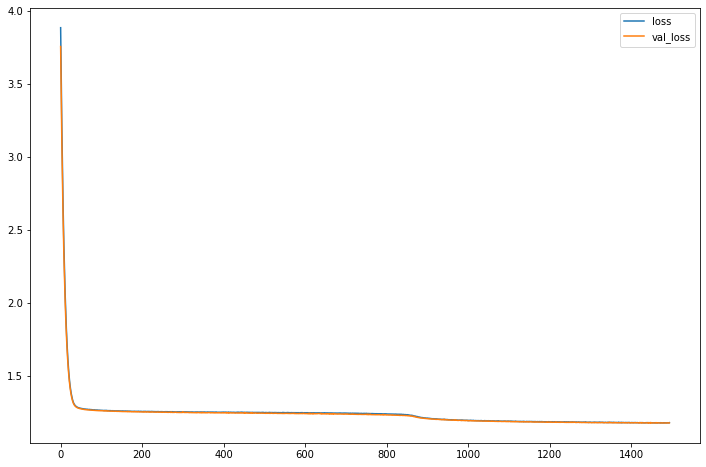

In [32]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

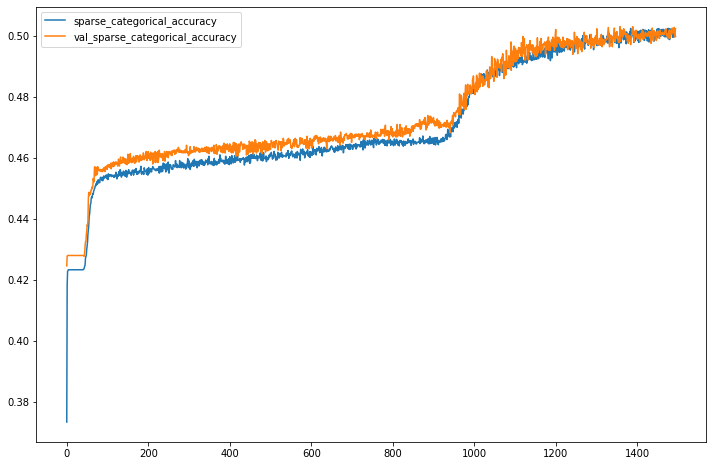

In [33]:
plt.figure(figsize=(12,8))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.legend(['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])

In [13]:
def create_LSTM_model(embedding_size, seq_len, classes, input_shape):
    model = keras.Sequential([
        layers.LSTM(units = 20, input_shape=input_shape, 
                    kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2)),
        layers.Flatten(),
        layers.Dense(int((embedding_size * seq_len)/10), activation="relu",
                    kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2)),
        layers.Dropout(0.3),
        layers.Dense(classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, 
                                           beta_1=0.8, beta_2=0.9999, epsilon=1e-08, amsgrad=True),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
    model.summary()
    return model

In [ ]:
INITILIZERS_ = {'orthogonal':tf.keras.initializers.Orthogonal(gain=1.0, seed=None),
               'he':tf.keras.initializers.HeUniform(seed=None),
               'zero': tf.keras.initializers.Constant(value=0)}
REGULARIZER_ =['l1l2':regularizers.l1_l2(l1=1e-3, l2=1e-2),
              'l1':tf.keras.regularizers.L1(l1=0.01),
              'l2':tf.keras.regularizers.L2(l2=0.01)]
OPTIMIZER_= ['SGD':tf.keras.optimizers.SGD(learning_rate=0.000001, momentum=0.9, nesterov=True),
            'Adam':tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.8, beta_2=0.9999, epsilon=1e-08, amsgrad=True)]

In [ ]:
def train_val_model(dataset, em_size, seq_len, model_type, epochs):
    if dataset == 'simpson':
        data_path = simpson_dict
    elif dataset == 'friends':
        data_path = friends_dict
    else: 
        raise 'Not valid dataset'
        
    checkpoint_callback = create_checkpoint_callback('./resources/checkpoints/' + model_type + '_' + 
                                          str(em_size) + '_' +str(seq_len))
    
    early_stop_callback = create_early_stop_callback()
    
    input_shape = (seq_len, em_size)
    
    model = model_creators[model_type](em_size, seq_len, data_path['classes'], 
                                       input_shape=input_shape)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), 
              epochs = epochs, verbose = 0, 
              callbacks=[checkpoint_callback, early_stop_callback])
    
    model_metrics_train = model.evaluate(x = X_train, y = y_train)
    model_metrics_val = model.evaluate(x = X_val, y = y_val)
    data = {'model_name': [model_type], 'embedding_size': [em_size], 'seq_len': [seq_len],
            'train_accuracy': [model_metrics_train[1]], 'train_precision': [model_metrics_train[2]], 'train_recall': [model_metrics_train[3]],
           'val_accuracy': [model_metrics_val[1]], 'val_precision': [model_metrics_val[2]], 'val_recall': [model_metrics_val[3]]}
    
    return pd.DataFrame(data=data)

In [ ]:
import json
import os
os.mkdir('models/{}'.format(counter))
